In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from IPython.display import display, Markdown
import matplotlib.colors as mcolors

In [2]:
# Display the full DataFrame without truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

# G League Website

## Traditional Stats

### Combined

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV', 'BLKA', 'PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

,TEAM,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-
0,Greensboro Swarm,105.8 (25),38.0 (28),85.7 (28),44.3 (26),9.6 (31),28.2 (31),33.9 (18),12.4 (2),16.1 (3),77.1 (6),13.8 (7),33.5 (12),47.3 (6),20.0 (31),15.8 (8),8.5 (18),4.3 (30),6.6 (26),19.8 (16),21.9 (4),4.0 (5)
1,Stockton Kings,114.9 (6),42.1 (4),89.3 (14),47.2 (5),13.8 (9),36.7 (17),37.6 (2),10.2 (17),13.9 (17),73.7 (17),12.4 (13),35.0 (4),47.4 (5),26.1 (6),16.2 (12),8.0 (25),6.8 (4),4.1 (1),19.4 (13),19.1 (22),3.2 (9)
2,Westchester Knicks,119.8 (1),44.3 (1),96.0 (1),46.1 (10),13.3 (12),38.5 (11),34.6 (12),10.6 (11),14.9 (7),70.8 (24),15.5 (1),35.2 (3),50.7 (1),26.2 (5),16.4 (13),8.5 (18),6.8 (4),6.4 (23),18.9 (9),21.0 (8),3.6 (7)
3,Sioux Falls Skyforce,113.5 (9),42.5 (3),88.8 (15),47.9 (2),11.9 (26),35.1 (23),33.8 (20),10.3 (15),13.6 (19),75.2 (12),11.6 (18),34.5 (5),46.0 (13),26.4 (4),15.9 (9),9.5 (10),5.9 (15),5.7 (15),18.6 (4),19.0 (23),7.4 (1)
4,Capital City Go-Go,114.1 (7),40.3 (16),83.0 (30),48.5 (1),12.4 (18),32.8 (27),37.9 (1),12.7 (1),15.9 (4),80.3 (1),10.6 (27),34.1 (10),44.7 (18),23.8 (20),19.1 (29),8.0 (25),6.7 (8),5.6 (13),20.9 (25),22.3 (2),5.0 (4)
5,Oklahoma City Blue,112.7 (11),39.7 (20),88.0 (20),45.1 (18),16.1 (2),42.9 (5),37.6 (2),10.6 (11),14.0 (15),75.5 (11),11.2 (25),35.9 (1),47.1 (7),25.0 (15),17.2 (17),8.5 (18),4.9 (24),6.3 (20),19.0 (10),19.9 (16),3.9 (6)
6,Grand Rapids Gold,110.0 (22),41.3 (11),89.4 (13),46.2 (9),12.6 (15),35.3 (21),35.6 (9),9.3 (27),12.5 (28),74.6 (15),12.2 (14),30.7 (29),42.9 (27),23.7 (21),15.0 (4),8.7 (15),4.7 (25),5.6 (13),19.8 (16),16.7 (30),-0.5 (18)
7,San Diego Clippers,115.2 (5),42.0 (5),91.6 (4),45.9 (12),11.7 (27),35.3 (21),33.2 (23),11.6 (4),16.5 (2),70.3 (25),12.7 (12),33.0 (18),45.7 (14),25.4 (12),15.2 (6),11.2 (3),6.0 (13),6.7 (28),21.2 (26),21.4 (7),6.5 (2)
8,Ciudad de Mexico Capitanes,105.0 (26),37.0 (31),82.5 (31),44.9 (21),13.9 (7),38.4 (12),36.3 (6),10.8 (9),14.0 (15),77.3 (5),8.7 (31),33.2 (16),41.9 (29),21.6 (29),18.3 (27),9.3 (11),5.4 (19),4.9 (4),20.8 (24),20.3 (14),1.6 (11)
9,College Park Skyhawks,109.4 (23),39.2 (22),87.1 (23),45.0 (20),13.0 (14),38.4 (12),34.0 (16),10.6 (11),13.5 (20),79.1 (3),11.3 (22),34.2 (9),45.5 (15),23.5 (23),15.9 (9),8.0 (25),5.0 (22),4.8 (2),20.6 (23),19.9 (16),3.4 (8)


## K-Means Clustering

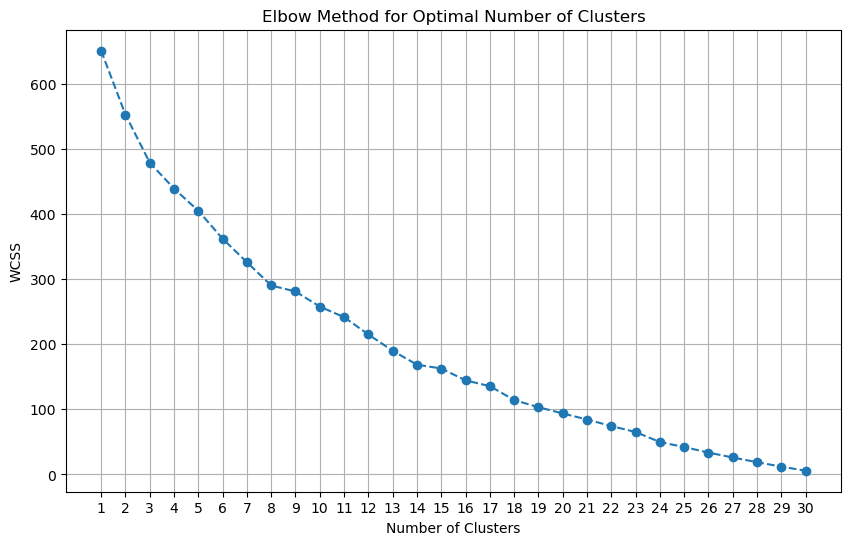

Enter the optimal number of clusters (as observed from the elbow plot): 8


,TEAM,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-,Cluster
0,Indiana Mad Ants,1.185 (1),0.443 (2),0.878 (18),75.8 (1),0.131 (15),0.336 (25),58.5 (4),0.095 (21),0.121 (25),117.8 (5),0.099 (25),0.33 (18),0.644 (22),0.285 (1),0.155 (8),0.081 (24),0.055 (14),0.058 (19),0.168 (4),0.174 (25),0.05 (7),5
1,Capital City Go-Go,1.175 (2),0.421 (5),0.846 (26),74.6 (2),0.157 (1),0.389 (9),60.3 (2),0.109 (7),0.145 (10),112.8 (9),0.096 (27),0.325 (20),0.632 (27),0.279 (2),0.174 (21),0.091 (13),0.072 (4),0.047 (6),0.195 (19),0.201 (9),0.08 (4),5
2,Osceola Magic,1.165 (3),0.419 (6),0.856 (23),73.5 (3),0.141 (9),0.388 (10),54.6 (10),0.109 (7),0.132 (17),124.4 (3),0.101 (23),0.321 (21),0.633 (25),0.255 (9),0.159 (11),0.077 (26),0.071 (6),0.055 (16),0.161 (2),0.18 (20),-0.027 (19),5
3,Stockton Kings,1.164 (4),0.426 (3),0.886 (12),72.0 (7),0.149 (5),0.381 (14),58.5 (4),0.1 (15),0.145 (10),103.5 (22),0.13 (12),0.353 (4),0.724 (5),0.255 (9),0.157 (9),0.08 (25),0.075 (3),0.037 (2),0.205 (27),0.179 (21),0.072 (5),2
4,Rio Grande Valley Vipers,1.162 (5),0.444 (1),0.905 (5),73.5 (3),0.14 (10),0.384 (13),54.6 (10),0.081 (27),0.121 (25),100.5 (28),0.145 (6),0.304 (26),0.674 (14),0.268 (5),0.166 (14),0.111 (3),0.07 (7),0.058 (19),0.214 (29),0.178 (23),0.04 (11),3
5,Westchester Knicks,1.145 (6),0.408 (13),0.934 (1),65.6 (28),0.147 (6),0.402 (5),54.9 (9),0.101 (14),0.139 (13),108.8 (15),0.152 (2),0.311 (25),0.694 (9),0.248 (13),0.147 (6),0.07 (29),0.051 (18),0.054 (12),0.16 (1),0.195 (12),-0.03 (20),2
6,Salt Lake City Stars,1.136 (7),0.399 (17),0.888 (9),67.4 (20),0.128 (17),0.367 (17),52.0 (19),0.125 (1),0.169 (3),110.8 (11),0.163 (1),0.289 (30),0.678 (13),0.227 (21),0.179 (27),0.108 (4),0.041 (25),0.052 (10),0.201 (23),0.211 (5),-0.047 (24),0
7,College Park Skyhawks,1.128 (8),0.4 (15),0.913 (3),65.7 (27),0.145 (7),0.416 (2),52.5 (16),0.106 (12),0.125 (22),127.4 (1),0.109 (20),0.34 (11),0.674 (14),0.246 (15),0.126 (1),0.105 (5),0.055 (14),0.054 (12),0.186 (14),0.185 (16),0.057 (6),2
8,Santa Cruz Warriors,1.127 (9),0.411 (8),0.878 (18),70.1 (11),0.156 (2),0.391 (8),60.0 (3),0.092 (23),0.126 (21),110.0 (13),0.131 (11),0.367 (1),0.748 (1),0.277 (3),0.166 (14),0.066 (31),0.057 (11),0.057 (18),0.182 (11),0.173 (26),0.035 (12),2
9,Sioux Falls Skyforce,1.105 (10),0.409 (9),0.884 (15),69.4 (12),0.126 (18),0.365 (18),51.9 (20),0.098 (17),0.139 (13),105.6 (19),0.098 (26),0.357 (2),0.682 (11),0.249 (12),0.129 (2),0.085 (18),0.072 (4),0.054 (12),0.19 (17),0.182 (18),0.048 (8),2


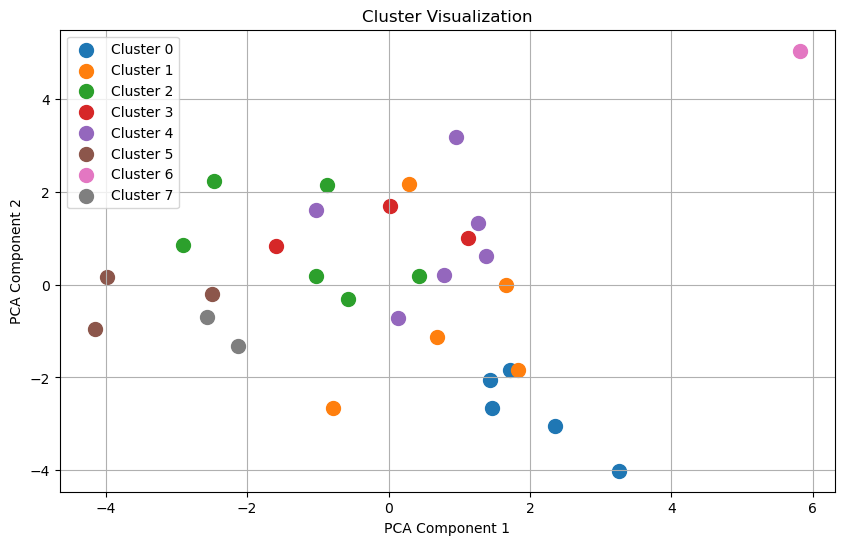

In [17]:
import os
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from threadpoolctl import threadpool_limits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
from IPython.display import display

# Suppress MKL-related warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak", category=UserWarning)

# Set environment variable for MKL threads (optional, but may help)
os.environ["OMP_NUM_THREADS"] = "1"

# Web scraping logic
# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path
options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')
driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=PTS&dir=-1&Season=2024-25&SeasonType=Regular%20Season&PerMode=PerPossession"

# Load the webpage
driver.get(url)
time.sleep(10)  # Allow time for JavaScript to load

# Locate the table and extract its data
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)
table_html = table_element.get_attribute('outerHTML')
team_stats = pd.read_html(table_html)[0]  # Convert the table HTML into a pandas DataFrame
driver.quit()  # Close the WebDriver

# Drop irrelevant columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Identify numeric columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define weights for grouped statistics
weights = {
    'FGM': 1.0, 'FGA': 1.0, 'FG%': 1.5,  # Give higher priority to FG%
    '3PM': 1.0, '3PA': 1.0, '3P%': 1.5,  # Give higher priority to 3P%
    'FTM': 1.0, 'FTA': 1.0, 'FT%': 1.5,  # Give higher priority to FT%
    'OREB': 1.0, 'DREB': 1.0, 'REB': 1.5  # Give higher priority to REB
}

# Apply weights to the numeric columns
weighted_team_stats = team_stats.copy()
for col, weight in weights.items():
    if col in weighted_team_stats.columns:
        weighted_team_stats[col] = weighted_team_stats[col] * weight

# Round specific categories after applying weights
rounding_rules = {'FG%': 1, '3P%': 1, 'FT%': 1, 'REB': 3}

# Apply rounding rules
for col, decimals in rounding_rules.items():
    if col in weighted_team_stats.columns:
        weighted_team_stats[col] = weighted_team_stats[col].round(decimals)

# Calculate ranks for numeric columns and append to the DataFrame
invert_cols = ['TOV', 'BLKA', 'PF']  # Columns where lower values are better
df_with_ranks = weighted_team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    if col in invert_cols:
        ranks = weighted_team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = weighted_team_stats[col].rank(ascending=False, method='min').astype(int)
    df_with_ranks[col] = weighted_team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for conditional formatting

# Standardize numeric data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(weighted_team_stats[numeric_cols])

# Elbow Method: Compute WCSS for different numbers of clusters
wcss = []
max_clusters = 30  # Test up to 30 clusters
for i in range(1, max_clusters + 1):
    with threadpool_limits(limits=1, user_api='blas'):  # Limit MKL threads
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)  # WCSS (Within-Cluster Sum of Squares)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

# Prompt user to enter the optimal number of clusters (based on the elbow chart)
optimal_clusters = int(input("Enter the optimal number of clusters (as observed from the elbow plot): "))

# Perform K-Means clustering
with threadpool_limits(limits=1, user_api='blas'):
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the DataFrame
df_with_ranks['Cluster'] = cluster_labels

# Define luminance function for text readability
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Define color_cells function for conditional formatting
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Best ranks in green
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame (include the Cluster column for display but exclude it from styling)
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
display(styled_df)

# Optional: Visualize the clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    cluster_points = reduced_data[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", s=100)
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

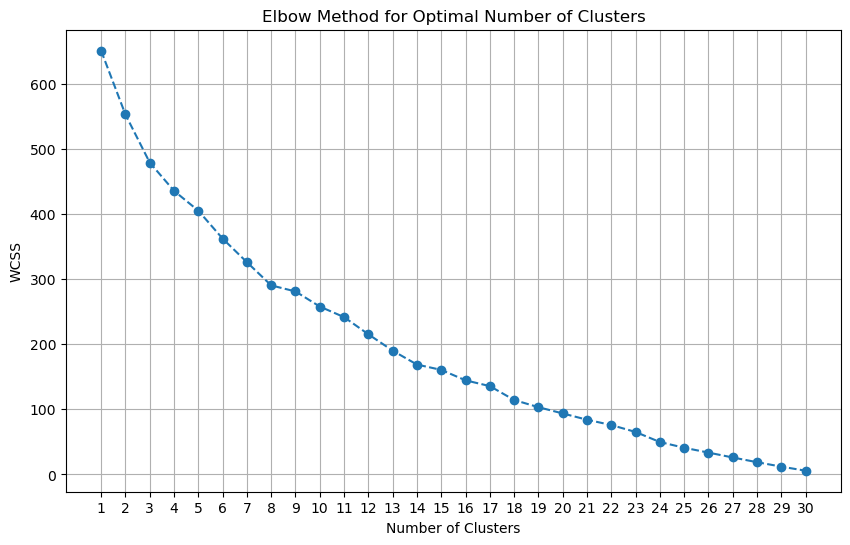

Enter the optimal number of clusters (as observed from the elbow plot): 8


,TEAM,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-,Cluster
0,Indiana Mad Ants,1.185 (1),0.443 (2),0.878 (18),75.75 (1),0.131 (15),0.336 (25),58.5 (4),0.095 (21),0.121 (25),117.75 (5),0.099 (25),0.33 (18),0.6435 (22),0.285 (1),0.155 (8),0.081 (24),0.055 (14),0.058 (19),0.168 (4),0.174 (25),0.05 (7),5
1,Capital City Go-Go,1.175 (2),0.421 (5),0.846 (26),74.55000000000001 (2),0.157 (1),0.389 (9),60.300000000000004 (2),0.109 (7),0.145 (10),112.80000000000001 (9),0.096 (27),0.325 (20),0.6315 (27),0.279 (2),0.174 (21),0.091 (13),0.072 (4),0.047 (6),0.195 (19),0.201 (9),0.08 (4),5
2,Osceola Magic,1.165 (3),0.419 (6),0.856 (23),73.5 (3),0.141 (9),0.388 (10),54.599999999999994 (10),0.109 (7),0.132 (17),124.35000000000001 (3),0.101 (23),0.321 (21),0.633 (25),0.255 (9),0.159 (11),0.077 (26),0.071 (6),0.055 (16),0.161 (2),0.18 (20),-0.027 (19),5
3,Stockton Kings,1.164 (4),0.426 (3),0.886 (12),72.0 (7),0.149 (5),0.381 (14),58.5 (4),0.1 (15),0.145 (10),103.5 (22),0.13 (12),0.353 (4),0.7244999999999999 (5),0.255 (9),0.157 (9),0.08 (25),0.075 (3),0.037 (2),0.205 (27),0.179 (21),0.072 (5),2
4,Rio Grande Valley Vipers,1.162 (5),0.444 (1),0.905 (5),73.5 (3),0.14 (10),0.384 (13),54.599999999999994 (10),0.081 (27),0.121 (25),100.5 (28),0.145 (6),0.304 (26),0.6735 (14),0.268 (5),0.166 (14),0.111 (3),0.07 (7),0.058 (19),0.214 (29),0.178 (23),0.04 (11),3
5,Westchester Knicks,1.145 (6),0.408 (13),0.934 (1),65.55000000000001 (28),0.147 (6),0.402 (5),54.900000000000006 (9),0.101 (14),0.139 (13),108.75 (15),0.152 (2),0.311 (25),0.6945 (9),0.248 (13),0.147 (6),0.07 (29),0.051 (18),0.054 (12),0.16 (1),0.195 (12),-0.03 (20),2
6,Salt Lake City Stars,1.136 (7),0.399 (17),0.888 (9),67.35 (20),0.128 (17),0.367 (17),52.050000000000004 (19),0.125 (1),0.169 (3),110.85000000000001 (11),0.163 (1),0.289 (30),0.678 (13),0.227 (21),0.179 (27),0.108 (4),0.041 (25),0.052 (10),0.201 (23),0.211 (5),-0.047 (24),0
7,College Park Skyhawks,1.128 (8),0.4 (15),0.913 (3),65.69999999999999 (27),0.145 (7),0.416 (2),52.5 (16),0.106 (12),0.125 (22),127.35000000000001 (1),0.109 (20),0.34 (11),0.6735 (14),0.246 (15),0.126 (1),0.105 (5),0.055 (14),0.054 (12),0.186 (14),0.185 (16),0.057 (6),2
8,Santa Cruz Warriors,1.127 (9),0.411 (8),0.878 (18),70.05000000000001 (11),0.156 (2),0.391 (8),60.0 (3),0.092 (23),0.126 (21),109.94999999999999 (13),0.131 (11),0.367 (1),0.7484999999999999 (1),0.277 (3),0.166 (14),0.066 (31),0.057 (11),0.057 (18),0.182 (11),0.173 (26),0.035 (12),2
9,Sioux Falls Skyforce,1.105 (10),0.409 (9),0.884 (15),69.44999999999999 (12),0.126 (18),0.365 (18),51.900000000000006 (20),0.098 (17),0.139 (13),105.60000000000001 (19),0.098 (26),0.357 (2),0.6825 (11),0.249 (12),0.129 (2),0.085 (18),0.072 (4),0.054 (12),0.19 (17),0.182 (18),0.048 (8),2


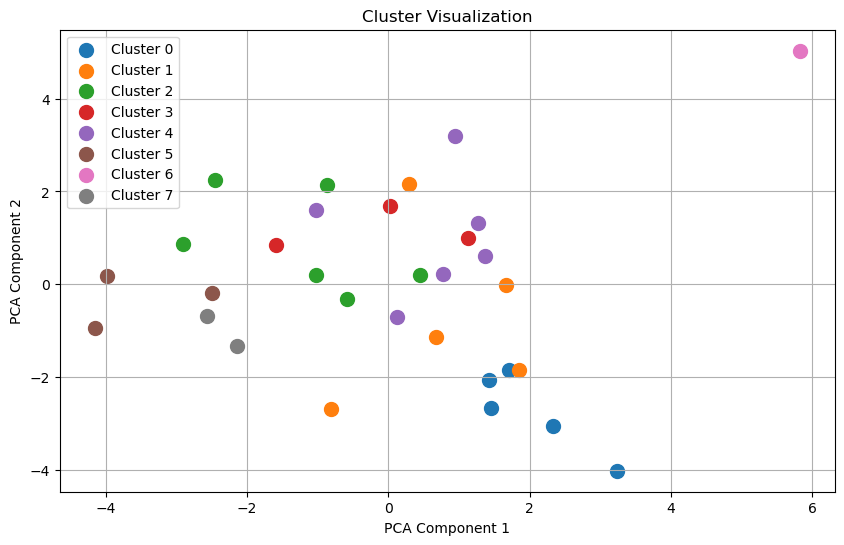

In [16]:
import os
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from threadpoolctl import threadpool_limits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
from IPython.display import display

# Suppress MKL-related warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak", category=UserWarning)

# Set environment variable for MKL threads (optional, but may help)
os.environ["OMP_NUM_THREADS"] = "1"

# Web scraping logic (from your first code)
# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path
options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')
driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=PTS&dir=-1&Season=2024-25&SeasonType=Regular%20Season&PerMode=PerPossession"

# Load the webpage
driver.get(url)
time.sleep(10)  # Allow time for JavaScript to load

# Locate the table and extract its data
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)
table_html = table_element.get_attribute('outerHTML')
team_stats = pd.read_html(table_html)[0]  # Convert the table HTML into a pandas DataFrame
driver.quit()  # Close the WebDriver

# Drop irrelevant columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Identify numeric columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define weights for grouped statistics
weights = {
    'FGM': 1.0, 'FGA': 1.0, 'FG%': 1.5,  # Give higher priority to FG%
    '3PM': 1.0, '3PA': 1.0, '3P%': 1.5,  # Give higher priority to 3P%
    'FTM': 1.0, 'FTA': 1.0, 'FT%': 1.5,  # Give higher priority to FT%
    'OREB': 1.0, 'DREB': 1.0, 'REB': 1.5  # Give higher priority to REB
}

# Apply weights to the numeric columns
weighted_team_stats = team_stats.copy()
for col, weight in weights.items():
    if col in weighted_team_stats.columns:
        weighted_team_stats[col] = weighted_team_stats[col] * weight

# Calculate ranks for numeric columns and append to the DataFrame
invert_cols = ['TOV', 'BLKA', 'PF']  # Columns where lower values are better
df_with_ranks = weighted_team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    if col in invert_cols:
        ranks = weighted_team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = weighted_team_stats[col].rank(ascending=False, method='min').astype(int)
    df_with_ranks[col] = weighted_team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for conditional formatting

# Standardize numeric data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(weighted_team_stats[numeric_cols])

# Elbow Method: Compute WCSS for different numbers of clusters
wcss = []
max_clusters = 30  # Test up to 30 clusters
for i in range(1, max_clusters + 1):
    with threadpool_limits(limits=1, user_api='blas'):  # Limit MKL threads
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)  # WCSS (Within-Cluster Sum of Squares)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

# Prompt user to enter the optimal number of clusters (based on the elbow chart)
optimal_clusters = int(input("Enter the optimal number of clusters (as observed from the elbow plot): "))

# Perform K-Means clustering
with threadpool_limits(limits=1, user_api='blas'):
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the DataFrame
df_with_ranks['Cluster'] = cluster_labels

# Define luminance function for text readability
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Define color_cells function for conditional formatting
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Best ranks in green
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame (include the Cluster column for display but exclude it from styling)
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
display(styled_df)

# Optional: Visualize the clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    cluster_points = reduced_data[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", s=100)
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

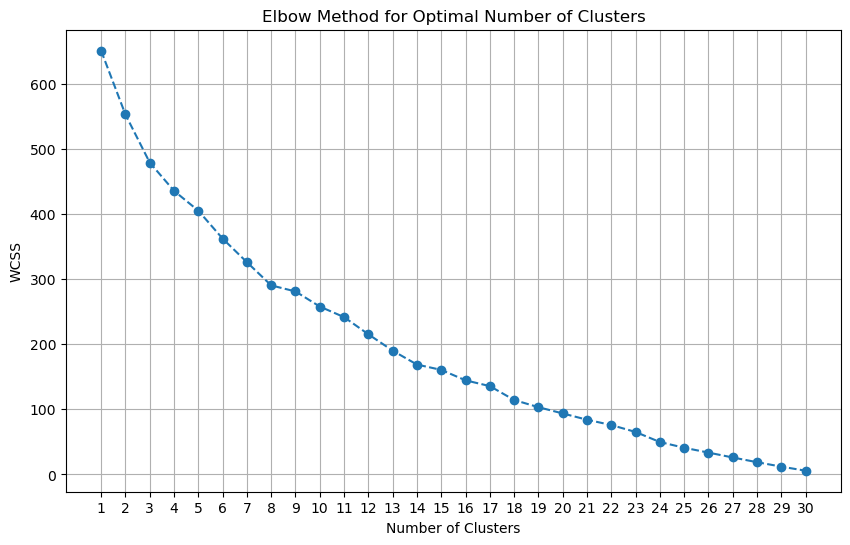

Enter the optimal number of clusters (as observed from the elbow plot): 8


,TEAM,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-,Cluster
0,Indiana Mad Ants,1.185 (1),0.443 (2),0.878 (18),50.5 (1),0.131 (15),0.336 (25),39.0 (4),0.095 (21),0.121 (25),78.5 (5),0.099 (25),0.33 (18),0.429 (22),0.285 (1),0.155 (8),0.081 (24),0.055 (14),0.058 (19),0.168 (4),0.174 (25),0.05 (7),5
1,Capital City Go-Go,1.175 (2),0.421 (5),0.846 (26),49.7 (2),0.157 (1),0.389 (9),40.2 (2),0.109 (7),0.145 (10),75.2 (9),0.096 (27),0.325 (20),0.421 (27),0.279 (2),0.174 (21),0.091 (13),0.072 (4),0.047 (6),0.195 (19),0.201 (9),0.08 (4),5
2,Osceola Magic,1.165 (3),0.419 (6),0.856 (23),49.0 (3),0.141 (9),0.388 (10),36.4 (10),0.109 (7),0.132 (17),82.9 (3),0.101 (23),0.321 (21),0.422 (25),0.255 (9),0.159 (11),0.077 (26),0.071 (6),0.055 (16),0.161 (2),0.18 (20),-0.027 (19),5
3,Stockton Kings,1.164 (4),0.426 (3),0.886 (12),48.0 (7),0.149 (5),0.381 (14),39.0 (4),0.1 (15),0.145 (10),69.0 (22),0.13 (12),0.353 (4),0.483 (5),0.255 (9),0.157 (9),0.08 (25),0.075 (3),0.037 (2),0.205 (27),0.179 (21),0.072 (5),2
4,Rio Grande Valley Vipers,1.162 (5),0.444 (1),0.905 (5),49.0 (3),0.14 (10),0.384 (13),36.4 (10),0.081 (27),0.121 (25),67.0 (28),0.145 (6),0.304 (26),0.449 (14),0.268 (5),0.166 (14),0.111 (3),0.07 (7),0.058 (19),0.214 (29),0.178 (23),0.04 (11),3
5,Westchester Knicks,1.145 (6),0.408 (13),0.934 (1),43.7 (28),0.147 (6),0.402 (5),36.6 (9),0.101 (14),0.139 (13),72.5 (15),0.152 (2),0.311 (25),0.463 (9),0.248 (13),0.147 (6),0.07 (29),0.051 (18),0.054 (12),0.16 (1),0.195 (12),-0.03 (20),2
6,Salt Lake City Stars,1.136 (7),0.399 (17),0.888 (9),44.9 (20),0.128 (17),0.367 (17),34.7 (19),0.125 (1),0.169 (3),73.9 (11),0.163 (1),0.289 (30),0.452 (13),0.227 (21),0.179 (27),0.108 (4),0.041 (25),0.052 (10),0.201 (23),0.211 (5),-0.047 (24),0
7,College Park Skyhawks,1.128 (8),0.4 (15),0.913 (3),43.8 (27),0.145 (7),0.416 (2),35.0 (16),0.106 (12),0.125 (22),84.9 (1),0.109 (20),0.34 (11),0.449 (14),0.246 (15),0.126 (1),0.105 (5),0.055 (14),0.054 (12),0.186 (14),0.185 (16),0.057 (6),2
8,Santa Cruz Warriors,1.127 (9),0.411 (8),0.878 (18),46.7 (11),0.156 (2),0.391 (8),40.0 (3),0.092 (23),0.126 (21),73.3 (13),0.131 (11),0.367 (1),0.499 (1),0.277 (3),0.166 (14),0.066 (31),0.057 (11),0.057 (18),0.182 (11),0.173 (26),0.035 (12),2
9,Sioux Falls Skyforce,1.105 (10),0.409 (9),0.884 (15),46.3 (12),0.126 (18),0.365 (18),34.6 (20),0.098 (17),0.139 (13),70.4 (19),0.098 (26),0.357 (2),0.455 (11),0.249 (12),0.129 (2),0.085 (18),0.072 (4),0.054 (12),0.19 (17),0.182 (18),0.048 (8),2


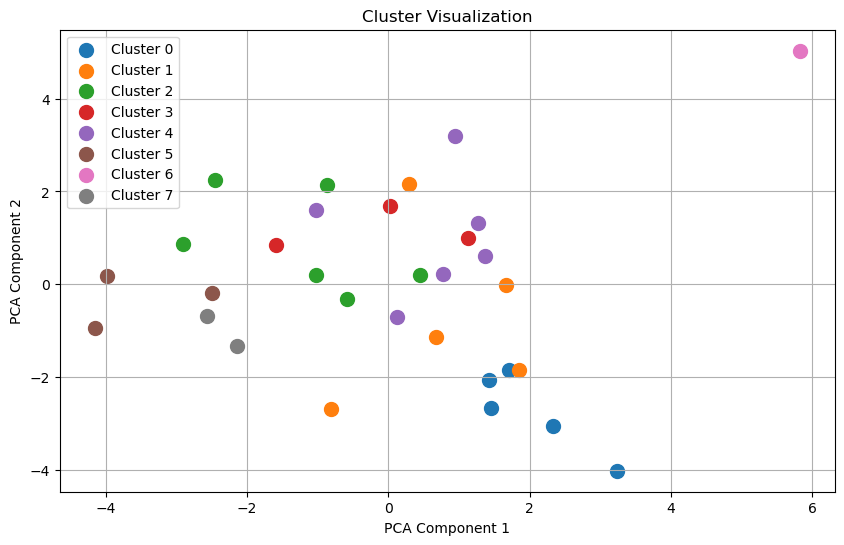

In [15]:
import os
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from threadpoolctl import threadpool_limits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
from IPython.display import display

# Suppress MKL-related warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak", category=UserWarning)

# Set environment variable for MKL threads (optional, but may help)
os.environ["OMP_NUM_THREADS"] = "1"

# Web scraping logic (from your first code)
# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path
options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')
driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=PTS&dir=-1&Season=2024-25&SeasonType=Regular%20Season&PerMode=PerPossession"

# Load the webpage
driver.get(url)
time.sleep(10)  # Allow time for JavaScript to load

# Locate the table and extract its data
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)
table_html = table_element.get_attribute('outerHTML')
team_stats = pd.read_html(table_html)[0]  # Convert the table HTML into a pandas DataFrame
driver.quit()  # Close the WebDriver

# Drop irrelevant columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Identify numeric columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks for numeric columns and append to the DataFrame
invert_cols = ['TOV', 'BLKA', 'PF']  # Columns where lower values are better
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for conditional formatting

# Standardize numeric data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(team_stats[numeric_cols])

# Elbow Method: Compute WCSS for different numbers of clusters
wcss = []
max_clusters = 30  # Test up to 30 clusters
for i in range(1, max_clusters + 1):
    with threadpool_limits(limits=1, user_api='blas'):  # Limit MKL threads
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)  # WCSS (Within-Cluster Sum of Squares)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

# Prompt user to enter the optimal number of clusters (based on the elbow chart)
optimal_clusters = int(input("Enter the optimal number of clusters (as observed from the elbow plot): "))

# Perform K-Means clustering
with threadpool_limits(limits=1, user_api='blas'):
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the DataFrame
df_with_ranks['Cluster'] = cluster_labels

# Define luminance function for text readability
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Define color_cells function for conditional formatting
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Best ranks in green
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame (include the Cluster column for display but exclude it from styling)
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
display(styled_df)

# Optional: Visualize the clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    cluster_points = reduced_data[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", s=100)
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

,TEAM,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-,Cluster
0,Greensboro Swarm,105.8 (25),38.0 (28),85.7 (28),44.3 (26),9.6 (31),28.2 (31),33.9 (18),12.4 (2),16.1 (3),77.1 (6),13.8 (7),33.5 (12),47.3 (6),20.0 (31),15.8 (8),8.5 (18),4.3 (30),6.6 (26),19.8 (16),21.9 (4),4.0 (5),0
1,Stockton Kings,114.9 (6),42.1 (4),89.3 (14),47.2 (5),13.8 (9),36.7 (17),37.6 (2),10.2 (17),13.9 (17),73.7 (17),12.4 (13),35.0 (4),47.4 (5),26.1 (6),16.2 (12),8.0 (25),6.8 (4),4.1 (1),19.4 (13),19.1 (22),3.2 (9),1
2,Westchester Knicks,119.8 (1),44.3 (1),96.0 (1),46.1 (10),13.3 (12),38.5 (11),34.6 (12),10.6 (11),14.9 (7),70.8 (24),15.5 (1),35.2 (3),50.7 (1),26.2 (5),16.4 (13),8.5 (18),6.8 (4),6.4 (23),18.9 (9),21.0 (8),3.6 (7),0
3,Sioux Falls Skyforce,113.5 (9),42.5 (3),88.8 (15),47.9 (2),11.9 (26),35.1 (23),33.8 (20),10.3 (15),13.6 (19),75.2 (12),11.6 (18),34.5 (5),46.0 (13),26.4 (4),15.9 (9),9.5 (10),5.9 (15),5.7 (15),18.6 (4),19.0 (23),7.4 (1),1
4,Capital City Go-Go,114.1 (7),40.3 (16),83.0 (30),48.5 (1),12.4 (18),32.8 (27),37.9 (1),12.7 (1),15.9 (4),80.3 (1),10.6 (27),34.1 (10),44.7 (18),23.8 (20),19.1 (29),8.0 (25),6.7 (8),5.6 (13),20.9 (25),22.3 (2),5.0 (4),1
5,Oklahoma City Blue,112.7 (11),39.7 (20),88.0 (20),45.1 (18),16.1 (2),42.9 (5),37.6 (2),10.6 (11),14.0 (15),75.5 (11),11.2 (25),35.9 (1),47.1 (7),25.0 (15),17.2 (17),8.5 (18),4.9 (24),6.3 (20),19.0 (10),19.9 (16),3.9 (6),1
6,Grand Rapids Gold,110.0 (22),41.3 (11),89.4 (13),46.2 (9),12.6 (15),35.3 (21),35.6 (9),9.3 (27),12.5 (28),74.6 (15),12.2 (14),30.7 (29),42.9 (27),23.7 (21),15.0 (4),8.7 (15),4.7 (25),5.6 (13),19.8 (16),16.7 (30),-0.5 (18),1
7,San Diego Clippers,115.2 (5),42.0 (5),91.6 (4),45.9 (12),11.7 (27),35.3 (21),33.2 (23),11.6 (4),16.5 (2),70.3 (25),12.7 (12),33.0 (18),45.7 (14),25.4 (12),15.2 (6),11.2 (3),6.0 (13),6.7 (28),21.2 (26),21.4 (7),6.5 (2),0
8,Ciudad de Mexico Capitanes,105.0 (26),37.0 (31),82.5 (31),44.9 (21),13.9 (7),38.4 (12),36.3 (6),10.8 (9),14.0 (15),77.3 (5),8.7 (31),33.2 (16),41.9 (29),21.6 (29),18.3 (27),9.3 (11),5.4 (19),4.9 (4),20.8 (24),20.3 (14),1.6 (11),1
9,College Park Skyhawks,109.4 (23),39.2 (22),87.1 (23),45.0 (20),13.0 (14),38.4 (12),34.0 (16),10.6 (11),13.5 (20),79.1 (3),11.3 (22),34.2 (9),45.5 (15),23.5 (23),15.9 (9),8.0 (25),5.0 (22),4.8 (2),20.6 (23),19.9 (16),3.4 (8),1


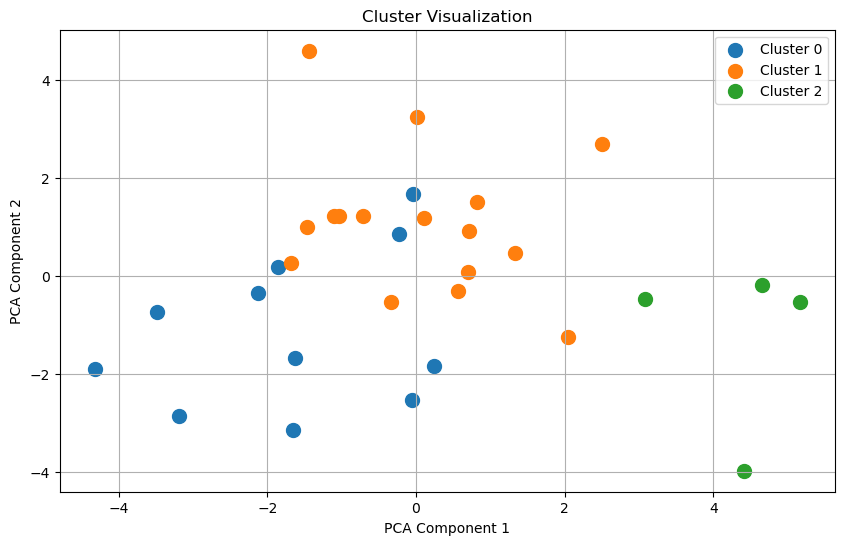

In [9]:
import os
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from threadpoolctl import threadpool_limits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
from IPython.display import display

# Suppress MKL-related warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak", category=UserWarning)

# Set environment variable for MKL threads (optional, but may help)
os.environ["OMP_NUM_THREADS"] = "1"

# Web scraping logic (from your first code)
# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path
options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')
driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)
time.sleep(10)  # Allow time for JavaScript to load

# Locate the table and extract its data
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)
table_html = table_element.get_attribute('outerHTML')
team_stats = pd.read_html(table_html)[0]  # Convert the table HTML into a pandas DataFrame
driver.quit()  # Close the WebDriver

# Drop irrelevant columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Identify numeric columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks for numeric columns and append to the DataFrame
invert_cols = ['TOV', 'BLKA', 'PF']  # Columns where lower values are better
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for conditional formatting

# Standardize numeric data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(team_stats[numeric_cols])

# Perform K-Means clustering
optimal_clusters = 3  # You can use the elbow method to determine this dynamically
with threadpool_limits(limits=1, user_api='blas'):
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the DataFrame
df_with_ranks['Cluster'] = cluster_labels

# Define luminance function for text readability
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Define color_cells function for conditional formatting
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Best ranks in green
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame (include the Cluster column for display but exclude it from styling)
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
display(styled_df)

# Optional: Visualize the clusters using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    cluster_points = reduced_data[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", s=100)
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

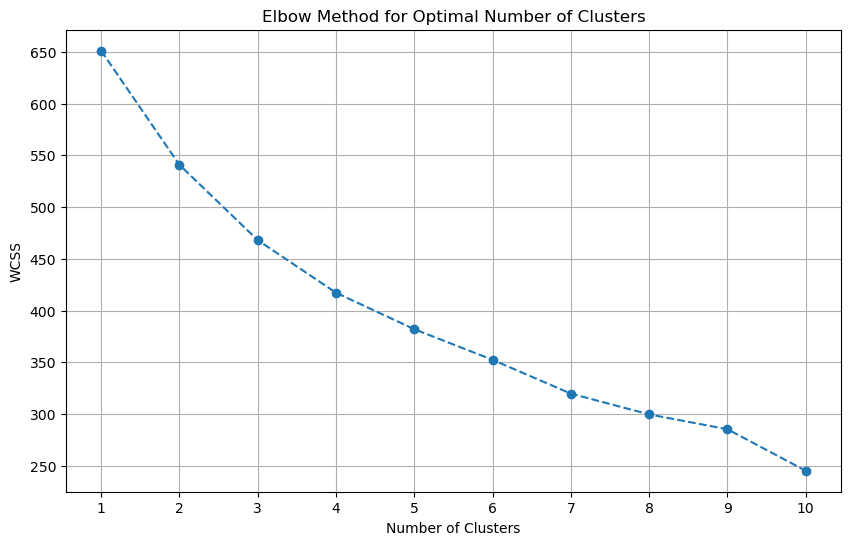

Enter the optimal number of clusters (as observed from the elbow plot): 10


,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-,Cluster
0,25,28,28,26,31,31,18,2,3,6,7,12,6,31,8,18,30,26,16,4,5,6
1,6,4,14,5,9,17,2,17,17,17,13,4,5,6,12,25,4,1,13,22,9,8
2,1,1,1,10,12,11,12,11,7,24,1,3,1,5,13,18,4,23,9,8,7,3
3,9,3,15,2,26,23,20,15,19,12,18,5,13,4,9,10,15,15,4,23,1,1
4,7,16,30,1,18,27,1,1,4,1,27,10,18,20,29,25,8,13,25,2,4,9
5,11,20,20,18,2,5,2,11,15,11,25,1,7,15,17,18,24,20,10,16,6,8
6,22,11,13,9,15,21,9,27,28,15,14,29,27,21,4,15,25,13,16,30,18,1
7,5,5,4,12,27,21,23,4,2,25,12,18,14,12,6,3,13,28,26,7,2,7
8,26,31,31,21,7,12,6,9,15,5,31,16,29,29,27,11,19,4,24,14,11,9
9,23,22,23,20,14,12,16,11,20,3,22,9,15,23,9,25,22,2,23,16,8,9


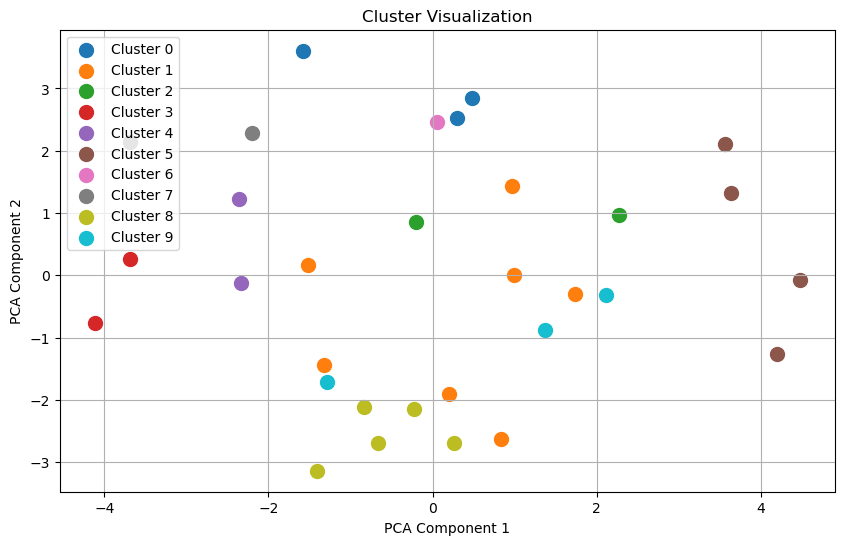

In [7]:
import os
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from threadpoolctl import threadpool_limits
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from IPython.display import display

# Suppress MKL-related warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak", category=UserWarning)

# Set environment variable for MKL threads (optional, but may help)
os.environ["OMP_NUM_THREADS"] = "1"

# Example Data: Replace this with your actual DataFrame
ranked_data = pd.DataFrame(ranks_data)  # Uncomment when ranks_data is defined

# Standardize the data (important for K-Means)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ranked_data)

# Use the elbow method to find the optimal number of clusters
wcss = []  # Within-Cluster Sum of Squares
max_clusters = 10  # Define the maximum number of clusters to test
for i in range(1, max_clusters + 1):
    with threadpool_limits(limits=1, user_api='blas'):  # Limit MKL threads
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)  # Inertia is the WCSS for K-Means

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

# From the elbow plot, determine the optimal number of clusters
optimal_clusters = int(input("Enter the optimal number of clusters (as observed from the elbow plot): "))

# Apply K-Means clustering with the optimal number of clusters
with threadpool_limits(limits=1, user_api='blas'):  # Limit MKL threads
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original DataFrame
df_with_ranks = ranked_data.copy()
df_with_ranks['Cluster'] = cluster_labels

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Ensure numeric columns are correctly identified, excluding non-ranked columns like 'Cluster'
numeric_cols = [col for col in df_with_ranks.columns if col in ranks_data]

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame (with color formatting)
display(styled_df)

# Optional: Visualize the clusters (2D using PCA if there are many dimensions)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    cluster_points = reduced_data[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", s=100)
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

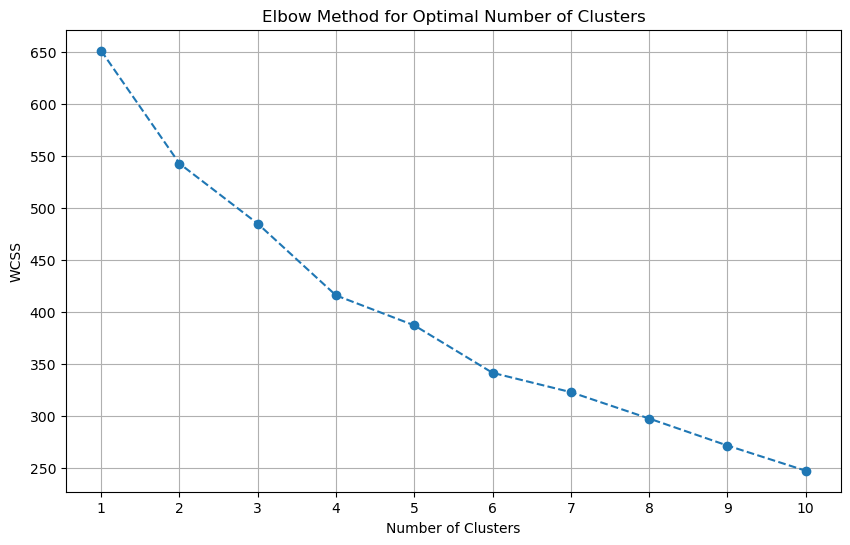

Enter the optimal number of clusters (as observed from the elbow plot): 10


,TEAM,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-,Cluster
0,Greensboro Swarm,105.8 (25),38.0 (28),85.6 (28),44.3 (26),9.6 (31),28.2 (31),33.9 (18),12.4 (2),16.1 (3),77.1 (6),13.8 (8),33.5 (12),47.3 (5),19.9 (31),15.8 (8),8.5 (18),4.3 (30),6.5 (26),19.8 (16),21.9 (4),4.0 (6),3
1,Stockton Kings,114.9 (5),42.1 (4),89.3 (13),47.2 (5),13.8 (8),36.7 (17),37.6 (2),10.2 (17),13.9 (16),73.7 (17),12.4 (13),35.0 (3),47.4 (4),26.1 (6),16.3 (12),8.0 (26),6.7 (8),4.0 (1),19.4 (13),19.1 (22),3.2 (9),8
2,Capital City Go-Go,113.9 (8),40.1 (17),82.9 (30),48.4 (1),12.5 (16),32.8 (27),38.1 (1),12.7 (1),15.9 (4),80.2 (1),10.7 (26),34.1 (9),44.8 (17),23.5 (22),19.1 (29),8.1 (25),6.9 (5),5.6 (13),20.7 (24),22.4 (2),5.5 (4),3
3,Oklahoma City Blue,112.5 (12),39.6 (21),88.0 (20),45.0 (19),16.0 (2),42.8 (5),37.5 (3),10.6 (10),13.9 (16),76.1 (9),11.3 (22),36.0 (1),47.3 (5),24.6 (16),17.2 (18),8.5 (18),4.7 (24),6.2 (20),18.7 (6),19.9 (16),4.2 (5),1
4,Westchester Knicks,119.8 (1),44.3 (1),95.9 (1),46.2 (9),13.3 (12),38.5 (11),34.6 (12),10.6 (10),14.9 (7),70.8 (24),15.5 (1),35.2 (2),50.7 (1),26.2 (5),16.4 (13),8.5 (18),6.8 (6),6.4 (23),18.9 (10),21.0 (8),3.6 (7),8
5,Sioux Falls Skyforce,113.5 (9),42.5 (3),88.8 (15),47.9 (2),11.9 (26),35.1 (23),33.8 (20),10.3 (15),13.6 (19),75.2 (12),11.6 (18),34.5 (5),46.1 (11),26.5 (4),15.9 (9),9.4 (10),5.9 (15),5.7 (15),18.6 (4),19.0 (23),7.4 (1),8
6,Grand Rapids Gold,110.0 (22),41.3 (10),89.4 (12),46.2 (9),12.6 (15),35.3 (21),35.6 (8),9.3 (27),12.5 (28),74.6 (15),12.2 (14),30.7 (29),42.9 (27),23.6 (21),15.0 (4),8.7 (15),4.7 (24),5.6 (13),19.8 (16),16.7 (30),-0.5 (18),0
7,San Diego Clippers,115.2 (4),42.0 (5),91.5 (4),45.9 (12),11.7 (27),35.3 (21),33.2 (23),11.6 (4),16.5 (2),70.3 (25),12.7 (11),33.0 (18),45.7 (14),25.3 (12),15.2 (6),11.2 (3),6.0 (13),6.7 (28),21.2 (26),21.4 (6),6.5 (2),2
8,Valley Suns,115.8 (3),41.4 (9),91.5 (4),45.2 (15),16.7 (1),45.1 (1),37.1 (5),10.1 (18),13.3 (22),76.1 (9),9.4 (30),34.0 (11),43.4 (25),25.7 (9),14.6 (2),8.3 (22),4.6 (28),5.1 (7),20.0 (18),20.4 (12),-0.5 (18),0
9,Ciudad de Mexico Capitanes,105.0 (26),37.0 (31),82.5 (31),44.9 (21),13.9 (7),38.4 (12),36.3 (6),10.8 (8),14.0 (15),77.3 (5),8.7 (31),33.3 (16),42.0 (29),21.5 (29),18.3 (26),9.3 (11),5.4 (20),4.9 (4),20.8 (25),20.3 (13),1.6 (11),3


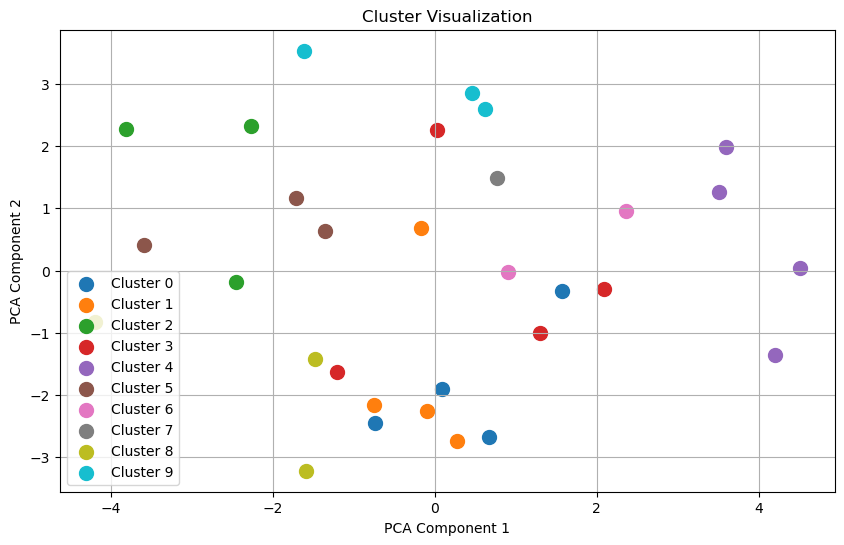

In [13]:
import os
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from threadpoolctl import threadpool_limits
import matplotlib.pyplot as plt
import numpy as np

# Suppress MKL-related warning
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak", category=UserWarning)

# Set environment variable for MKL threads (optional, but may help)
os.environ["OMP_NUM_THREADS"] = "1"

# Example Data: Replace this with your own DataFrame
ranked_data = pd.DataFrame(ranks_data)  # Uncomment when ranks_data is defined

# Standardize the data (important for K-Means)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ranked_data)

# Use the elbow method to find the optimal number of clusters
wcss = []  # Within-Cluster Sum of Squares
max_clusters = 10  # Define the maximum number of clusters to test
for i in range(1, max_clusters + 1):
    with threadpool_limits(limits=1, user_api='blas'):  # Limit MKL threads
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(scaled_data)
        wcss.append(kmeans.inertia_)  # Inertia is the WCSS for K-Means

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

# From the elbow plot, determine the optimal number of clusters
optimal_clusters = int(input("Enter the optimal number of clusters (as observed from the elbow plot): "))

# Apply K-Means clustering with the optimal number of clusters
with threadpool_limits(limits=1, user_api='blas'):  # Limit MKL threads
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original DataFrame
df_with_ranks['Cluster'] = cluster_labels

from IPython.display import display

# Display the clustered DataFrame as a formatted table
display(df_with_ranks)

# Optional: Visualize the clusters (2D using PCA if there are many dimensions)
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_data)

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in np.unique(cluster_labels):
    cluster_points = reduced_data[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", s=100)
plt.title('Cluster Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV', 'BLKA', 'PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV', 'BLKA', 'PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV', 'BLKA', 'PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

,TEAM,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-
21,Raptors 905,112.3 (14),42.0 (5),88.2 (18),47.6 (4),12.0 (25),33.6 (25),35.6 (8),9.6 (23),14.6 (9),65.5 (31),11.5 (20),31.5 (26),43.0 (26),27.4 (2),18.3 (26),10.0 (5),6.0 (13),6.2 (20),24.8 (31),22.0 (3),-3.2 (25)


### Regular Season

In [4]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV', 'BLKA', 'PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

,TEAM,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,+/-
7,Raptors 905,113.7 (9),40.3 (19),85.5 (24),47.2 (8),12.8 (18),31.3 (28),41.0 (2),11.3 (4),16.7 (4),68.0 (24),11.8 (17),35.5 (8),47.3 (8),28.8 (2),19.2 (29),9.2 (15),5.2 (16),6.3 (25),25.0 (31),21.7 (5),5.2 (7)


### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV', 'BLKA', 'PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV', 'BLKA', 'PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=W_PCT&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV', 'BLKA', 'PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/traditional/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV', 'BLKA', 'PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

## Advanced Stats

In [14]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/advanced/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', 'OffRtg RANK', 'DefRtg RANK', 'NetRtg RANK', 'AST% RANK',
    'AST/TO RANK', 'AST Ratio RANK', 'OREB% RANK', 'DREB% RANK',
    'REB% RANK', 'TO Ratio RANK', 'eFG% RANK', 'TS% RANK', 'PACE RANK',
    'PIE RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['DefRtg', 'TOV%']  # Invert ranks for specified columns
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

,TEAM,OffRtg,DefRtg,NetRtg,AST%,AST/TO,AST Ratio,OREB%,DREB%,REB%,TOV%,eFG%,TS%,PACE,PIE
0,Indiana Mad Ants,119.1 (1),115.1 (26),4.0 (11),65.0 (6),1.88 (3),20.2 (1),32.1 (13),69.0 (17),51.7 (7),15.3 (8),58.4 (2),64.2 (2),99.33 (24),53.2 (9)
1,Santa Cruz Warriors,112.7 (8),110.6 (18),2.1 (12),67.3 (3),1.66 (6),19.3 (4),32.4 (12),72.8 (4),53.4 (2),16.6 (15),55.6 (7),60.3 (8),101.64 (13),52.5 (11)
2,Stockton Kings,115.4 (5),106.4 (8),9.1 (3),57.8 (21),1.55 (11),17.6 (13),31.9 (15),68.0 (20),50.9 (12),16.0 (12),56.5 (5),60.8 (6),101.0 (14),54.2 (5)
3,Delaware Blue Coats,108.4 (19),110.1 (17),-1.7 (18),52.3 (30),1.55 (11),14.9 (30),30.8 (17),67.7 (21),47.8 (28),13.1 (4),49.3 (30),55.6 (30),100.06 (19),48.1 (20)
4,Greensboro Swarm,109.3 (14),100.0 (3),9.3 (2),56.9 (23),1.41 (18),16.0 (23),34.2 (6),73.0 (3),53.5 (1),15.9 (10),49.9 (29),57.5 (20),95.36 (30),55.2 (3)
5,Maine Celtics,108.4 (19),108.5 (13),-0.1 (16),59.5 (16),1.51 (15),16.6 (20),29.6 (21),69.9 (13),48.3 (26),15.2 (7),51.9 (23),57.1 (26),99.05 (25),48.7 (19)
6,Raptors 905,109.3 (14),104.9 (6),4.3 (9),70.5 (2),1.55 (11),19.4 (3),29.5 (22),70.5 (10),51.1 (9),17.7 (24),55.2 (8),61.6 (4),102.61 (8),52.7 (10)
7,Austin Spurs,108.6 (18),98.8 (1),9.8 (1),58.5 (18),1.45 (16),16.1 (22),32.7 (11),69.8 (14),50.9 (12),15.7 (9),51.0 (27),56.9 (27),102.25 (10),56.7 (1)
8,Capital City Go-Go,117.5 (2),109.2 (14),8.4 (5),66.6 (4),1.61 (7),19.9 (2),28.0 (24),62.7 (31),46.6 (30),17.4 (21),59.1 (1),64.7 (1),99.57 (21),54.9 (4)
9,Ciudad de Mexico Capitanes,109.3 (14),100.7 (4),8.7 (4),57.4 (22),1.36 (22),17.1 (18),25.3 (28),70.1 (12),49.7 (18),16.9 (18),56.1 (6),61.5 (5),100.04 (20),55.5 (2)


### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/advanced/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', 'OffRtg RANK', 'DefRtg RANK', 'NetRtg RANK', 'AST% RANK',
    'AST/TO RANK', 'AST Ratio RANK', 'OREB% RANK', 'DREB% RANK',
    'REB% RANK', 'TO Ratio RANK', 'eFG% RANK', 'TS% RANK', 'PACE RANK',
    'PIE RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['DefRtg', 'TOV%']  # Invert ranks for specified columns
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping
    
    # Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/advanced/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', 'OffRtg RANK', 'DefRtg RANK', 'NetRtg RANK', 'AST% RANK',
    'AST/TO RANK', 'AST Ratio RANK', 'OREB% RANK', 'DREB% RANK',
    'REB% RANK', 'TO Ratio RANK', 'eFG% RANK', 'TS% RANK', 'PACE RANK',
    'PIE RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['DefRtg', 'TOV%']  # Invert ranks for specified columns
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping
    
    # Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/advanced/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', 'OffRtg RANK', 'DefRtg RANK', 'NetRtg RANK', 'AST% RANK',
    'AST/TO RANK', 'AST Ratio RANK', 'OREB% RANK', 'DREB% RANK',
    'REB% RANK', 'TO Ratio RANK', 'eFG% RANK', 'TS% RANK', 'PACE RANK',
    'PIE RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['DefRtg', 'TOV%']  # Invert ranks for specified columns
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping
    
    # Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/advanced/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', 'OffRtg RANK', 'DefRtg RANK', 'NetRtg RANK', 'AST% RANK',
    'AST/TO RANK', 'AST Ratio RANK', 'OREB% RANK', 'DREB% RANK',
    'REB% RANK', 'TO Ratio RANK', 'eFG% RANK', 'TS% RANK', 'PACE RANK',
    'PIE RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['DefRtg', 'TOV%']  # Invert ranks for specified columns
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping
    
    # Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/advanced/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', 'OffRtg RANK', 'DefRtg RANK', 'NetRtg RANK', 'AST% RANK',
    'AST/TO RANK', 'AST Ratio RANK', 'OREB% RANK', 'DREB% RANK',
    'REB% RANK', 'TO Ratio RANK', 'eFG% RANK', 'TS% RANK', 'PACE RANK',
    'PIE RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['DefRtg', 'TOV%']  # Invert ranks for specified columns
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping
    
    # Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/advanced/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', 'OffRtg RANK', 'DefRtg RANK', 'NetRtg RANK', 'AST% RANK',
    'AST/TO RANK', 'AST Ratio RANK', 'OREB% RANK', 'DREB% RANK',
    'REB% RANK', 'TO Ratio RANK', 'eFG% RANK', 'TS% RANK', 'PACE RANK',
    'PIE RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['DefRtg', 'TOV%']  # Invert ranks for specified columns
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping
    
    # Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

## Four Factors

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/four-factors/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'eFG% RANK', 'TO Ratio RANK',
    'OREB% RANK', 'Opp FTA Rate RANK', 'Opp To Ratio RANK', 'WIN% RANK', 'FTA Rate RANK', 'Opp eFG% RANK', 'Opp OREB% RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV%', 'Opp eFG%', 'Opp FTA Rate', 'Opp OREB%']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/four-factors/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'eFG% RANK', 'TO Ratio RANK',
    'OREB% RANK', 'Opp FTA Rate RANK', 'Opp To Ratio RANK', 'WIN% RANK', 'FTA Rate RANK', 'Opp eFG% RANK', 'Opp OREB% RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV%', 'Opp eFG%', 'Opp FTA Rate', 'Opp OREB%']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/four-factors/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'eFG% RANK', 'TO Ratio RANK',
    'OREB% RANK', 'Opp FTA Rate RANK', 'Opp To Ratio RANK', 'WIN% RANK', 'FTA Rate RANK', 'Opp eFG% RANK', 'Opp OREB% RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV%', 'Opp eFG%', 'Opp FTA Rate', 'Opp OREB%']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/four-factors/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'eFG% RANK', 'TO Ratio RANK',
    'OREB% RANK', 'Opp FTA Rate RANK', 'Opp To Ratio RANK', 'WIN% RANK', 'FTA Rate RANK', 'Opp eFG% RANK', 'Opp OREB% RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV%', 'Opp eFG%', 'Opp FTA Rate', 'Opp OREB%']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/four-factors/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'eFG% RANK', 'TO Ratio RANK',
    'OREB% RANK', 'Opp FTA Rate RANK', 'Opp To Ratio RANK', 'WIN% RANK', 'FTA Rate RANK', 'Opp eFG% RANK', 'Opp OREB% RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV%', 'Opp eFG%', 'Opp FTA Rate', 'Opp OREB%']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/four-factors/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'eFG% RANK', 'TO Ratio RANK',
    'OREB% RANK', 'Opp FTA Rate RANK', 'Opp To Ratio RANK', 'WIN% RANK', 'FTA Rate RANK', 'Opp eFG% RANK', 'Opp OREB% RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV%', 'Opp eFG%', 'Opp FTA Rate', 'Opp OREB%']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/four-factors/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'eFG% RANK', 'TO Ratio RANK',
    'OREB% RANK', 'Opp FTA Rate RANK', 'Opp To Ratio RANK', 'WIN% RANK', 'FTA Rate RANK', 'Opp eFG% RANK', 'Opp OREB% RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV%', 'Opp eFG%', 'Opp FTA Rate', 'Opp OREB%']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
print(team_stats.columns.tolist())

In [ ]:
team_stats.columns

## Misc Stats

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/misc/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS OFF TO RANK',
    '2nd PTS RANK', 'FBPs RANK', 'PITP RANK', 'Opp PTS OFF TO RANK',
    'Opp 2nd PTS RANK', 'Opp FBPs RANK', 'Opp PITP RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PTS OFF TO', 'Opp 2nd PTS', 'Opp FBPs', 'Opp PITP']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/misc/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS OFF TO RANK',
    '2nd PTS RANK', 'FBPs RANK', 'PITP RANK', 'Opp PTS OFF TO RANK',
    'Opp 2nd PTS RANK', 'Opp FBPs RANK', 'Opp PITP RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PTS OFF TO', 'Opp 2nd PTS', 'Opp FBPs', 'Opp PITP']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/misc/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS OFF TO RANK',
    '2nd PTS RANK', 'FBPs RANK', 'PITP RANK', 'Opp PTS OFF TO RANK',
    'Opp 2nd PTS RANK', 'Opp FBPs RANK', 'Opp PITP RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PTS OFF TO', 'Opp 2nd PTS', 'Opp FBPs', 'Opp PITP']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/misc/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS OFF TO RANK',
    '2nd PTS RANK', 'FBPs RANK', 'PITP RANK', 'Opp PTS OFF TO RANK',
    'Opp 2nd PTS RANK', 'Opp FBPs RANK', 'Opp PITP RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PTS OFF TO', 'Opp 2nd PTS', 'Opp FBPs', 'Opp PITP']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/misc/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS OFF TO RANK',
    '2nd PTS RANK', 'FBPs RANK', 'PITP RANK', 'Opp PTS OFF TO RANK',
    'Opp 2nd PTS RANK', 'Opp FBPs RANK', 'Opp PITP RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PTS OFF TO', 'Opp 2nd PTS', 'Opp FBPs', 'Opp PITP']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/misc/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS OFF TO RANK',
    '2nd PTS RANK', 'FBPs RANK', 'PITP RANK', 'Opp PTS OFF TO RANK',
    'Opp 2nd PTS RANK', 'Opp FBPs RANK', 'Opp PITP RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PTS OFF TO', 'Opp 2nd PTS', 'Opp FBPs', 'Opp PITP']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/misc/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS OFF TO RANK',
    '2nd PTS RANK', 'FBPs RANK', 'PITP RANK', 'Opp PTS OFF TO RANK',
    'Opp 2nd PTS RANK', 'Opp FBPs RANK', 'Opp PITP RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PTS OFF TO', 'Opp 2nd PTS', 'Opp FBPs', 'Opp PITP']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
team_stats.columns

In [ ]:
print(team_stats.columns.tolist())

## Scoring

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/scoring/"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', '%FGA 2PT RANK', '%FGA 3PT RANK', '%PTS 2PT RANK',
    '%PTS 2PT- MR RANK', '%PTS 3PT RANK', '%PTS FBPs RANK', '%PTS FT RANK',
    '%PTS OffTO RANK', '%PTS PITP RANK', '2FGM %AST RANK',
    '2FGM %UAST RANK', '3FGM %AST RANK', '3FGM %UAST RANK', 'FGM %AST RANK',
    'FGM %UAST RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define invert columns (if any are needed in the future)
invert_cols = []  # Add column names here if inversion is needed
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/scoring/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', '%FGA 2PT RANK', '%FGA 3PT RANK', '%PTS 2PT RANK',
    '%PTS 2PT- MR RANK', '%PTS 3PT RANK', '%PTS FBPs RANK', '%PTS FT RANK',
    '%PTS OffTO RANK', '%PTS PITP RANK', '2FGM %AST RANK',
    '2FGM %UAST RANK', '3FGM %AST RANK', '3FGM %UAST RANK', 'FGM %AST RANK',
    'FGM %UAST RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define invert columns (if any are needed in the future)
invert_cols = []  # Add column names here if inversion is needed
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/scoring/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', '%FGA 2PT RANK', '%FGA 3PT RANK', '%PTS 2PT RANK',
    '%PTS 2PT- MR RANK', '%PTS 3PT RANK', '%PTS FBPs RANK', '%PTS FT RANK',
    '%PTS OffTO RANK', '%PTS PITP RANK', '2FGM %AST RANK',
    '2FGM %UAST RANK', '3FGM %AST RANK', '3FGM %UAST RANK', 'FGM %AST RANK',
    'FGM %UAST RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define invert columns (if any are needed in the future)
invert_cols = []  # Add column names here if inversion is needed
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/scoring/"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', '%FGA 2PT RANK', '%FGA 3PT RANK', '%PTS 2PT RANK',
    '%PTS 2PT- MR RANK', '%PTS 3PT RANK', '%PTS FBPs RANK', '%PTS FT RANK',
    '%PTS OffTO RANK', '%PTS PITP RANK', '2FGM %AST RANK',
    '2FGM %UAST RANK', '3FGM %AST RANK', '3FGM %UAST RANK', 'FGM %AST RANK',
    'FGM %UAST RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define invert columns (if any are needed in the future)
invert_cols = []  # Add column names here if inversion is needed
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/scoring/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', '%FGA 2PT RANK', '%FGA 3PT RANK', '%PTS 2PT RANK',
    '%PTS 2PT- MR RANK', '%PTS 3PT RANK', '%PTS FBPs RANK', '%PTS FT RANK',
    '%PTS OffTO RANK', '%PTS PITP RANK', '2FGM %AST RANK',
    '2FGM %UAST RANK', '3FGM %AST RANK', '3FGM %UAST RANK', 'FGM %AST RANK',
    'FGM %UAST RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define invert columns (if any are needed in the future)
invert_cols = []  # Add column names here if inversion is needed
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/scoring/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', '%FGA 2PT RANK', '%FGA 3PT RANK', '%PTS 2PT RANK',
    '%PTS 2PT- MR RANK', '%PTS 3PT RANK', '%PTS FBPs RANK', '%PTS FT RANK',
    '%PTS OffTO RANK', '%PTS PITP RANK', '2FGM %AST RANK',
    '2FGM %UAST RANK', '3FGM %AST RANK', '3FGM %UAST RANK', 'FGM %AST RANK',
    'FGM %UAST RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define invert columns (if any are needed in the future)
invert_cols = []  # Add column names here if inversion is needed
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/scoring/"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', '%FGA 2PT RANK', '%FGA 3PT RANK', '%PTS 2PT RANK',
    '%PTS 2PT- MR RANK', '%PTS 3PT RANK', '%PTS FBPs RANK', '%PTS FT RANK',
    '%PTS OffTO RANK', '%PTS PITP RANK', '2FGM %AST RANK',
    '2FGM %UAST RANK', '3FGM %AST RANK', '3FGM %UAST RANK', 'FGM %AST RANK',
    'FGM %UAST RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define invert columns (if any are needed in the future)
invert_cols = []  # Add column names here if inversion is needed
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better for inverted columns
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better for regular columns
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

## Opponent Stats

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'Opp FGM RANK',
    'Opp FGA RANK', 'Opp FG% RANK', 'Opp 3PM RANK', 'Opp 3PA RANK',
    'Opp 3P% RANK', 'Opp FTM RANK', 'Opp FTA RANK', 'Opp FT% RANK',
    'Opp OREB RANK', 'Opp DREB RANK', 'Opp REB RANK', 'Opp AST RANK',
    'Opp TOV RANK', 'Opp STL RANK', 'Opp BLK RANK', 'Opp BLKA RANK',
    'Opp PF RANK', 'Opp PFD RANK', 'Opp PTS RANK', '+/- RANK', 'Opp FTM', 'Opp FT%', 'Opp DREB', 'Opp PFD' 
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['Opp PF', 'Opp TOV']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values worse
    else:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower values worse
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'Opp FGM RANK',
    'Opp FGA RANK', 'Opp FG% RANK', 'Opp 3PM RANK', 'Opp 3PA RANK',
    'Opp 3P% RANK', 'Opp FTM RANK', 'Opp FTA RANK', 'Opp FT% RANK',
    'Opp OREB RANK', 'Opp DREB RANK', 'Opp REB RANK', 'Opp AST RANK',
    'Opp TOV RANK', 'Opp STL RANK', 'Opp BLK RANK', 'Opp BLKA RANK',
    'Opp PF RANK', 'Opp PFD RANK', 'Opp PTS RANK', '+/- RANK', 'Opp FTM', 'Opp FT%', 'Opp DREB', 'Opp PFD' 
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['Opp PF', 'Opp TOV', 'Opp BLKA']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values worse
    else:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower values worse
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'Opp FGM RANK',
    'Opp FGA RANK', 'Opp FG% RANK', 'Opp 3PM RANK', 'Opp 3PA RANK',
    'Opp 3P% RANK', 'Opp FTM RANK', 'Opp FTA RANK', 'Opp FT% RANK',
    'Opp OREB RANK', 'Opp DREB RANK', 'Opp REB RANK', 'Opp AST RANK',
    'Opp TOV RANK', 'Opp STL RANK', 'Opp BLK RANK', 'Opp BLKA RANK',
    'Opp PF RANK', 'Opp PFD RANK', 'Opp PTS RANK', '+/- RANK', 'Opp FTM', 'Opp FT%', 'Opp DREB', 'Opp PFD' 
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['Opp PF', 'Opp TOV', 'Opp BLKA']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values worse
    else:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower values worse
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'Opp FGM RANK',
    'Opp FGA RANK', 'Opp FG% RANK', 'Opp 3PM RANK', 'Opp 3PA RANK',
    'Opp 3P% RANK', 'Opp FTM RANK', 'Opp FTA RANK', 'Opp FT% RANK',
    'Opp OREB RANK', 'Opp DREB RANK', 'Opp REB RANK', 'Opp AST RANK',
    'Opp TOV RANK', 'Opp STL RANK', 'Opp BLK RANK', 'Opp BLKA RANK',
    'Opp PF RANK', 'Opp PFD RANK', 'Opp PTS RANK', '+/- RANK', 'Opp FTM', 'Opp FT%', 'Opp DREB', 'Opp PFD' 
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['Opp PF', 'Opp TOV', 'Opp BLKA']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values worse
    else:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower values worse
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'Opp FGM RANK',
    'Opp FGA RANK', 'Opp FG% RANK', 'Opp 3PM RANK', 'Opp 3PA RANK',
    'Opp 3P% RANK', 'Opp FTM RANK', 'Opp FTA RANK', 'Opp FT% RANK',
    'Opp OREB RANK', 'Opp DREB RANK', 'Opp REB RANK', 'Opp AST RANK',
    'Opp TOV RANK', 'Opp STL RANK', 'Opp BLK RANK', 'Opp BLKA RANK',
    'Opp PF RANK', 'Opp PFD RANK', 'Opp PTS RANK', '+/- RANK', 'Opp FTM', 'Opp FT%', 'Opp DREB', 'Opp PFD' 
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['Opp PF', 'Opp TOV', 'Opp BLKA']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values worse
    else:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower values worse
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'Opp FGM RANK',
    'Opp FGA RANK', 'Opp FG% RANK', 'Opp 3PM RANK', 'Opp 3PA RANK',
    'Opp 3P% RANK', 'Opp FTM RANK', 'Opp FTA RANK', 'Opp FT% RANK',
    'Opp OREB RANK', 'Opp DREB RANK', 'Opp REB RANK', 'Opp AST RANK',
    'Opp TOV RANK', 'Opp STL RANK', 'Opp BLK RANK', 'Opp BLKA RANK',
    'Opp PF RANK', 'Opp PFD RANK', 'Opp PTS RANK', '+/- RANK', 'Opp FTM', 'Opp FT%', 'Opp DREB', 'Opp PFD' 
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['Opp PF', 'Opp TOV', 'Opp BLKA']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values worse
    else:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower values worse
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'Opp FGM RANK',
    'Opp FGA RANK', 'Opp FG% RANK', 'Opp 3PM RANK', 'Opp 3PA RANK',
    'Opp 3P% RANK', 'Opp FTM RANK', 'Opp FTA RANK', 'Opp FT% RANK',
    'Opp OREB RANK', 'Opp DREB RANK', 'Opp REB RANK', 'Opp AST RANK',
    'Opp TOV RANK', 'Opp STL RANK', 'Opp BLK RANK', 'Opp BLKA RANK',
    'Opp PF RANK', 'Opp PFD RANK', 'Opp PTS RANK', '+/- RANK', 'Opp FTM', 'Opp FT%', 'Opp DREB', 'Opp PFD' 
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['Opp PF', 'Opp TOV']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values worse
    else:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower values worse
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

## Defense

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/defense/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK',
    'DEF RTG RANK', 'DREB RANK', 'DREB% RANK', 'STL RANK', 'BLK RANK',
    'OPP PTS OFF TOV RANK', 'OPP PTS 2ND CHANCE RANK', 'OPP PTS FB RANK',
    'OPP PTS PAINT RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['DEF RTG', 'OPP PTS OFF TOV', 'OPP PTS 2ND CHANCE', 'OPP PTS FB', 'OPP PTS PAINT']
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/defense/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK',
    'DEF RTG RANK', 'DREB RANK', 'DREB% RANK', 'STL RANK', 'BLK RANK',
    'OPP PTS OFF TOV RANK', 'OPP PTS 2ND CHANCE RANK', 'OPP PTS FB RANK',
    'OPP PTS PAINT RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['DEF RTG', 'OPP PTS OFF TOV', 'OPP PTS 2ND CHANCE', 'OPP PTS FB', 'OPP PTS PAINT']
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/defense/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK',
    'DEF RTG RANK', 'DREB RANK', 'DREB% RANK', 'STL RANK', 'BLK RANK',
    'OPP PTS OFF TOV RANK', 'OPP PTS 2ND CHANCE RANK', 'OPP PTS FB RANK',
    'OPP PTS PAINT RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['DEF RTG', 'OPP PTS OFF TOV', 'OPP PTS 2ND CHANCE', 'OPP PTS FB', 'OPP PTS PAINT']
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/defense/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK',
    'DEF RTG RANK', 'DREB RANK', 'DREB% RANK', 'STL RANK', 'BLK RANK',
    'OPP PTS OFF TOV RANK', 'OPP PTS 2ND CHANCE RANK', 'OPP PTS FB RANK',
    'OPP PTS PAINT RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['DEF RTG', 'OPP PTS OFF TOV', 'OPP PTS 2ND CHANCE', 'OPP PTS FB', 'OPP PTS PAINT']
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/defense/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK',
    'DEF RTG RANK', 'DREB RANK', 'DREB% RANK', 'STL RANK', 'BLK RANK',
    'OPP PTS OFF TOV RANK', 'OPP PTS 2ND CHANCE RANK', 'OPP PTS FB RANK',
    'OPP PTS PAINT RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['DEF RTG', 'OPP PTS OFF TOV', 'OPP PTS 2ND CHANCE', 'OPP PTS FB', 'OPP PTS PAINT']
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/defense/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK',
    'DEF RTG RANK', 'DREB RANK', 'DREB% RANK', 'STL RANK', 'BLK RANK',
    'OPP PTS OFF TOV RANK', 'OPP PTS 2ND CHANCE RANK', 'OPP PTS FB RANK',
    'OPP PTS PAINT RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['DEF RTG', 'OPP PTS OFF TOV', 'OPP PTS 2ND CHANCE', 'OPP PTS FB', 'OPP PTS PAINT']
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/defense/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK',
    'DEF RTG RANK', 'DREB RANK', 'DREB% RANK', 'STL RANK', 'BLK RANK',
    'OPP PTS OFF TOV RANK', 'OPP PTS 2ND CHANCE RANK', 'OPP PTS FB RANK',
    'OPP PTS PAINT RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Define inverted columns
invert_cols = ['DEF RTG', 'OPP PTS OFF TOV', 'OPP PTS 2ND CHANCE', 'OPP PTS FB', 'OPP PTS PAINT']
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

# Clutch

## Traditional

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-traditional/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-traditional/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-traditional/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-traditional/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-traditional/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping    

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-traditional/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping    

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-traditional/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'WIN% RANK', 'MIN RANK', 'PTS RANK',
    'FGM RANK', 'FGA RANK', 'FG% RANK', '3PM RANK', '3PA RANK', '3P% RANK',
    'FTM RANK', 'FTA RANK', 'FT% RANK', 'OREB RANK', 'DREB RANK',
    'REB RANK', 'AST RANK', 'TOV RANK', 'STL RANK', 'BLK RANK', 'BLKA RANK',
    'PF RANK', 'PFD RANK', '+/- RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['PF']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping    

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

## Advanced

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-advanced/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
       'MIN RANK', 'OffRtg RANK', 'DefRtg RANK', 'NetRtg RANK', 'AST% RANK',
       'AST/TO RANK', 'AST Ratio RANK', 'OREB% RANK', 'DREB% RANK',
       'REB% RANK', 'TO Ratio RANK', 'eFG% RANK', 'TS% RANK', 'PACE RANK',
       'PIE RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['DefRtg', 'TOV%']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping    

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/advanced/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
       'MIN RANK', 'OffRtg RANK', 'DefRtg RANK', 'NetRtg RANK', 'AST% RANK',
       'AST/TO RANK', 'AST Ratio RANK', 'OREB% RANK', 'DREB% RANK',
       'REB% RANK', 'TO Ratio RANK', 'eFG% RANK', 'TS% RANK', 'PACE RANK',
       'PIE RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['DefRtg', 'TOV%']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping        

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/advanced/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
       'MIN RANK', 'OffRtg RANK', 'DefRtg RANK', 'NetRtg RANK', 'AST% RANK',
       'AST/TO RANK', 'AST Ratio RANK', 'OREB% RANK', 'DREB% RANK',
       'REB% RANK', 'TO Ratio RANK', 'eFG% RANK', 'TS% RANK', 'PACE RANK',
       'PIE RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['DefRtg', 'TOV%']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping        

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

## Four Factors

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-four-factors/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'eFG% RANK', 'TO Ratio RANK',
    'OREB% RANK', 'Opp FTA Rate RANK', 'Opp To Ratio RANK', 'WIN% RANK', 'FTA Rate RANK', 'Opp eFG% RANK', 'Opp OREB% RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV%', 'Opp eFG%', 'Opp FTA Rate', 'Opp OREB%']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping        

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-four-factors/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'eFG% RANK', 'TO Ratio RANK',
    'OREB% RANK', 'Opp FTA Rate RANK', 'Opp To Ratio RANK', 'WIN% RANK', 'FTA Rate RANK', 'Opp eFG% RANK', 'Opp OREB% RANK'
]

team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Check for NaN or inf values
#print("Checking for NaN and inf values...")
#print(team_stats[numeric_cols].isna().sum())
#print((team_stats[numeric_cols] == np.inf).sum())
#print((team_stats[numeric_cols] == -np.inf).sum())

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV%', 'Opp eFG%', 'Opp FTA Rate', 'Opp OREB%']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping            

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-four-factors/?sort=W_PCT&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'WIN%', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'eFG% RANK', 'TO Ratio RANK',
    'OREB% RANK', 'Opp FTA Rate RANK', 'Opp To Ratio RANK', 'WIN% RANK', 'FTA Rate RANK', 'Opp eFG% RANK', 'Opp OREB% RANK'
]

team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Check for NaN or inf values
#print("Checking for NaN and inf values...")
#print(team_stats[numeric_cols].isna().sum())
#print((team_stats[numeric_cols] == np.inf).sum())
#print((team_stats[numeric_cols] == -np.inf).sum())

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['TOV%', 'Opp eFG%', 'Opp FTA Rate', 'Opp OREB%']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping            

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

## Misc

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-misc/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS OFF TO RANK',
       '2nd PTS RANK', 'FBPs RANK', 'PITP RANK', 'Opp PTS OFF TO RANK',
       'Opp 2nd PTS RANK', 'Opp FBPs RANK', 'Opp PITP RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PTS OFF TO', 'Opp 2nd PTS', 'Opp FBPs', 'Opp PITP']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping            

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-misc/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS OFF TO RANK',
       '2nd PTS RANK', 'FBPs RANK', 'PITP RANK', 'Opp PTS OFF TO RANK',
       'Opp 2nd PTS RANK', 'Opp FBPs RANK', 'Opp PITP RANK'
]

team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Check for NaN or inf values
#print("Checking for NaN and inf values...")
#print(team_stats[numeric_cols].isna().sum())
#print((team_stats[numeric_cols] == np.inf).sum())
#print((team_stats[numeric_cols] == -np.inf).sum())

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PTS OFF TO', 'Opp 2nd PTS', 'Opp FBPs', 'Opp PITP']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping            

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-misc/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'PTS OFF TO RANK',
       '2nd PTS RANK', 'FBPs RANK', 'PITP RANK', 'Opp PTS OFF TO RANK',
       'Opp 2nd PTS RANK', 'Opp FBPs RANK', 'Opp PITP RANK'
]

team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Check for NaN or inf values
#print("Checking for NaN and inf values...")
#print(team_stats[numeric_cols].isna().sum())
#print((team_stats[numeric_cols] == np.inf).sum())
#print((team_stats[numeric_cols] == -np.inf).sum())

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PTS OFF TO', 'Opp 2nd PTS', 'Opp FBPs', 'Opp PITP']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping            
    
# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

## Scoring

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-scoring/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', '%FGA 2PT RANK', '%FGA 3PT RANK', '%PTS 2PT RANK',
    '%PTS 2PT- MR RANK', '%PTS 3PT RANK', '%PTS FBPs RANK', '%PTS FT RANK',
    '%PTS OffTO RANK', '%PTS PITP RANK', '2FGM %AST RANK',
    '2FGM %UAST RANK', '3FGM %AST RANK', '3FGM %UAST RANK', 'FGM %AST RANK',
    'FGM %UAST RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (all in descending order since no inversion is needed)
    ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping            

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-scoring/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', '%FGA 2PT RANK', '%FGA 3PT RANK', '%PTS 2PT RANK',
    '%PTS 2PT- MR RANK', '%PTS 3PT RANK', '%PTS FBPs RANK', '%PTS FT RANK',
    '%PTS OffTO RANK', '%PTS PITP RANK', '2FGM %AST RANK',
    '2FGM %UAST RANK', '3FGM %AST RANK', '3FGM %UAST RANK', 'FGM %AST RANK',
    'FGM %UAST RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (all in descending order)
    ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping            

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-scoring/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Standardize column names
team_stats.columns = team_stats.columns.str.replace('\xa0', ' ', regex=False).str.strip()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK',
    'MIN RANK', '%FGA 2PT RANK', '%FGA 3PT RANK', '%PTS 2PT RANK',
    '%PTS 2PT- MR RANK', '%PTS 3PT RANK', '%PTS FBPs RANK', '%PTS FT RANK',
    '%PTS OffTO RANK', '%PTS PITP RANK', '2FGM %AST RANK',
    '2FGM %UAST RANK', '3FGM %AST RANK', '3FGM %UAST RANK', 'FGM %AST RANK',
    'FGM %UAST RANK'
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (all in descending order)
    ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping            

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

## Opponent

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-opponent/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'Opp FGM RANK',
       'Opp FGA RANK', 'Opp FG% RANK', 'Opp 3PM RANK', 'Opp 3PA RANK',
       'Opp 3P% RANK', 'Opp FTM RANK', 'Opp FTA RANK', 'Opp FT% RANK',
       'Opp OREB RANK', 'Opp DREB RANK', 'Opp REB RANK', 'Opp AST RANK',
       'Opp TOV RANK', 'Opp STL RANK', 'Opp BLK RANK', 'Opp BLKA RANK',
       'Opp PF RANK', 'Opp PFD RANK', 'Opp PTS RANK', '+/- RANK', 'Opp FTM', 'Opp FT%', 'Opp DREB', 'Opp PFD' 
]
team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PF', 'Opp TOV']  # Columns with descending rank
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping            

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-opponent/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'Opp FGM RANK',
       'Opp FGA RANK', 'Opp FG% RANK', 'Opp 3PM RANK', 'Opp 3PA RANK',
       'Opp 3P% RANK', 'Opp FTM RANK', 'Opp FTA RANK', 'Opp FT% RANK',
       'Opp OREB RANK', 'Opp DREB RANK', 'Opp REB RANK', 'Opp AST RANK',
       'Opp TOV RANK', 'Opp STL RANK', 'Opp BLK RANK', 'Opp BLKA RANK',
       'Opp PF RANK', 'Opp PFD RANK', 'Opp PTS RANK', '+/- RANK', 'Opp FTM', 'Opp FT%', 'Opp DREB', 'Opp PFD'
]

team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Check for NaN or inf values
#print("Checking for NaN and inf values...")
#print(team_stats[numeric_cols].isna().sum())
#print((team_stats[numeric_cols] == np.inf).sum())
#print((team_stats[numeric_cols] == -np.inf).sum())

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PF', 'Opp TOV']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping            

# Filter for Raptors 905 only
raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'Raptors 905']

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the Raptors 905 row
styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

#Mac file path
#"/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

#PC file path
#r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/clutch-opponent/?sort=W&dir=-1"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# Drop the specified columns
columns_to_drop = [
    'Unnamed: 0', 'GP', 'W', 'L', 'MIN', 'GP RANK', 'W RANK', 'L RANK', 'MIN RANK', 'Opp FGM RANK',
       'Opp FGA RANK', 'Opp FG% RANK', 'Opp 3PM RANK', 'Opp 3PA RANK',
       'Opp 3P% RANK', 'Opp FTM RANK', 'Opp FTA RANK', 'Opp FT% RANK',
       'Opp OREB RANK', 'Opp DREB RANK', 'Opp REB RANK', 'Opp AST RANK',
       'Opp TOV RANK', 'Opp STL RANK', 'Opp BLK RANK', 'Opp BLKA RANK',
       'Opp PF RANK', 'Opp PFD RANK', 'Opp PTS RANK', '+/- RANK', 'Opp FTM', 'Opp FT%', 'Opp DREB', 'Opp PFD'
]

team_stats = team_stats.drop(columns=[col for col in columns_to_drop if col in team_stats.columns])

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns

# Check for NaN or inf values
#print("Checking for NaN and inf values...")
#print(team_stats[numeric_cols].isna().sum())
#print((team_stats[numeric_cols] == np.inf).sum())
#print((team_stats[numeric_cols] == -np.inf).sum())

# Calculate ranks and append ranks to numeric columns for display
invert_cols = ['Opp PF', 'Opp TOV']  # PF will be descending, all others ascending
df_with_ranks = team_stats.copy()
ranks_data = {}

for col in numeric_cols:
    # Calculate ranks (invert order for specified columns)
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
    else:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping            

# Filter for opponent 905 only
opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'Austin Spurs']

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Style the opponent 905 row
styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

# Shooting

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/shooting/"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Define inverted columns
invert_cols = ['Opp FG%', 'Opp 3P%']  # Example: replace with actual inverted columns for this dataset
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/shooting/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Define inverted columns
invert_cols = ['Opp FG%', 'Opp 3P%']  # Example: replace with actual inverted columns for this dataset
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/shooting/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Define inverted columns
invert_cols = ['Opp FG%', 'Opp 3P%']  # Example: replace with actual inverted columns for this dataset
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/shooting/"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Define inverted columns
invert_cols = ['Opp FG%', 'Opp 3P%']  # Example: replace with actual inverted columns for this dataset
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Combined

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/shooting/?sort=W&dir=-1&Season=2024-25&SeasonType=Combined"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Define inverted columns
invert_cols = ['Opp FG%', 'Opp 3P%']  # Example: replace with actual inverted columns for this dataset
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/shooting/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Define inverted columns
invert_cols = ['Opp FG%', 'Opp 3P%']  # Example: replace with actual inverted columns for this dataset
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import time

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/shooting/"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Define inverted columns
invert_cols = ['Opp FG%', 'Opp 3P%']  # Example: replace with actual inverted columns for this dataset
df_with_ranks = team_stats.copy()
ranks_data = {}

# Calculate ranks for numeric columns
for col in numeric_cols:
    if col in invert_cols:
        ranks = team_stats[col].rank(ascending=True, method='min').astype(int)  # Lower is better
    else:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher is better
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
    ranks_data[col] = ranks  # Store ranks for color mapping

# Define luminance function for text color adjustment
def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

# Adjusted color_cells function to use ranks for color scaling
def color_cells(row):
    colors = []
    for col in numeric_cols:
        rank = ranks_data[col].loc[row.name]
        max_rank = ranks_data[col].max()
        min_rank = ranks_data[col].min()
        # Normalize rank to 0-1 scale for color mapping
        norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
        # Map normalized rank to color
        color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
        # Adjust text color for readability
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers from the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for the 8ft range
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Add top-level column names to create a MultiIndex
    top_level = [" "] + ["Less Than 8ft.", "Less Than 8ft.", "Less Than 8ft.",
                         "8-16 ft.", "8-16 ft.", "8-16 ft.",
                         "16-24 ft.", "16-24 ft.", "16-24 ft.",
                         "24+ ft.", "24+ ft.", "24+ ft.",
                         "Back Court Shot", "Back Court Shot", "Back Court Shot"]

    # Combine the new top level with the current column names
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Drop the FGM, FGA, and FG% columns under the "Back Court Shot" header
    team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

    # Apply color formatting
    col_min = team_stats[numeric_cols].min()
    col_max = team_stats[numeric_cols].max()

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
            norm = (value - col_min[col]) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(norm))
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Style the DataFrame
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers from the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for the 8ft range
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Add top-level column names to create a MultiIndex
    top_level = [" "] + ["Less Than 8ft.", "Less Than 8ft.", "Less Than 8ft.",
                         "8-16 ft.", "8-16 ft.", "8-16 ft.",
                         "16-24 ft.", "16-24 ft.", "16-24 ft.",
                         "24+ ft.", "24+ ft.", "24+ ft.",
                         "Back Court Shot", "Back Court Shot", "Back Court Shot"]

    # Combine the new top level with the current column names
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Drop the FGM, FGA, and FG% columns under the "Back Court Shot" header
    team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

    # Apply color formatting
    col_min = team_stats[numeric_cols].min()
    col_max = team_stats[numeric_cols].max()

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
            norm = (value - col_min[col]) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(norm))
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Style the DataFrame
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers from the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for the 8ft range
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Add top-level column names to create a MultiIndex
    top_level = [" "] + ["Less Than 8ft.", "Less Than 8ft.", "Less Than 8ft.",
                         "8-16 ft.", "8-16 ft.", "8-16 ft.",
                         "16-24 ft.", "16-24 ft.", "16-24 ft.",
                         "24+ ft.", "24+ ft.", "24+ ft.",
                         "Back Court Shot", "Back Court Shot", "Back Court Shot"]

    # Combine the new top level with the current column names
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Drop the FGM, FGA, and FG% columns under the "Back Court Shot" header
    team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

    # Apply color formatting
    col_min = team_stats[numeric_cols].min()
    col_max = team_stats[numeric_cols].max()

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
            norm = (value - col_min[col]) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(norm))
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
    # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers from the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for the 8ft range
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Add top-level column names to create a MultiIndex
    top_level = [" "] + ["Less Than 8ft.", "Less Than 8ft.", "Less Than 8ft.",
                         "8-16 ft.", "8-16 ft.", "8-16 ft.",
                         "16-24 ft.", "16-24 ft.", "16-24 ft.",
                         "24+ ft.", "24+ ft.", "24+ ft.",
                         "Back Court Shot", "Back Court Shot", "Back Court Shot"]

    # Combine the new top level with the current column names
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Drop the FGM, FGA, and FG% columns under the "Back Court Shot" header
    team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

    # Apply color formatting
    col_min = team_stats[numeric_cols].min()
    col_max = team_stats[numeric_cols].max()

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
            norm = (value - col_min[col]) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(norm))
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
    # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers from the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for the 8ft range
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Add top-level column names to create a MultiIndex
    top_level = [" "] + ["Less Than 8ft.", "Less Than 8ft.", "Less Than 8ft.",
                         "8-16 ft.", "8-16 ft.", "8-16 ft.",
                         "16-24 ft.", "16-24 ft.", "16-24 ft.",
                         "24+ ft.", "24+ ft.", "24+ ft.",
                         "Back Court Shot", "Back Court Shot", "Back Court Shot"]

    # Combine the new top level with the current column names
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Drop the FGM, FGA, and FG% columns under the "Back Court Shot" header
    team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

    # Apply color formatting
    col_min = team_stats[numeric_cols].min()
    col_max = team_stats[numeric_cols].max()

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
            norm = (value - col_min[col]) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(norm))
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
    # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers from the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for the 8ft range
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Add top-level column names to create a MultiIndex
    top_level = [" "] + ["Less Than 8ft.", "Less Than 8ft.", "Less Than 8ft.",
                         "8-16 ft.", "8-16 ft.", "8-16 ft.",
                         "16-24 ft.", "16-24 ft.", "16-24 ft.",
                         "24+ ft.", "24+ ft.", "24+ ft.",
                         "Back Court Shot", "Back Court Shot", "Back Court Shot"]

    # Combine the new top level with the current column names
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Drop the FGM, FGA, and FG% columns under the "Back Court Shot" header
    team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

    # Apply color formatting
    col_min = team_stats[numeric_cols].min()
    col_max = team_stats[numeric_cols].max()

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
            norm = (value - col_min[col]) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(norm))
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
    # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

In [ ]:
team_stats.columns

## Shooting by Zone

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for "By Zone"
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Drop extra columns to align with 19 columns
    team_stats = team_stats.iloc[:, :19]

    # Create top-level column names dynamically
    zones = [
        " ",  # For the TEAM column
        "RESTRICTED AREA", "RESTRICTED AREA", "RESTRICTED AREA",
        "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)",
        "MID-RANGE", "MID-RANGE", "MID-RANGE",
        "Left Corner 3", "Left Corner 3", "Left Corner 3",
        "Right Corner 3", "Right Corner 3", "Right Corner 3",
        "Above the Break 3", "Above the Break 3", "Above the Break 3"
    ]

    lower_level = team_stats.columns.tolist()
    top_level = [zones[i] for i in range(len(lower_level))]

    # Pair top-level and lower-level columns
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, lower_level))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()
    ranks_data = {}

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values are better
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks

    # Apply color formatting
    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Green for high ranks, red for low ranks
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Style the DataFrame
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for "By Zone"
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Drop extra columns to align with 19 columns
    team_stats = team_stats.iloc[:, :19]

    # Create top-level column names dynamically
    zones = [
        " ",  # For the TEAM column
        "RESTRICTED AREA", "RESTRICTED AREA", "RESTRICTED AREA",
        "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)",
        "MID-RANGE", "MID-RANGE", "MID-RANGE",
        "Left Corner 3", "Left Corner 3", "Left Corner 3",
        "Right Corner 3", "Right Corner 3", "Right Corner 3",
        "Above the Break 3", "Above the Break 3", "Above the Break 3"
    ]

    lower_level = team_stats.columns.tolist()
    top_level = [zones[i] for i in range(len(lower_level))]

    # Pair top-level and lower-level columns
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, lower_level))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()
    ranks_data = {}

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values are better
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks

    # Apply color formatting
    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Green for high ranks, red for low ranks
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Style the DataFrame
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for "By Zone"
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Drop extra columns to align with 19 columns
    team_stats = team_stats.iloc[:, :19]

    # Create top-level column names dynamically
    zones = [
        " ",  # For the TEAM column
        "RESTRICTED AREA", "RESTRICTED AREA", "RESTRICTED AREA",
        "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)",
        "MID-RANGE", "MID-RANGE", "MID-RANGE",
        "Left Corner 3", "Left Corner 3", "Left Corner 3",
        "Right Corner 3", "Right Corner 3", "Right Corner 3",
        "Above the Break 3", "Above the Break 3", "Above the Break 3"
    ]

    lower_level = team_stats.columns.tolist()
    top_level = [zones[i] for i in range(len(lower_level))]

    # Pair top-level and lower-level columns
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, lower_level))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()
    ranks_data = {}

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values are better
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks

    # Apply color formatting
    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Green for high ranks, red for low ranks
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
     # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for "By Zone"
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Drop extra columns to align with 19 columns
    team_stats = team_stats.iloc[:, :19]

    # Create top-level column names dynamically
    zones = [
        " ",  # For the TEAM column
        "RESTRICTED AREA", "RESTRICTED AREA", "RESTRICTED AREA",
        "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)",
        "MID-RANGE", "MID-RANGE", "MID-RANGE",
        "Left Corner 3", "Left Corner 3", "Left Corner 3",
        "Right Corner 3", "Right Corner 3", "Right Corner 3",
        "Above the Break 3", "Above the Break 3", "Above the Break 3"
    ]

    lower_level = team_stats.columns.tolist()
    top_level = [zones[i] for i in range(len(lower_level))]

    # Pair top-level and lower-level columns
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, lower_level))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()
    ranks_data = {}

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values are better
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks

    # Apply color formatting
    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Green for high ranks, red for low ranks
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
     # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for "By Zone"
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Drop extra columns to align with 19 columns
    team_stats = team_stats.iloc[:, :19]

    # Create top-level column names dynamically
    zones = [
        " ",  # For the TEAM column
        "RESTRICTED AREA", "RESTRICTED AREA", "RESTRICTED AREA",
        "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)",
        "MID-RANGE", "MID-RANGE", "MID-RANGE",
        "Left Corner 3", "Left Corner 3", "Left Corner 3",
        "Right Corner 3", "Right Corner 3", "Right Corner 3",
        "Above the Break 3", "Above the Break 3", "Above the Break 3"
    ]

    lower_level = team_stats.columns.tolist()
    top_level = [zones[i] for i in range(len(lower_level))]

    # Pair top-level and lower-level columns
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, lower_level))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()
    ranks_data = {}

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values are better
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks

    # Apply color formatting
    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Green for high ranks, red for low ranks
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
     # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters for "By Zone"
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    result_set = data["resultSets"]["rowSet"]
    columns = data["resultSets"]["headers"][1]["columnNames"]

    # Convert to a DataFrame
    team_stats = pd.DataFrame(result_set, columns=columns)

    # Drop the TEAM_ID column
    if "TEAM_ID" in team_stats.columns:
        team_stats = team_stats.drop(columns=["TEAM_ID"])

    # Rename FG_PCT columns to FG% and TEAM_NAME column to TEAM
    team_stats = team_stats.rename(columns=lambda x: x.replace("FG_PCT", "FG%") if "FG_PCT" in x else x)
    team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

    # Drop extra columns to align with 19 columns
    team_stats = team_stats.iloc[:, :19]

    # Create top-level column names dynamically
    zones = [
        " ",  # For the TEAM column
        "RESTRICTED AREA", "RESTRICTED AREA", "RESTRICTED AREA",
        "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)", "IN THE PAINT (NON-RA)",
        "MID-RANGE", "MID-RANGE", "MID-RANGE",
        "Left Corner 3", "Left Corner 3", "Left Corner 3",
        "Right Corner 3", "Right Corner 3", "Right Corner 3",
        "Above the Break 3", "Above the Break 3", "Above the Break 3"
    ]

    lower_level = team_stats.columns.tolist()
    top_level = [zones[i] for i in range(len(lower_level))]

    # Pair top-level and lower-level columns
    multi_index = pd.MultiIndex.from_tuples(zip(top_level, lower_level))

    # Apply the MultiIndex to the DataFrame
    team_stats.columns = multi_index

    # Apply conditional formatting and ranking
    numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
    df_with_ranks = team_stats.copy()
    ranks_data = {}

    # Add ranks
    for col in numeric_cols:
        ranks = team_stats[col].rank(ascending=False, method='min').astype(int)  # Higher values are better
        df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks

    # Apply color formatting
    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Green for high ranks, red for low ranks
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
     # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

In [ ]:
print("Columns in team_stats:", team_stats.columns)
print("Number of columns:", len(team_stats.columns))

In [ ]:
team_stats.columns

In [ ]:
print(team_stats.columns.tolist())

## Opponent Shooting

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent-shooting/?Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    #print("Dropped levels:", levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Calculate ranks and append ranks to numeric columns for display
df_with_ranks = team_stats.copy()

for col in numeric_cols:
    # Calculate ranks (all in descending order since no inversion is needed)
    ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

def color_cells(row):
    colors = []
    for col in numeric_cols:
        value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
        # Inverted normalization for ascending rank
        norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(norm))
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent-shooting/"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    #print("Dropped levels:", levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Calculate ranks and append ranks to numeric columns for display
df_with_ranks = team_stats.copy()

for col in numeric_cols:
    # Calculate ranks (all in descending order since no inversion is needed)
    ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

def color_cells(row):
    colors = []
    for col in numeric_cols:
        value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
        # Inverted normalization for ascending rank
        norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(norm))
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame
styled_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent-shooting/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    #print("Dropped levels:", levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Calculate ranks and append ranks to numeric columns for display
df_with_ranks = team_stats.copy()

for col in numeric_cols:
    # Calculate ranks (all in descending order since no inversion is needed)
    ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

def color_cells(row):
    colors = []
    for col in numeric_cols:
        value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
        # Inverted normalization for ascending rank
        norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(norm))
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'Team')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent-shooting/"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    #print("Dropped levels:", levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Calculate ranks and append ranks to numeric columns for display
df_with_ranks = team_stats.copy()

for col in numeric_cols:
    # Calculate ranks (all in descending order since no inversion is needed)
    ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

def color_cells(row):
    colors = []
    for col in numeric_cols:
        value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
        # Inverted normalization for ascending rank
        norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(norm))
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'Team')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Regular Season

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent-shooting/?sort=W&dir=-1&Season=2024-25&SeasonType=Regular%20Season"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    #print("Dropped levels:", levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Calculate ranks and append ranks to numeric columns for display
df_with_ranks = team_stats.copy()

for col in numeric_cols:
    # Calculate ranks (all in descending order since no inversion is needed)
    ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

def color_cells(row):
    colors = []
    for col in numeric_cols:
        value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
        # Inverted normalization for ascending rank
        norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(norm))
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'Team')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

### Tip-Off Tournament

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd
import time
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Set up Selenium WebDriver
service = Service(r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe")  # Update with your path to chromedriver

# Mac file path
# "/Users/fadihaddad/Documents/chromedriver-mac-arm64/chromedriver"

# PC file path
# r"C:\Users\PC\OneDrive\Documents\GitHub\chromedriver-win64\chromedriver.exe"

options = Options()
options.add_argument('--headless')  # Run in headless mode
options.add_argument('--disable-gpu')
options.add_argument('--start-maximized')

driver = webdriver.Chrome(service=service, options=options)

# URL of the webpage to scrape
url = "https://stats.gleague.nba.com/teams/opponent-shooting/"

# Load the webpage
driver.get(url)

# Allow time for JavaScript to load
time.sleep(10)  # Adjust the time as per your internet speed and website response time

# Locate the table
table_xpath = '//div[contains(@class, "nba-stat-table__overflow")]/table'
table_element = driver.find_element(By.XPATH, table_xpath)

# Extract the table data
table_html = table_element.get_attribute('outerHTML')

# Convert the table HTML into a pandas DataFrame
team_stats = pd.read_html(table_html)[0]

# Quit the driver
driver.quit()

# --- New Code Integration: Drop Specific MultiIndex Levels ---
levels_to_drop = [1, 2, 4, 5]  # Specify the level indices to drop (1-based indexing)

# Check if the columns are MultiIndex
if isinstance(team_stats.columns, pd.MultiIndex):
    # Drop the specified levels
    team_stats.columns = team_stats.columns.droplevel(levels_to_drop)
    #print("Dropped levels:", levels_to_drop)
    
    # Replace 'Unnamed: 0_level_0' with 'TEAM' in MultiIndex
    new_columns = []
    for col in team_stats.columns:
        if col[0] == 'Unnamed: 0_level_0':
            new_columns.append((' ', col[1]))
        else:
            new_columns.append(col)
    team_stats.columns = pd.MultiIndex.from_tuples(new_columns)
    #print("Updated columns after replacing 'Unnamed: 0_level_0' with 'TEAM':")
else:
    print("Columns are not MultiIndex. No levels to drop.")

# Drop rows with NaN values
team_stats = team_stats.dropna()

# Ensure numeric columns are correctly identified
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Handle FG% columns: convert to numeric if they contain strings
for col in team_stats.columns:
    if 'FG%' in col and col not in numeric_cols:
        team_stats[col] = pd.to_numeric(team_stats[col], errors='coerce')
        numeric_cols.append(col)

# Re-check numeric columns after converting FG% columns
numeric_cols = team_stats.select_dtypes(include=['number']).columns.tolist()

# Calculate ranks and append ranks to numeric columns for display
df_with_ranks = team_stats.copy()

for col in numeric_cols:
    # Calculate ranks (all in descending order since no inversion is needed)
    ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
    
    # Append ranks to column values for display
    df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

# Color coding logic
col_min = team_stats[numeric_cols].min()
col_max = team_stats[numeric_cols].max()

def luminance(color):
    rgb = mcolors.hex2color(color)
    return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

def color_cells(row):
    colors = []
    for col in numeric_cols:
        value = team_stats.loc[row.name, col]  # Use original numeric value for coloring
        # Inverted normalization for ascending rank
        norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
        color = mcolors.to_hex(plt.cm.RdYlGn(norm))
        text_color = 'white' if luminance(color) < 0.5 else 'black'
        colors.append(f"background-color: {color}; color: {text_color};")
    return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'Team')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Less Than 8 ft.", "Less Than 8 ft.", "Less Than 8 ft.",
                             "8-16 ft.", "8-16 ft.", "8-16 ft.",
                             "16-24 ft.", "16-24 ft.", "16-24 ft.",
                             "24+ ft.", "24+ ft.", "24+ ft.",
                             "Back Court Shot", "Back Court Shot", "Back Court Shot"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Back Court Shot" columns
        team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

    else:
        print("No valid data found in the response.")
else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Less Than 8 ft.", "Less Than 8 ft.", "Less Than 8 ft.",
                             "8-16 ft.", "8-16 ft.", "8-16 ft.",
                             "16-24 ft.", "16-24 ft.", "16-24 ft.",
                             "24+ ft.", "24+ ft.", "24+ ft.",
                             "Back Court Shot", "Back Court Shot", "Back Court Shot"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Back Court Shot" columns
        team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

    else:
        print("No valid data found in the response.")
else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Less Than 8 ft.", "Less Than 8 ft.", "Less Than 8 ft.",
                             "8-16 ft.", "8-16 ft.", "8-16 ft.",
                             "16-24 ft.", "16-24 ft.", "16-24 ft.",
                             "24+ ft.", "24+ ft.", "24+ ft.",
                             "Back Court Shot", "Back Court Shot", "Back Court Shot"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Back Court Shot" columns
        team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Less Than 8 ft.", "Less Than 8 ft.", "Less Than 8 ft.",
                             "8-16 ft.", "8-16 ft.", "8-16 ft.",
                             "16-24 ft.", "16-24 ft.", "16-24 ft.",
                             "24+ ft.", "24+ ft.", "24+ ft.",
                             "Back Court Shot", "Back Court Shot", "Back Court Shot"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Back Court Shot" columns
        team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Less Than 8 ft.", "Less Than 8 ft.", "Less Than 8 ft.",
                             "8-16 ft.", "8-16 ft.", "8-16 ft.",
                             "16-24 ft.", "16-24 ft.", "16-24 ft.",
                             "24+ ft.", "24+ ft.", "24+ ft.",
                             "Back Court Shot", "Back Court Shot", "Back Court Shot"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Back Court Shot" columns
        team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "8ft Range",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Less Than 8 ft.", "Less Than 8 ft.", "Less Than 8 ft.",
                             "8-16 ft.", "8-16 ft.", "8-16 ft.",
                             "16-24 ft.", "16-24 ft.", "16-24 ft.",
                             "24+ ft.", "24+ ft.", "24+ ft.",
                             "Back Court Shot", "Back Court Shot", "Back Court Shot"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Back Court Shot" columns
        team_stats = team_stats.drop(columns=["Back Court Shot"], level=0)

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

# Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Restricted Area", "Restricted Area", "Restricted Area",
                             "In The Paint (Non-RA)", "In The Paint (Non-RA)", "In The Paint (Non-RA)",
                             "Mid-Range", "Mid-Range", "Mid-Range",
                             "Left Corner 3", "Left Corner 3", "Left Corner 3",
                             "Right Corner 3", "Right Corner 3", "Right Corner 3",
                             "Above the Break 3", "Above the Break 3", "Above the Break 3",
                             "Backcourt", "Backcourt", "Backcourt",
                             "Corner 3", "Corner 3", "Corner 3"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Backcourt" columns
        team_stats = team_stats.drop(columns=["Backcourt"], level=0)

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in team_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in team_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        team_stats = team_stats[column_order]

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

    else:
        print("No valid data found in the response.")
else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Restricted Area", "Restricted Area", "Restricted Area",
                             "In The Paint (Non-RA)", "In The Paint (Non-RA)", "In The Paint (Non-RA)",
                             "Mid-Range", "Mid-Range", "Mid-Range",
                             "Left Corner 3", "Left Corner 3", "Left Corner 3",
                             "Right Corner 3", "Right Corner 3", "Right Corner 3",
                             "Above the Break 3", "Above the Break 3", "Above the Break 3",
                             "Backcourt", "Backcourt", "Backcourt",
                             "Corner 3", "Corner 3", "Corner 3"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Backcourt" columns
        team_stats = team_stats.drop(columns=["Backcourt"], level=0)

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in team_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in team_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        team_stats = team_stats[column_order]

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

    else:
        print("No valid data found in the response.")
else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Restricted Area", "Restricted Area", "Restricted Area",
                             "In The Paint (Non-RA)", "In The Paint (Non-RA)", "In The Paint (Non-RA)",
                             "Mid-Range", "Mid-Range", "Mid-Range",
                             "Left Corner 3", "Left Corner 3", "Left Corner 3",
                             "Right Corner 3", "Right Corner 3", "Right Corner 3",
                             "Above the Break 3", "Above the Break 3", "Above the Break 3",
                             "Backcourt", "Backcourt", "Backcourt",
                             "Corner 3", "Corner 3", "Corner 3"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Backcourt" columns
        team_stats = team_stats.drop(columns=["Backcourt"], level=0)

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in team_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in team_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        team_stats = team_stats[column_order]

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Restricted Area", "Restricted Area", "Restricted Area",
                             "In The Paint (Non-RA)", "In The Paint (Non-RA)", "In The Paint (Non-RA)",
                             "Mid-Range", "Mid-Range", "Mid-Range",
                             "Left Corner 3", "Left Corner 3", "Left Corner 3",
                             "Right Corner 3", "Right Corner 3", "Right Corner 3",
                             "Above the Break 3", "Above the Break 3", "Above the Break 3",
                             "Backcourt", "Backcourt", "Backcourt",
                             "Corner 3", "Corner 3", "Corner 3"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Backcourt" columns
        team_stats = team_stats.drop(columns=["Backcourt"], level=0)

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in team_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in team_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        team_stats = team_stats[column_order]

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'Raptors 905' team
raptors_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Raptors 905']

# Apply the styling only to 'Raptors 905' row
styled_raptors_df = raptors_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'Raptors 905'
styled_raptors_df

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Restricted Area", "Restricted Area", "Restricted Area",
                             "In The Paint (Non-RA)", "In The Paint (Non-RA)", "In The Paint (Non-RA)",
                             "Mid-Range", "Mid-Range", "Mid-Range",
                             "Left Corner 3", "Left Corner 3", "Left Corner 3",
                             "Right Corner 3", "Right Corner 3", "Right Corner 3",
                             "Above the Break 3", "Above the Break 3", "Above the Break 3",
                             "Backcourt", "Backcourt", "Backcourt",
                             "Corner 3", "Corner 3", "Corner 3"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Backcourt" columns
        team_stats = team_stats.drop(columns=["Backcourt"], level=0)

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in team_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in team_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        team_stats = team_stats[column_order]

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashteamshotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "Conference": "",
    "DateFrom": "",
    "DateTo": "",
    "DistanceRange": "By Zone",
    "Division": "",
    "GameScope": "",
    "GameSegment": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract column names
        column_names = headers[1]["columnNames"]

        # Convert to a DataFrame
        team_stats = pd.DataFrame(result_set, columns=column_names)

        # Drop the TEAM_ID column
        if "TEAM_ID" in team_stats.columns:
            team_stats = team_stats.drop(columns=["TEAM_ID"])

        # Rename OPP_FGM, OPP_FGA, and OPP_FG% to FGM, FGA, and FG%
        team_stats = team_stats.rename(columns=lambda x: x.replace("OPP_FGM", "FGM")
                                                         .replace("OPP_FGA", "FGA")
                                                         .replace("OPP_FG_PCT", "FG%"))
        team_stats = team_stats.rename(columns={"TEAM_NAME": "TEAM"})

        # Add top-level column names to create a MultiIndex
        top_level = [" "] + ["Restricted Area", "Restricted Area", "Restricted Area",
                             "In The Paint (Non-RA)", "In The Paint (Non-RA)", "In The Paint (Non-RA)",
                             "Mid-Range", "Mid-Range", "Mid-Range",
                             "Left Corner 3", "Left Corner 3", "Left Corner 3",
                             "Right Corner 3", "Right Corner 3", "Right Corner 3",
                             "Above the Break 3", "Above the Break 3", "Above the Break 3",
                             "Backcourt", "Backcourt", "Backcourt",
                             "Corner 3", "Corner 3", "Corner 3"]

        if len(top_level) != len(team_stats.columns):
            raise ValueError("Mismatch between top-level column structure and actual data columns.")

        # Combine the new top-level columns with the current column names
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, team_stats.columns))
        team_stats.columns = multi_index

        # Drop the "Backcourt" columns
        team_stats = team_stats.drop(columns=["Backcourt"], level=0)

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in team_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in team_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        team_stats = team_stats[column_order]

        # Apply conditional formatting and ranking
        numeric_cols = [col for col in team_stats.columns if col[1] in ["FGM", "FGA", "FG%"]]
        df_with_ranks = team_stats.copy()

        for col in numeric_cols:
            # Set ascending=True for ascending order ranks
            ranks = team_stats[col].rank(ascending=True, method='min').astype(int)
            df_with_ranks[col] = team_stats[col].astype(str) + ' (' + ranks.astype(str) + ')'

        col_min = team_stats[numeric_cols].min()
        col_max = team_stats[numeric_cols].max()

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                value = team_stats.loc[row.name, col]
                # Reverse normalization for ascending order
                norm = (col_max[col] - value) / (col_max[col] - col_min[col]) if col_min[col] != col_max[col] else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply the coloring logic to the DataFrame with ranks
styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Filter for 'opponent 905' team
opponent_905_df = df_with_ranks[df_with_ranks[(' ', 'TEAM')] == 'Austin Spurs']

# Apply the styling only to 'opponent 905' row
styled_opponent_df = opponent_905_df.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

# Display the styled DataFrame for 'opponent 905'
styled_opponent_df

# Player Stats

## Traditional

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# API URL
url = "https://stats.gleague.nba.com/stats/leagueLeaders"
params = {
    "LeagueID": "20",
    "PerMode": "PerGame",
    "StatCategory": "PTS",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "Scope": "S"
}

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "application/json, text/plain, */*",
    "Connection": "keep-alive"
}

# Fetching the data
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extracting headers and rows
    headers = data['resultSet']['headers']
    rows = data['resultSet']['rowSet']

    # Creating a DataFrame
    stats = pd.DataFrame(rows, columns=headers)

    # Drop unnecessary columns
    columns_to_drop = ["PLAYER_ID", "RANK", "TEAM_ID", "GP"]
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    stats = stats[stats["MIN"] >= 15]
    
    # Apply RAP team filter for display
    stats = stats[stats["TEAM"] == "RAP"]

    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (including handling 0.0 as the worst rank)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col == "TOV":
            # Invert ranking for TOV (lower is better)
            ranks = stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
        df_with_ranks[col] = stats[col].apply(
            lambda x: f"{x:.3f}" if col == "FG%" else f"{x:.1f}"
        )
        df_with_ranks[col] += stats.index.map(
            lambda idx: f" ({ranks[idx]})" if idx in ranks.index else ""
        )
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            'Unnamed: 0', "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", 'GP', 'W', 'L', 'W_PCT', 'MIN', 
            'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK',
            'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'PTS_RANK',
            'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
            'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
            'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
            'PF_RANK', 'PFD_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK',
            'WNBA_FANTASY_PTS_RANK'
        ]
            
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "PLAYER_NAME": "PLAYER",        
        "TEAM_ABBREVIATION": "TEAM",
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%",
        "PLUS_MINUS": "+/-"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    #stats = stats[stats["MIN"] >= 15]
    
    # Sort the data by most minutes played
    #stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (after filtering)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col in ["BLKA", "PF", "TOV"]:
            # Invert ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            'Unnamed: 0', "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", 'GP', 'W', 'L', 'W_PCT', 'MIN', 
            'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK',
            'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'PTS_RANK',
            'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
            'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
            'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
            'PF_RANK', 'PFD_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK',
            'WNBA_FANTASY_PTS_RANK'
        ]
            
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "PLAYER_NAME": "PLAYER",        
        "TEAM_ABBREVIATION": "TEAM",
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%",
        "PLUS_MINUS": "+/-"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    #stats = stats[stats["MIN"] >= 15]
    
    # Sort the data by most minutes played
    #stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (after filtering)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col in ["BLKA", "PF", "TOV"]:
            # Invert ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            'Unnamed: 0', "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", 'GP', 'W', 'L', 'W_PCT', 'MIN', 
            'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK',
            'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'PTS_RANK',
            'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
            'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
            'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
            'PF_RANK', 'PFD_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK',
            'WNBA_FANTASY_PTS_RANK'
        ]
            
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "PLAYER_NAME": "PLAYER",        
        "TEAM_ABBREVIATION": "TEAM",
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%",
        "PLUS_MINUS": "+/-"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    #stats = stats[stats["MIN"] >= 15]
    
    # Sort the data by most minutes played
    #stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (after filtering)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col in ["BLKA", "PF", "TOV"]:
            # Invert ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            'Unnamed: 0', "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", 'GP', 'W', 'L', 'W_PCT', 
            'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK',
            'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'PTS_RANK',
            'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
            'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
            'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
            'PF_RANK', 'PFD_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK',
            'WNBA_FANTASY_PTS_RANK'
        ]
            
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "PLAYER_NAME": "PLAYER",        
        "TEAM_ABBREVIATION": "TEAM",
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%",
        "PLUS_MINUS": "+/-"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    stats = stats[stats["MIN"] >= 15]
    
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (after filtering)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col in ["BLKA", "PF", "TOV"]:
            # Invert ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
    # Apply RAP team filter for display
    stats = stats[stats["TEAM"] == "RAP"]
    df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "RAP"]
    
    # Remove rows with specific players
    players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
    stats = stats[~stats["PLAYER"].isin(players_to_remove)]
    df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            'Unnamed: 0', "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", 'GP', 'W', 'L', 'W_PCT', 
            'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK',
            'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'PTS_RANK',
            'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
            'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
            'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
            'PF_RANK', 'PFD_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK',
            'WNBA_FANTASY_PTS_RANK'
        ]
            
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "PLAYER_NAME": "PLAYER",        
        "TEAM_ABBREVIATION": "TEAM",
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%",
        "PLUS_MINUS": "+/-"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    stats = stats[stats["MIN"] >= 15]
    
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (after filtering)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col in ["BLKA", "PF", "TOV"]:
            # Invert ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
    # Apply RAP team filter for display
    df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "RAP"]

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            'Unnamed: 0', "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", 'GP', 'W', 'L', 'W_PCT', 
            'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK',
            'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'PTS_RANK',
            'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
            'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
            'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
            'PF_RANK', 'PFD_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK',
            'WNBA_FANTASY_PTS_RANK'
        ]
            
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "PLAYER_NAME": "PLAYER",        
        "TEAM_ABBREVIATION": "TEAM",
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%",
        "PLUS_MINUS": "+/-"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    stats = stats[stats["MIN"] >= 15]
    
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (after filtering)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col in ["BLKA", "PF", "TOV"]:
            # Invert ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
    # Apply RAP team filter for display
    df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "RAP"]

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            'Unnamed: 0', "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", 'GP', 'W', 'L', 'W_PCT', 
            'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK',
            'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'PTS_RANK',
            'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
            'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
            'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
            'PF_RANK', 'PFD_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK',
            'WNBA_FANTASY_PTS_RANK'
        ]
            
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "PLAYER_NAME": "PLAYER",        
        "TEAM_ABBREVIATION": "TEAM",
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%",
        "PLUS_MINUS": "+/-"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    stats = stats[stats["MIN"] >= 15]
    
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (after filtering)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col in ["BLKA", "PF", "TOV"]:
            # Invert ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
    # Apply RAP team filter for display
    stats = stats[stats["TEAM"] == "AUS"]
    df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]
    
    # Remove rows with specific players
    players_to_remove = ["Sidy Cissoko", "Nathan Mensah"]
    stats = stats[~stats["PLAYER"].isin(players_to_remove)]
    df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            'Unnamed: 0', "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", 'GP', 'W', 'L', 'W_PCT', 
            'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK',
            'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'PTS_RANK',
            'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
            'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
            'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
            'PF_RANK', 'PFD_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK',
            'WNBA_FANTASY_PTS_RANK'
        ]
            
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "PLAYER_NAME": "PLAYER",        
        "TEAM_ABBREVIATION": "TEAM",
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%",
        "PLUS_MINUS": "+/-"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    stats = stats[stats["MIN"] >= 15]
    
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (after filtering)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col in ["BLKA", "PF", "TOV"]:
            # Invert ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
    # Apply RAP team filter for display
    df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Base",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            'Unnamed: 0', "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", 'GP', 'W', 'L', 'W_PCT', 
            'NBA_FANTASY_PTS', 'DD2', 'TD3', 'WNBA_FANTASY_PTS', 'GP_RANK', 'W_RANK',
            'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'PTS_RANK',
            'FGM_RANK', 'FGA_RANK', 'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK',
            'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK', 'DREB_RANK',
            'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK',
            'PF_RANK', 'PFD_RANK', 'PLUS_MINUS_RANK', 'NBA_FANTASY_PTS_RANK', 'DD2_RANK', 'TD3_RANK',
            'WNBA_FANTASY_PTS_RANK'
        ]
            
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "PLAYER_NAME": "PLAYER",        
        "TEAM_ABBREVIATION": "TEAM",
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%",
        "PLUS_MINUS": "+/-"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    stats = stats[stats["MIN"] >= 15]
    
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (after filtering)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col in ["BLKA", "PF", "TOV"]:
            # Invert ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors
    
    # Apply RAP team filter for display
    df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

## Advanced Stats

In [ ]:
# Display the full DataFrame without truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Advanced",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        player_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", 
            "E_OFF_RATING", "sp_work_OFF_RATING", "E_DEF_RATING", "sp_work_DEF_RATING", 
            "E_NET_RATING", "sp_work_NET_RATING", "E_TOV_PCT", "E_USG_PCT", 
            "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", 
            "FGM_PG", "FGA_PG", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", 
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", 
            "sp_work_OFF_RATING_RANK", "E_DEF_RATING_RANK", "DEF_RATING_RANK", 
            "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK", "NET_RATING_RANK", 
            "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK", 
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK",
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", 
            "PACE_RANK", "sp_work_PACE_RANK", "PIE_RANK", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK",
            "FGA_PG_RANK", "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        player_stats = player_stats.drop(columns=[col for col in columns_to_drop if col in player_stats.columns])

        # Rename columns
        player_stats = player_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%"
        })

        # Round the MIN column to one decimal point
        if "MIN" in player_stats.columns:
            player_stats["MIN"] = player_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = player_stats[player_stats["MIN"] >= 15]

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TO RATIO", "DEFRTG"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Advanced",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        player_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", 
            "E_OFF_RATING", "sp_work_OFF_RATING", "E_DEF_RATING", "sp_work_DEF_RATING", 
            "E_NET_RATING", "sp_work_NET_RATING", "E_TOV_PCT", "E_USG_PCT", 
            "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", 
            "FGM_PG", "FGA_PG", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", 
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", 
            "sp_work_OFF_RATING_RANK", "E_DEF_RATING_RANK", "DEF_RATING_RANK", 
            "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK", "NET_RATING_RANK", 
            "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK", 
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK",
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", 
            "PACE_RANK", "sp_work_PACE_RANK", "PIE_RANK", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK",
            "FGA_PG_RANK", "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        player_stats = player_stats.drop(columns=[col for col in columns_to_drop if col in player_stats.columns])

        # Rename columns
        player_stats = player_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%"
        })

        # Round the MIN column to one decimal point
        if "MIN" in player_stats.columns:
            player_stats["MIN"] = player_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = player_stats[player_stats["MIN"] >= 15]

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TO RATIO", "DEFRTG"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Advanced",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        player_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", 
            "E_OFF_RATING", "sp_work_OFF_RATING", "E_DEF_RATING", "sp_work_DEF_RATING", 
            "E_NET_RATING", "sp_work_NET_RATING", "E_TOV_PCT", "E_USG_PCT", 
            "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", 
            "FGM_PG", "FGA_PG", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", 
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", 
            "sp_work_OFF_RATING_RANK", "E_DEF_RATING_RANK", "DEF_RATING_RANK", 
            "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK", "NET_RATING_RANK", 
            "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK", 
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK",
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", 
            "PACE_RANK", "sp_work_PACE_RANK", "PIE_RANK", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK",
            "FGA_PG_RANK", "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        player_stats = player_stats.drop(columns=[col for col in columns_to_drop if col in player_stats.columns])

        # Rename columns
        player_stats = player_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%"
        })

        # Round the MIN column to one decimal point
        if "MIN" in player_stats.columns:
            player_stats["MIN"] = player_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = player_stats[player_stats["MIN"] >= 15]

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TO RATIO", "DEFRTG"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Advanced",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        player_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", 
            "E_OFF_RATING", "sp_work_OFF_RATING", "E_DEF_RATING", "sp_work_DEF_RATING", 
            "E_NET_RATING", "sp_work_NET_RATING", "E_TOV_PCT", "E_USG_PCT", 
            "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", 
            "FGM_PG", "FGA_PG", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", 
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", 
            "sp_work_OFF_RATING_RANK", "E_DEF_RATING_RANK", "DEF_RATING_RANK", 
            "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK", "NET_RATING_RANK", 
            "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK", 
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK",
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", 
            "PACE_RANK", "sp_work_PACE_RANK", "PIE_RANK", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK",
            "FGA_PG_RANK", "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        player_stats = player_stats.drop(columns=[col for col in columns_to_drop if col in player_stats.columns])

        # Rename columns
        player_stats = player_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%"
        })

        # Round the MIN column to one decimal point
        if "MIN" in player_stats.columns:
            player_stats["MIN"] = player_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = player_stats[player_stats["MIN"] >= 15]

        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TO RATIO", "DEFRTG"]:
                # Invert ranking for TO RATIO (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "RAP"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "RAP"]

        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]


        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Advanced",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        player_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", 
            "E_OFF_RATING", "sp_work_OFF_RATING", "E_DEF_RATING", "sp_work_DEF_RATING", 
            "E_NET_RATING", "sp_work_NET_RATING", "E_TOV_PCT", "E_USG_PCT", 
            "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", 
            "FGM_PG", "FGA_PG", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", 
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", 
            "sp_work_OFF_RATING_RANK", "E_DEF_RATING_RANK", "DEF_RATING_RANK", 
            "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK", "NET_RATING_RANK", 
            "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK", 
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK",
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", 
            "PACE_RANK", "sp_work_PACE_RANK", "PIE_RANK", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK",
            "FGA_PG_RANK", "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        player_stats = player_stats.drop(columns=[col for col in columns_to_drop if col in player_stats.columns])

        # Rename columns
        player_stats = player_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%"
        })

        # Round the MIN column to one decimal point
        if "MIN" in player_stats.columns:
            player_stats["MIN"] = player_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = player_stats[player_stats["MIN"] >= 15]

        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TO RATIO", "DEFRTG"]:
                # Invert ranking for TO RATIO (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "RAP"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "RAP"]

        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]


        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Advanced",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        player_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", 
            "E_OFF_RATING", "sp_work_OFF_RATING", "E_DEF_RATING", "sp_work_DEF_RATING", 
            "E_NET_RATING", "sp_work_NET_RATING", "E_TOV_PCT", "E_USG_PCT", 
            "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", 
            "FGM_PG", "FGA_PG", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", 
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", 
            "sp_work_OFF_RATING_RANK", "E_DEF_RATING_RANK", "DEF_RATING_RANK", 
            "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK", "NET_RATING_RANK", 
            "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK", 
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK",
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", 
            "PACE_RANK", "sp_work_PACE_RANK", "PIE_RANK", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK",
            "FGA_PG_RANK", "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        player_stats = player_stats.drop(columns=[col for col in columns_to_drop if col in player_stats.columns])

        # Rename columns
        player_stats = player_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%"
        })

        # Round the MIN column to one decimal point
        if "MIN" in player_stats.columns:
            player_stats["MIN"] = player_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = player_stats[player_stats["MIN"] >= 15]

        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TO RATIO", "DEFRTG"]:
                # Invert ranking for TO RATIO (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "RAP"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "RAP"]

        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]


        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Advanced",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        player_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", 
            "E_OFF_RATING", "sp_work_OFF_RATING", "E_DEF_RATING", "sp_work_DEF_RATING", 
            "E_NET_RATING", "sp_work_NET_RATING", "E_TOV_PCT", "E_USG_PCT", 
            "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", 
            "FGM_PG", "FGA_PG", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", 
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", 
            "sp_work_OFF_RATING_RANK", "E_DEF_RATING_RANK", "DEF_RATING_RANK", 
            "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK", "NET_RATING_RANK", 
            "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK", 
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK",
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", 
            "PACE_RANK", "sp_work_PACE_RANK", "PIE_RANK", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK",
            "FGA_PG_RANK", "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        player_stats = player_stats.drop(columns=[col for col in columns_to_drop if col in player_stats.columns])

        # Rename columns
        player_stats = player_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%"
        })

        # Round the MIN column to one decimal point
        if "MIN" in player_stats.columns:
            player_stats["MIN"] = player_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = player_stats[player_stats["MIN"] >= 15]

        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TO RATIO", "DEFRTG"]:
                # Invert ranking for TO RATIO (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "AUS"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]
        
        # Remove rows with specific players
        players_to_remove = ["Sidy Cissoko", "Nathan Mensah"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Advanced",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        player_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", 
            "E_OFF_RATING", "sp_work_OFF_RATING", "E_DEF_RATING", "sp_work_DEF_RATING", 
            "E_NET_RATING", "sp_work_NET_RATING", "E_TOV_PCT", "E_USG_PCT", 
            "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", 
            "FGM_PG", "FGA_PG", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", 
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", 
            "sp_work_OFF_RATING_RANK", "E_DEF_RATING_RANK", "DEF_RATING_RANK", 
            "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK", "NET_RATING_RANK", 
            "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK", 
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK",
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", 
            "PACE_RANK", "sp_work_PACE_RANK", "PIE_RANK", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK",
            "FGA_PG_RANK", "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        player_stats = player_stats.drop(columns=[col for col in columns_to_drop if col in player_stats.columns])

        # Rename columns
        player_stats = player_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%"
        })

        # Round the MIN column to one decimal point
        if "MIN" in player_stats.columns:
            player_stats["MIN"] = player_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = player_stats[player_stats["MIN"] >= 15]

        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TO RATIO", "DEFRTG"]:
                # Invert ranking for TO RATIO (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "AUS"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Advanced",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        player_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", 
            "E_OFF_RATING", "sp_work_OFF_RATING", "E_DEF_RATING", "sp_work_DEF_RATING", 
            "E_NET_RATING", "sp_work_NET_RATING", "E_TOV_PCT", "E_USG_PCT", 
            "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", 
            "FGM_PG", "FGA_PG", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", 
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", 
            "sp_work_OFF_RATING_RANK", "E_DEF_RATING_RANK", "DEF_RATING_RANK", 
            "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK", "NET_RATING_RANK", 
            "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK", 
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK",
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", 
            "PACE_RANK", "sp_work_PACE_RANK", "PIE_RANK", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK",
            "FGA_PG_RANK", "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        player_stats = player_stats.drop(columns=[col for col in columns_to_drop if col in player_stats.columns])

        # Rename columns
        player_stats = player_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%"
        })

        # Round the MIN column to one decimal point
        if "MIN" in player_stats.columns:
            player_stats["MIN"] = player_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = player_stats[player_stats["MIN"] >= 15]

        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TO RATIO", "DEFRTG"]:
                # Invert ranking for TO RATIO (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "AUS"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

## Misc

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Misc",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        misc_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FANTASY POINTS", "NBA_FANTASY_PTS",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK",
            "OPP_PTS_PAINT_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK",
            "NBA_FANTASY_PTS_RANK"
        ]
        
        # Drop specified columns
        misc_stats = misc_stats.drop(columns=[col for col in columns_to_drop if col in misc_stats.columns])

        # Rename columns
        misc_stats = misc_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP",
        })

# Round the MIN column to one decimal point
        if "MIN" in misc_stats.columns:
            misc_stats["MIN"] = misc_stats["MIN"].round(1)

        # Filter for miscs who play at least 15 minutes per game
        stats = misc_stats[misc_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP", "PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Misc",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        misc_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FANTASY POINTS", "NBA_FANTASY_PTS",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK",
            "OPP_PTS_PAINT_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK",
            "NBA_FANTASY_PTS_RANK"
        ]
        
        # Drop specified columns
        misc_stats = misc_stats.drop(columns=[col for col in columns_to_drop if col in misc_stats.columns])

        # Rename columns
        misc_stats = misc_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP",
        })

# Round the MIN column to one decimal point
        if "MIN" in misc_stats.columns:
            misc_stats["MIN"] = misc_stats["MIN"].round(1)

        # Filter for miscs who play at least 15 minutes per game
        stats = misc_stats[misc_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP", "PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Misc",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        misc_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FANTASY POINTS", "NBA_FANTASY_PTS",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK",
            "OPP_PTS_PAINT_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK",
            "NBA_FANTASY_PTS_RANK"
        ]
        
        # Drop specified columns
        misc_stats = misc_stats.drop(columns=[col for col in columns_to_drop if col in misc_stats.columns])

        # Rename columns
        misc_stats = misc_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP",
        })

# Round the MIN column to one decimal point
        if "MIN" in misc_stats.columns:
            misc_stats["MIN"] = misc_stats["MIN"].round(1)

        # Filter for miscs who play at least 15 minutes per game
        stats = misc_stats[misc_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP", "PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Misc",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        misc_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FANTASY POINTS", "NBA_FANTASY_PTS",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK",
            "OPP_PTS_PAINT_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK",
            "NBA_FANTASY_PTS_RANK"
        ]
        
        # Drop specified columns
        misc_stats = misc_stats.drop(columns=[col for col in columns_to_drop if col in misc_stats.columns])

        # Rename columns
        misc_stats = misc_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP",
        })

# Round the MIN column to one decimal point
        if "MIN" in misc_stats.columns:
            misc_stats["MIN"] = misc_stats["MIN"].round(1)

        # Filter for miscs who play at least 15 minutes per game
        stats = misc_stats[misc_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP", "BLKA", "PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "RAP"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "RAP"]
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Misc",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        misc_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FANTASY POINTS", "NBA_FANTASY_PTS",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK",
            "OPP_PTS_PAINT_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK",
            "NBA_FANTASY_PTS_RANK"
        ]
        
        # Drop specified columns
        misc_stats = misc_stats.drop(columns=[col for col in columns_to_drop if col in misc_stats.columns])

        # Rename columns
        misc_stats = misc_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP",
        })

# Round the MIN column to one decimal point
        if "MIN" in misc_stats.columns:
            misc_stats["MIN"] = misc_stats["MIN"].round(1)

        # Filter for miscs who play at least 15 minutes per game
        stats = misc_stats[misc_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP", "PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "RAP"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "RAP"]
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Misc",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        misc_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FANTASY POINTS", "NBA_FANTASY_PTS",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK",
            "OPP_PTS_PAINT_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK",
            "NBA_FANTASY_PTS_RANK"
        ]
        
        # Drop specified columns
        misc_stats = misc_stats.drop(columns=[col for col in columns_to_drop if col in misc_stats.columns])

        # Rename columns
        misc_stats = misc_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP",
        })

# Round the MIN column to one decimal point
        if "MIN" in misc_stats.columns:
            misc_stats["MIN"] = misc_stats["MIN"].round(1)

        # Filter for miscs who play at least 15 minutes per game
        stats = misc_stats[misc_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP", "PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "RAP"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "RAP"]
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Misc",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        misc_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FANTASY POINTS", "NBA_FANTASY_PTS",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK",
            "OPP_PTS_PAINT_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK",
            "NBA_FANTASY_PTS_RANK"
        ]
        
        # Drop specified columns
        misc_stats = misc_stats.drop(columns=[col for col in columns_to_drop if col in misc_stats.columns])

        # Rename columns
        misc_stats = misc_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP",
        })

# Round the MIN column to one decimal point
        if "MIN" in misc_stats.columns:
            misc_stats["MIN"] = misc_stats["MIN"].round(1)

        # Filter for miscs who play at least 15 minutes per game
        stats = misc_stats[misc_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP", "BLKA", "PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "AUS"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]
        
        # Remove rows with specific players
        players_to_remove = ["Sidy Cissoko", "Nathan Mensah"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Misc",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        misc_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FANTASY POINTS", "NBA_FANTASY_PTS",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK",
            "OPP_PTS_PAINT_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK",
            "NBA_FANTASY_PTS_RANK"
        ]
        
        # Drop specified columns
        misc_stats = misc_stats.drop(columns=[col for col in columns_to_drop if col in misc_stats.columns])

        # Rename columns
        misc_stats = misc_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP",
        })

# Round the MIN column to one decimal point
        if "MIN" in misc_stats.columns:
            misc_stats["MIN"] = misc_stats["MIN"].round(1)

        # Filter for miscs who play at least 15 minutes per game
        stats = misc_stats[misc_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP", "PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "AUS"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Misc",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        misc_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FANTASY POINTS", "NBA_FANTASY_PTS",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK",
            "OPP_PTS_PAINT_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK",
            "NBA_FANTASY_PTS_RANK"
        ]
        
        # Drop specified columns
        misc_stats = misc_stats.drop(columns=[col for col in columns_to_drop if col in misc_stats.columns])

        # Rename columns
        misc_stats = misc_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP",
        })

# Round the MIN column to one decimal point
        if "MIN" in misc_stats.columns:
            misc_stats["MIN"] = misc_stats["MIN"].round(1)

        # Filter for miscs who play at least 15 minutes per game
        stats = misc_stats[misc_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP", "PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "AUS"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

## Scoring

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Scoring",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        scoring_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FGM", "FGA", "FG_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PCT_FGA_2PT_RANK", "PCT_FGA_3PT_RANK", "PCT_PTS_2PT_RANK", "PCT_PTS_2PT_MR_RANK",
            "PCT_PTS_3PT_RANK", "PCT_PTS_FB_RANK", "PCT_PTS_FT_RANK", "PCT_PTS_OFF_TOV_RANK",
            "PCT_PTS_PAINT_RANK", "PCT_AST_2PM_RANK", "PCT_UAST_2PM_RANK", "PCT_AST_3PM_RANK",
            "PCT_UAST_3PM_RANK", "PCT_AST_FGM_RANK", "PCT_UAST_FGM_RANK", "FGM_RANK", "FGA_RANK",
            "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        scoring_stats = scoring_stats.drop(columns=[col for col in columns_to_drop if col in scoring_stats.columns])

        # Rename columns
        scoring_stats = scoring_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PCT_FGA_2PT": "%FGA 2PT",
            "PCT_FGA_3PT": "%FGA 3PT",
            "PCT_PTS_2PT": "%PTS 2PT",
            "PCT_PTS_2PT_MR": "%PTS 2PT MR",
            "PCT_PTS_3PT": "%PTS 3PT",
            "PCT_PTS_FB": "%PTS FBPS",
            "PCT_PTS_FT": "%PTS FT",
            "PCT_PTS_OFF_TOV": "%PTS OFFTO",
            "PCT_PTS_PAINT": "%PTS PITP",
            "PCT_AST_2PM": "2FGM %AST",
            "PCT_UAST_2PM": "2FGM %UAST",
            "PCT_AST_3PM": "3FGM %AST",
            "PCT_UAST_3PM": "3FGM %UAST",
            "PCT_AST_FGM": "FGM %AST",
            "PCT_UAST_FGM": "FGM %UAST",
        })

        # Round the MIN column to one decimal point
        if "MIN" in scoring_stats.columns:
            scoring_stats["MIN"] = scoring_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = scoring_stats[scoring_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks
        ranks_data = {}
        df_with_ranks = stats.copy()
        for col in numeric_cols:
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
            
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Scoring",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        scoring_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FGM", "FGA", "FG_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PCT_FGA_2PT_RANK", "PCT_FGA_3PT_RANK", "PCT_PTS_2PT_RANK", "PCT_PTS_2PT_MR_RANK",
            "PCT_PTS_3PT_RANK", "PCT_PTS_FB_RANK", "PCT_PTS_FT_RANK", "PCT_PTS_OFF_TOV_RANK",
            "PCT_PTS_PAINT_RANK", "PCT_AST_2PM_RANK", "PCT_UAST_2PM_RANK", "PCT_AST_3PM_RANK",
            "PCT_UAST_3PM_RANK", "PCT_AST_FGM_RANK", "PCT_UAST_FGM_RANK", "FGM_RANK", "FGA_RANK",
            "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        scoring_stats = scoring_stats.drop(columns=[col for col in columns_to_drop if col in scoring_stats.columns])

        # Rename columns
        scoring_stats = scoring_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PCT_FGA_2PT": "%FGA 2PT",
            "PCT_FGA_3PT": "%FGA 3PT",
            "PCT_PTS_2PT": "%PTS 2PT",
            "PCT_PTS_2PT_MR": "%PTS 2PT MR",
            "PCT_PTS_3PT": "%PTS 3PT",
            "PCT_PTS_FB": "%PTS FBPS",
            "PCT_PTS_FT": "%PTS FT",
            "PCT_PTS_OFF_TOV": "%PTS OFFTO",
            "PCT_PTS_PAINT": "%PTS PITP",
            "PCT_AST_2PM": "2FGM %AST",
            "PCT_UAST_2PM": "2FGM %UAST",
            "PCT_AST_3PM": "3FGM %AST",
            "PCT_UAST_3PM": "3FGM %UAST",
            "PCT_AST_FGM": "FGM %AST",
            "PCT_UAST_FGM": "FGM %UAST",
        })

        # Round the MIN column to one decimal point
        if "MIN" in scoring_stats.columns:
            scoring_stats["MIN"] = scoring_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = scoring_stats[scoring_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks
        ranks_data = {}
        df_with_ranks = stats.copy()
        for col in numeric_cols:
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]        
        
        # Filter for players with team "RAP"
        raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']        

        # Apply styling only to Raptors 905 players
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in raptors_row.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
            
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Scoring",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        scoring_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FGM", "FGA", "FG_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PCT_FGA_2PT_RANK", "PCT_FGA_3PT_RANK", "PCT_PTS_2PT_RANK", "PCT_PTS_2PT_MR_RANK",
            "PCT_PTS_3PT_RANK", "PCT_PTS_FB_RANK", "PCT_PTS_FT_RANK", "PCT_PTS_OFF_TOV_RANK",
            "PCT_PTS_PAINT_RANK", "PCT_AST_2PM_RANK", "PCT_UAST_2PM_RANK", "PCT_AST_3PM_RANK",
            "PCT_UAST_3PM_RANK", "PCT_AST_FGM_RANK", "PCT_UAST_FGM_RANK", "FGM_RANK", "FGA_RANK",
            "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        scoring_stats = scoring_stats.drop(columns=[col for col in columns_to_drop if col in scoring_stats.columns])

        # Rename columns
        scoring_stats = scoring_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PCT_FGA_2PT": "%FGA 2PT",
            "PCT_FGA_3PT": "%FGA 3PT",
            "PCT_PTS_2PT": "%PTS 2PT",
            "PCT_PTS_2PT_MR": "%PTS 2PT MR",
            "PCT_PTS_3PT": "%PTS 3PT",
            "PCT_PTS_FB": "%PTS FBPS",
            "PCT_PTS_FT": "%PTS FT",
            "PCT_PTS_OFF_TOV": "%PTS OFFTO",
            "PCT_PTS_PAINT": "%PTS PITP",
            "PCT_AST_2PM": "2FGM %AST",
            "PCT_UAST_2PM": "2FGM %UAST",
            "PCT_AST_3PM": "3FGM %AST",
            "PCT_UAST_3PM": "3FGM %UAST",
            "PCT_AST_FGM": "FGM %AST",
            "PCT_UAST_FGM": "FGM %UAST",
        })

        # Round the MIN column to one decimal point
        if "MIN" in scoring_stats.columns:
            scoring_stats["MIN"] = scoring_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = scoring_stats[scoring_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks
        ranks_data = {}
        df_with_ranks = stats.copy()
        for col in numeric_cols:
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]        
        
        # Filter for players with team "RAP"
        raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']        

        # Apply styling only to Raptors 905 players
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in raptors_row.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
            
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Scoring",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        scoring_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FGM", "FGA", "FG_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PCT_FGA_2PT_RANK", "PCT_FGA_3PT_RANK", "PCT_PTS_2PT_RANK", "PCT_PTS_2PT_MR_RANK",
            "PCT_PTS_3PT_RANK", "PCT_PTS_FB_RANK", "PCT_PTS_FT_RANK", "PCT_PTS_OFF_TOV_RANK",
            "PCT_PTS_PAINT_RANK", "PCT_AST_2PM_RANK", "PCT_UAST_2PM_RANK", "PCT_AST_3PM_RANK",
            "PCT_UAST_3PM_RANK", "PCT_AST_FGM_RANK", "PCT_UAST_FGM_RANK", "FGM_RANK", "FGA_RANK",
            "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        scoring_stats = scoring_stats.drop(columns=[col for col in columns_to_drop if col in scoring_stats.columns])

        # Rename columns
        scoring_stats = scoring_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PCT_FGA_2PT": "%FGA 2PT",
            "PCT_FGA_3PT": "%FGA 3PT",
            "PCT_PTS_2PT": "%PTS 2PT",
            "PCT_PTS_2PT_MR": "%PTS 2PT MR",
            "PCT_PTS_3PT": "%PTS 3PT",
            "PCT_PTS_FB": "%PTS FBPS",
            "PCT_PTS_FT": "%PTS FT",
            "PCT_PTS_OFF_TOV": "%PTS OFFTO",
            "PCT_PTS_PAINT": "%PTS PITP",
            "PCT_AST_2PM": "2FGM %AST",
            "PCT_UAST_2PM": "2FGM %UAST",
            "PCT_AST_3PM": "3FGM %AST",
            "PCT_UAST_3PM": "3FGM %UAST",
            "PCT_AST_FGM": "FGM %AST",
            "PCT_UAST_FGM": "FGM %UAST",
        })

        # Round the MIN column to one decimal point
        if "MIN" in scoring_stats.columns:
            scoring_stats["MIN"] = scoring_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = scoring_stats[scoring_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks
        ranks_data = {}
        df_with_ranks = stats.copy()
        for col in numeric_cols:
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]        
        
        # Filter for players with team "RAP"
        raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']        

        # Apply styling only to Raptors 905 players
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in raptors_row.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
            
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Scoring",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        scoring_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FGM", "FGA", "FG_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PCT_FGA_2PT_RANK", "PCT_FGA_3PT_RANK", "PCT_PTS_2PT_RANK", "PCT_PTS_2PT_MR_RANK",
            "PCT_PTS_3PT_RANK", "PCT_PTS_FB_RANK", "PCT_PTS_FT_RANK", "PCT_PTS_OFF_TOV_RANK",
            "PCT_PTS_PAINT_RANK", "PCT_AST_2PM_RANK", "PCT_UAST_2PM_RANK", "PCT_AST_3PM_RANK",
            "PCT_UAST_3PM_RANK", "PCT_AST_FGM_RANK", "PCT_UAST_FGM_RANK", "FGM_RANK", "FGA_RANK",
            "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        scoring_stats = scoring_stats.drop(columns=[col for col in columns_to_drop if col in scoring_stats.columns])

        # Rename columns
        scoring_stats = scoring_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PCT_FGA_2PT": "%FGA 2PT",
            "PCT_FGA_3PT": "%FGA 3PT",
            "PCT_PTS_2PT": "%PTS 2PT",
            "PCT_PTS_2PT_MR": "%PTS 2PT MR",
            "PCT_PTS_3PT": "%PTS 3PT",
            "PCT_PTS_FB": "%PTS FBPS",
            "PCT_PTS_FT": "%PTS FT",
            "PCT_PTS_OFF_TOV": "%PTS OFFTO",
            "PCT_PTS_PAINT": "%PTS PITP",
            "PCT_AST_2PM": "2FGM %AST",
            "PCT_UAST_2PM": "2FGM %UAST",
            "PCT_AST_3PM": "3FGM %AST",
            "PCT_UAST_3PM": "3FGM %UAST",
            "PCT_AST_FGM": "FGM %AST",
            "PCT_UAST_FGM": "FGM %UAST",
        })

        # Round the MIN column to one decimal point
        if "MIN" in scoring_stats.columns:
            scoring_stats["MIN"] = scoring_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = scoring_stats[scoring_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks
        ranks_data = {}
        df_with_ranks = stats.copy()
        for col in numeric_cols:
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "AUS"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]
        
        # Remove rows with specific players
        players_to_remove = ["Sidy Cissoko", "Nathan Mensah"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]

        # Apply styling only to opponent 905 players
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
            
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Scoring",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        scoring_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FGM", "FGA", "FG_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PCT_FGA_2PT_RANK", "PCT_FGA_3PT_RANK", "PCT_PTS_2PT_RANK", "PCT_PTS_2PT_MR_RANK",
            "PCT_PTS_3PT_RANK", "PCT_PTS_FB_RANK", "PCT_PTS_FT_RANK", "PCT_PTS_OFF_TOV_RANK",
            "PCT_PTS_PAINT_RANK", "PCT_AST_2PM_RANK", "PCT_UAST_2PM_RANK", "PCT_AST_3PM_RANK",
            "PCT_UAST_3PM_RANK", "PCT_AST_FGM_RANK", "PCT_UAST_FGM_RANK", "FGM_RANK", "FGA_RANK",
            "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        scoring_stats = scoring_stats.drop(columns=[col for col in columns_to_drop if col in scoring_stats.columns])

        # Rename columns
        scoring_stats = scoring_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PCT_FGA_2PT": "%FGA 2PT",
            "PCT_FGA_3PT": "%FGA 3PT",
            "PCT_PTS_2PT": "%PTS 2PT",
            "PCT_PTS_2PT_MR": "%PTS 2PT MR",
            "PCT_PTS_3PT": "%PTS 3PT",
            "PCT_PTS_FB": "%PTS FBPS",
            "PCT_PTS_FT": "%PTS FT",
            "PCT_PTS_OFF_TOV": "%PTS OFFTO",
            "PCT_PTS_PAINT": "%PTS PITP",
            "PCT_AST_2PM": "2FGM %AST",
            "PCT_UAST_2PM": "2FGM %UAST",
            "PCT_AST_3PM": "3FGM %AST",
            "PCT_UAST_3PM": "3FGM %UAST",
            "PCT_AST_FGM": "FGM %AST",
            "PCT_UAST_FGM": "FGM %UAST",
        })

        # Round the MIN column to one decimal point
        if "MIN" in scoring_stats.columns:
            scoring_stats["MIN"] = scoring_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = scoring_stats[scoring_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks
        ranks_data = {}
        df_with_ranks = stats.copy()
        for col in numeric_cols:
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
        # Filter for players with team "RAP"
        opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling only to opponent 905 players
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in opponent_row.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
            
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Scoring",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        scoring_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "FGM", "FGA", "FG_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PCT_FGA_2PT_RANK", "PCT_FGA_3PT_RANK", "PCT_PTS_2PT_RANK", "PCT_PTS_2PT_MR_RANK",
            "PCT_PTS_3PT_RANK", "PCT_PTS_FB_RANK", "PCT_PTS_FT_RANK", "PCT_PTS_OFF_TOV_RANK",
            "PCT_PTS_PAINT_RANK", "PCT_AST_2PM_RANK", "PCT_UAST_2PM_RANK", "PCT_AST_3PM_RANK",
            "PCT_UAST_3PM_RANK", "PCT_AST_FGM_RANK", "PCT_UAST_FGM_RANK", "FGM_RANK", "FGA_RANK",
            "FG_PCT_RANK"
        ]
        
        # Drop specified columns
        scoring_stats = scoring_stats.drop(columns=[col for col in columns_to_drop if col in scoring_stats.columns])

        # Rename columns
        scoring_stats = scoring_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PCT_FGA_2PT": "%FGA 2PT",
            "PCT_FGA_3PT": "%FGA 3PT",
            "PCT_PTS_2PT": "%PTS 2PT",
            "PCT_PTS_2PT_MR": "%PTS 2PT MR",
            "PCT_PTS_3PT": "%PTS 3PT",
            "PCT_PTS_FB": "%PTS FBPS",
            "PCT_PTS_FT": "%PTS FT",
            "PCT_PTS_OFF_TOV": "%PTS OFFTO",
            "PCT_PTS_PAINT": "%PTS PITP",
            "PCT_AST_2PM": "2FGM %AST",
            "PCT_UAST_2PM": "2FGM %UAST",
            "PCT_AST_3PM": "3FGM %AST",
            "PCT_UAST_3PM": "3FGM %UAST",
            "PCT_AST_FGM": "FGM %AST",
            "PCT_UAST_FGM": "FGM %UAST",
        })

        # Round the MIN column to one decimal point
        if "MIN" in scoring_stats.columns:
            scoring_stats["MIN"] = scoring_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = scoring_stats[scoring_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks
        ranks_data = {}
        df_with_ranks = stats.copy()
        for col in numeric_cols:
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
        # Filter for players with team "RAP"
        opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling only to opponent 905 players
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in opponent_row.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
            
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

## Usage

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Usage",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        usage_stats = pd.DataFrame(result_set, columns=headers)

        # Convert MIN to per-game by dividing it by GP
        if "MIN" in usage_stats.columns and "GP" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"] / usage_stats["GP"]

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "USG_PCT_RANK",
            "PCT_FGM_RANK", "PCT_FGA_RANK", "PCT_FG3M_RANK", "PCT_FG3A_RANK",
            "PCT_FTM_RANK", "PCT_FTA_RANK", "PCT_OREB_RANK", "PCT_DREB_RANK",
            "PCT_REB_RANK", "PCT_AST_RANK", "PCT_TOV_RANK", "PCT_STL_RANK",
            "PCT_BLK_RANK", "PCT_BLKA_RANK", "PCT_PF_RANK", "PCT_PFD_RANK",
            "PCT_PTS_RANK"
        ]
        
        # Drop specified columns
        usage_stats = usage_stats.drop(columns=[col for col in columns_to_drop if col in usage_stats.columns])

        # Rename columns
        usage_stats = usage_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "USG_PCT": "USG%",
            "PCT_FGM": "%FGM",
            "PCT_FGA": "%FGA",
            "PCT_FG3M": "%3PM",
            "PCT_FG3A": "%3PA",
            "PCT_FTM": "%FTM",
            "PCT_FTA": "%FTA",
            "PCT_OREB": "%OREB",
            "PCT_DREB": "%DREB",
            "PCT_REB": "%REB",
            "PCT_AST": "%AST",
            "PCT_TOV": "%TOV",
            "PCT_STL": "%STL",
            "PCT_BLK": "%BLK",
            "PCT_BLKA": "%BLKA",
            "PCT_PF": "%PF",
            "PCT_PFD": "%PFD",
            "PCT_PTS": "%PTS",
        })

        # Round the MIN column to one decimal point
        if "MIN" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = usage_stats[usage_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["%TOV", "%PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Usage",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        usage_stats = pd.DataFrame(result_set, columns=headers)

        # Convert MIN to per-game by dividing it by GP
        if "MIN" in usage_stats.columns and "GP" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"] / usage_stats["GP"]

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "USG_PCT_RANK",
            "PCT_FGM_RANK", "PCT_FGA_RANK", "PCT_FG3M_RANK", "PCT_FG3A_RANK",
            "PCT_FTM_RANK", "PCT_FTA_RANK", "PCT_OREB_RANK", "PCT_DREB_RANK",
            "PCT_REB_RANK", "PCT_AST_RANK", "PCT_TOV_RANK", "PCT_STL_RANK",
            "PCT_BLK_RANK", "PCT_BLKA_RANK", "PCT_PF_RANK", "PCT_PFD_RANK",
            "PCT_PTS_RANK"
        ]
        
        # Drop specified columns
        usage_stats = usage_stats.drop(columns=[col for col in columns_to_drop if col in usage_stats.columns])

        # Rename columns
        usage_stats = usage_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "USG_PCT": "USG%",
            "PCT_FGM": "%FGM",
            "PCT_FGA": "%FGA",
            "PCT_FG3M": "%3PM",
            "PCT_FG3A": "%3PA",
            "PCT_FTM": "%FTM",
            "PCT_FTA": "%FTA",
            "PCT_OREB": "%OREB",
            "PCT_DREB": "%DREB",
            "PCT_REB": "%REB",
            "PCT_AST": "%AST",
            "PCT_TOV": "%TOV",
            "PCT_STL": "%STL",
            "PCT_BLK": "%BLK",
            "PCT_BLKA": "%BLKA",
            "PCT_PF": "%PF",
            "PCT_PFD": "%PFD",
            "PCT_PTS": "%PTS",
        })

        # Round the MIN column to one decimal point
        if "MIN" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = usage_stats[usage_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["%TOV", "%PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]
        
        # Filter for players with team "RAP"
        raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']
        
        # Apply styling only to Raptors 905 players
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Usage",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        usage_stats = pd.DataFrame(result_set, columns=headers)

        # Convert MIN to per-game by dividing it by GP
        if "MIN" in usage_stats.columns and "GP" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"] / usage_stats["GP"]

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "USG_PCT_RANK",
            "PCT_FGM_RANK", "PCT_FGA_RANK", "PCT_FG3M_RANK", "PCT_FG3A_RANK",
            "PCT_FTM_RANK", "PCT_FTA_RANK", "PCT_OREB_RANK", "PCT_DREB_RANK",
            "PCT_REB_RANK", "PCT_AST_RANK", "PCT_TOV_RANK", "PCT_STL_RANK",
            "PCT_BLK_RANK", "PCT_BLKA_RANK", "PCT_PF_RANK", "PCT_PFD_RANK",
            "PCT_PTS_RANK"
        ]
        
        # Drop specified columns
        usage_stats = usage_stats.drop(columns=[col for col in columns_to_drop if col in usage_stats.columns])

        # Rename columns
        usage_stats = usage_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "USG_PCT": "USG%",
            "PCT_FGM": "%FGM",
            "PCT_FGA": "%FGA",
            "PCT_FG3M": "%3PM",
            "PCT_FG3A": "%3PA",
            "PCT_FTM": "%FTM",
            "PCT_FTA": "%FTA",
            "PCT_OREB": "%OREB",
            "PCT_DREB": "%DREB",
            "PCT_REB": "%REB",
            "PCT_AST": "%AST",
            "PCT_TOV": "%TOV",
            "PCT_STL": "%STL",
            "PCT_BLK": "%BLK",
            "PCT_BLKA": "%BLKA",
            "PCT_PF": "%PF",
            "PCT_PFD": "%PFD",
            "PCT_PTS": "%PTS",
        })

        # Round the MIN column to one decimal point
        if "MIN" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = usage_stats[usage_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["%TOV", "%PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]
        
        # Filter for players with team "RAP"
        raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']
        
        # Apply styling only to Raptors 905 players
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Usage",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        usage_stats = pd.DataFrame(result_set, columns=headers)

        # Convert MIN to per-game by dividing it by GP
        if "MIN" in usage_stats.columns and "GP" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"] / usage_stats["GP"]

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "USG_PCT_RANK",
            "PCT_FGM_RANK", "PCT_FGA_RANK", "PCT_FG3M_RANK", "PCT_FG3A_RANK",
            "PCT_FTM_RANK", "PCT_FTA_RANK", "PCT_OREB_RANK", "PCT_DREB_RANK",
            "PCT_REB_RANK", "PCT_AST_RANK", "PCT_TOV_RANK", "PCT_STL_RANK",
            "PCT_BLK_RANK", "PCT_BLKA_RANK", "PCT_PF_RANK", "PCT_PFD_RANK",
            "PCT_PTS_RANK"
        ]
        
        # Drop specified columns
        usage_stats = usage_stats.drop(columns=[col for col in columns_to_drop if col in usage_stats.columns])

        # Rename columns
        usage_stats = usage_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "USG_PCT": "USG%",
            "PCT_FGM": "%FGM",
            "PCT_FGA": "%FGA",
            "PCT_FG3M": "%3PM",
            "PCT_FG3A": "%3PA",
            "PCT_FTM": "%FTM",
            "PCT_FTA": "%FTA",
            "PCT_OREB": "%OREB",
            "PCT_DREB": "%DREB",
            "PCT_REB": "%REB",
            "PCT_AST": "%AST",
            "PCT_TOV": "%TOV",
            "PCT_STL": "%STL",
            "PCT_BLK": "%BLK",
            "PCT_BLKA": "%BLKA",
            "PCT_PF": "%PF",
            "PCT_PFD": "%PFD",
            "PCT_PTS": "%PTS",
        })

        # Round the MIN column to one decimal point
        if "MIN" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = usage_stats[usage_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["%TOV", "%PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]
        
        # Filter for players with team "RAP"
        raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']
        
        # Apply styling only to Raptors 905 players
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Usage",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        usage_stats = pd.DataFrame(result_set, columns=headers)

        # Convert MIN to per-game by dividing it by GP
        if "MIN" in usage_stats.columns and "GP" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"] / usage_stats["GP"]

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "USG_PCT_RANK",
            "PCT_FGM_RANK", "PCT_FGA_RANK", "PCT_FG3M_RANK", "PCT_FG3A_RANK",
            "PCT_FTM_RANK", "PCT_FTA_RANK", "PCT_OREB_RANK", "PCT_DREB_RANK",
            "PCT_REB_RANK", "PCT_AST_RANK", "PCT_TOV_RANK", "PCT_STL_RANK",
            "PCT_BLK_RANK", "PCT_BLKA_RANK", "PCT_PF_RANK", "PCT_PFD_RANK",
            "PCT_PTS_RANK"
        ]
        
        # Drop specified columns
        usage_stats = usage_stats.drop(columns=[col for col in columns_to_drop if col in usage_stats.columns])

        # Rename columns
        usage_stats = usage_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "USG_PCT": "USG%",
            "PCT_FGM": "%FGM",
            "PCT_FGA": "%FGA",
            "PCT_FG3M": "%3PM",
            "PCT_FG3A": "%3PA",
            "PCT_FTM": "%FTM",
            "PCT_FTA": "%FTA",
            "PCT_OREB": "%OREB",
            "PCT_DREB": "%DREB",
            "PCT_REB": "%REB",
            "PCT_AST": "%AST",
            "PCT_TOV": "%TOV",
            "PCT_STL": "%STL",
            "PCT_BLK": "%BLK",
            "PCT_BLKA": "%BLKA",
            "PCT_PF": "%PF",
            "PCT_PFD": "%PFD",
            "PCT_PTS": "%PTS",
        })

        # Round the MIN column to one decimal point
        if "MIN" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = usage_stats[usage_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["%TOV", "%BLKA", "%PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply RAP team filter for display
        stats = stats[stats["TEAM"] == "AUS"]
        df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]
        
        # Remove rows with specific players
        players_to_remove = ["Sidy Cissoko", "Nathan Mensah"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]
        
        # Apply styling only to opponent 905 players
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Usage",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        usage_stats = pd.DataFrame(result_set, columns=headers)

        # Convert MIN to per-game by dividing it by GP
        if "MIN" in usage_stats.columns and "GP" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"] / usage_stats["GP"]

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "USG_PCT_RANK",
            "PCT_FGM_RANK", "PCT_FGA_RANK", "PCT_FG3M_RANK", "PCT_FG3A_RANK",
            "PCT_FTM_RANK", "PCT_FTA_RANK", "PCT_OREB_RANK", "PCT_DREB_RANK",
            "PCT_REB_RANK", "PCT_AST_RANK", "PCT_TOV_RANK", "PCT_STL_RANK",
            "PCT_BLK_RANK", "PCT_BLKA_RANK", "PCT_PF_RANK", "PCT_PFD_RANK",
            "PCT_PTS_RANK"
        ]
        
        # Drop specified columns
        usage_stats = usage_stats.drop(columns=[col for col in columns_to_drop if col in usage_stats.columns])

        # Rename columns
        usage_stats = usage_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "USG_PCT": "USG%",
            "PCT_FGM": "%FGM",
            "PCT_FGA": "%FGA",
            "PCT_FG3M": "%3PM",
            "PCT_FG3A": "%3PA",
            "PCT_FTM": "%FTM",
            "PCT_FTA": "%FTA",
            "PCT_OREB": "%OREB",
            "PCT_DREB": "%DREB",
            "PCT_REB": "%REB",
            "PCT_AST": "%AST",
            "PCT_TOV": "%TOV",
            "PCT_STL": "%STL",
            "PCT_BLK": "%BLK",
            "PCT_BLKA": "%BLKA",
            "PCT_PF": "%PF",
            "PCT_PFD": "%PFD",
            "PCT_PTS": "%PTS",
        })

        # Round the MIN column to one decimal point
        if "MIN" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = usage_stats[usage_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["%TOV", "%PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping
            
        # Filter for players with team "RAP"
        opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply styling only to opponent 905 players
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Usage",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        usage_stats = pd.DataFrame(result_set, columns=headers)

        # Convert MIN to per-game by dividing it by GP
        if "MIN" in usage_stats.columns and "GP" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"] / usage_stats["GP"]

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT",
            "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "USG_PCT_RANK",
            "PCT_FGM_RANK", "PCT_FGA_RANK", "PCT_FG3M_RANK", "PCT_FG3A_RANK",
            "PCT_FTM_RANK", "PCT_FTA_RANK", "PCT_OREB_RANK", "PCT_DREB_RANK",
            "PCT_REB_RANK", "PCT_AST_RANK", "PCT_TOV_RANK", "PCT_STL_RANK",
            "PCT_BLK_RANK", "PCT_BLKA_RANK", "PCT_PF_RANK", "PCT_PFD_RANK",
            "PCT_PTS_RANK"
        ]
        
        # Drop specified columns
        usage_stats = usage_stats.drop(columns=[col for col in columns_to_drop if col in usage_stats.columns])

        # Rename columns
        usage_stats = usage_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "USG_PCT": "USG%",
            "PCT_FGM": "%FGM",
            "PCT_FGA": "%FGA",
            "PCT_FG3M": "%3PM",
            "PCT_FG3A": "%3PA",
            "PCT_FTM": "%FTM",
            "PCT_FTA": "%FTA",
            "PCT_OREB": "%OREB",
            "PCT_DREB": "%DREB",
            "PCT_REB": "%REB",
            "PCT_AST": "%AST",
            "PCT_TOV": "%TOV",
            "PCT_STL": "%STL",
            "PCT_BLK": "%BLK",
            "PCT_BLKA": "%BLKA",
            "PCT_PF": "%PF",
            "PCT_PFD": "%PFD",
            "PCT_PTS": "%PTS",
        })

        # Round the MIN column to one decimal point
        if "MIN" in usage_stats.columns:
            usage_stats["MIN"] = usage_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = usage_stats[usage_stats["MIN"] >= 15]
        
        # Sort the data by most minutes played
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["%TOV", "%PF"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping
            
        # Filter for players with team "RAP"
        opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Apply styling only to opponent 905 players
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

## Opponent

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leagueplayerondetails"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Opponent",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "Per100Possessions",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        opponent_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "GROUP_SET", "TEAM_ID", "TEAM_NAME", "VS_PLAYER_ID", "GP_RANK", "W_RANK",
            "L_RANK", "W_PCT_RANK", "MIN_RANK", "OPP_FGM_RANK", "OPP_FGA_RANK",
            "OPP_FG_PCT_RANK", "OPP_FG3M_RANK", "OPP_FG3A_RANK", "OPP_FG3_PCT_RANK",
            "OPP_FTM_RANK", "OPP_FTA_RANK", "OPP_FT_PCT_RANK", "OPP_OREB_RANK",
            "OPP_DREB_RANK", "OPP_REB_RANK", "OPP_AST_RANK", "OPP_TOV_RANK",
            "OPP_STL_RANK", "OPP_BLK_RANK", "OPP_BLKA_RANK", "OPP_PF_RANK",
            "OPP_PFD_RANK", "OPP_PTS_RANK", "PLUS_MINUS_RANK"
        ]
        
        # Drop specified columns
        opponent_stats = opponent_stats.drop(columns=[col for col in columns_to_drop if col in opponent_stats.columns])

        # Rename columns
        opponent_stats = opponent_stats.rename(columns={
            "TEAM_ABBREVIATION": "TEAM",
            "VS_PLAYER_NAME": "PLAYER",
            "COURT_STATUS": "ON/OFF",
            "GP": "GAMES",
            "W": "WINS",
            "L": "LOSSES",
            "W_PCT": "WIN%",
            "MIN": "MINUTES",
            "OPP_FGM": "FGM",
            "OPP_FGA": "FGA",
            "OPP_FG_PCT": "FG%",
            "OPP_FG3M": "3PM",
            "OPP_FG3A": "3PA",
            "OPP_FG3_PCT": "3P%",
            "OPP_FTM": "FTM",
            "OPP_FTA": "FTA",
            "OPP_FT_PCT": "FT%",
            "OPP_OREB": "OREB",
            "OPP_DREB": "DREB",
            "OPP_REB": "REB",
            "OPP_AST": "AST",
            "OPP_TOV": "TOV",
            "OPP_STL": "STL",
            "OPP_BLK": "BLK",
            "OPP_BLKA": "BLKA",
            "OPP_PF": "PF",
            "OPP_PFD": "PFD",
            "OPP_PTS": "PTS",
            "PLUS_MINUS": "PLUS/MINUS",
        })

        # Round the MINUTES column to one decimal point
        if "MINUTES" in opponent_stats.columns:
            opponent_stats["MINUTES"] = opponent_stats["MINUTES"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = opponent_stats[opponent_stats["MINUTES"] >= 15]

        # Sort by opponent points (PTS) allowed per 100 possessions
        stats = stats.sort_values(by="PTS", ascending=True).reset_index(drop=True)

        # Display the DataFrame
        from IPython.display import display
        display(stats)

else:
    print(f"Request failed with status code {response.status_code}")


## Defense

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Defense",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        defense_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "DEF_RATING_RANK", "DREB_RANK", 
            "DREB_PCT_RANK", "PCT_DREB_RANK", "STL_RANK", "PCT_STL_RANK",
            "BLK_RANK", "PCT_BLK_RANK", "OPP_PTS_OFF_TOV_RANK", 
            "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK", "OPP_PTS_PAINT_RANK",
            "DEF_WS_RANK"
        ]

        # Drop specified columns
        defense_stats = defense_stats.drop(columns=[col for col in columns_to_drop if col in defense_stats.columns])

        # Rename columns
        defense_stats = defense_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "DEF_RATING": "DEF RTG",
            "DREB": "DREB",
            "DREB_PCT": "DREB%",
            "PCT_DREB": "%DREB",
            "STL": "STL",
            "PCT_STL": "STL%",
            "BLK": "BLK",
            "PCT_BLK": "%BLK",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TOV",
            "OPP_PTS_2ND_CHANCE": "OPP PTS 2ND CHANCE",
            "OPP_PTS_FB": "OPP PTS FB",
            "OPP_PTS_PAINT": "OPP PTS PAINT",
            "DEF_WS": "DEF WS"
        })

        # Round the MINUTES column to one decimal point
        if "MIN" in defense_stats.columns:
            defense_stats["MIN"] = defense_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = defense_stats[defense_stats["MIN"] >= 15]

        # Sort by Defensive Win Shares (DEF WS)
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["DEF RTG", "OPP PTS OFF TOV", "OPP PTS 2ND CHANCE", "OPP PTS FB", "OPP PTS PAINT"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Defense",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        defense_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "DEF_RATING_RANK", "DREB_RANK", 
            "DREB_PCT_RANK", "PCT_DREB_RANK", "STL_RANK", "PCT_STL_RANK",
            "BLK_RANK", "PCT_BLK_RANK", "OPP_PTS_OFF_TOV_RANK", 
            "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK", "OPP_PTS_PAINT_RANK",
            "DEF_WS_RANK"
        ]

        # Drop specified columns
        defense_stats = defense_stats.drop(columns=[col for col in columns_to_drop if col in defense_stats.columns])

        # Rename columns
        defense_stats = defense_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "DEF_RATING": "DEF RTG",
            "DREB": "DREB",
            "DREB_PCT": "DREB%",
            "PCT_DREB": "%DREB",
            "STL": "STL",
            "PCT_STL": "STL%",
            "BLK": "BLK",
            "PCT_BLK": "%BLK",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TOV",
            "OPP_PTS_2ND_CHANCE": "OPP PTS 2ND CHANCE",
            "OPP_PTS_FB": "OPP PTS FB",
            "OPP_PTS_PAINT": "OPP PTS PAINT",
            "DEF_WS": "DEF WS"
        })

        # Round the MINUTES column to one decimal point
        if "MIN" in defense_stats.columns:
            defense_stats["MIN"] = defense_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = defense_stats[defense_stats["MIN"] >= 15]

        # Sort by Defensive Win Shares (DEF WS)
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["DEF RTG", "OPP PTS OFF TOV", "OPP PTS 2ND CHANCE", "OPP PTS FB", "OPP PTS PAINT"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]
        
        # Filter for players with team "RAP"
        raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']

        # Apply styling only to Raptors 905 players
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Defense",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        defense_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "DEF_RATING_RANK", "DREB_RANK", 
            "DREB_PCT_RANK", "PCT_DREB_RANK", "STL_RANK", "PCT_STL_RANK",
            "BLK_RANK", "PCT_BLK_RANK", "OPP_PTS_OFF_TOV_RANK", 
            "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK", "OPP_PTS_PAINT_RANK",
            "DEF_WS_RANK"
        ]

        # Drop specified columns
        defense_stats = defense_stats.drop(columns=[col for col in columns_to_drop if col in defense_stats.columns])

        # Rename columns
        defense_stats = defense_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "DEF_RATING": "DEF RTG",
            "DREB": "DREB",
            "DREB_PCT": "DREB%",
            "PCT_DREB": "%DREB",
            "STL": "STL",
            "PCT_STL": "STL%",
            "BLK": "BLK",
            "PCT_BLK": "%BLK",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TOV",
            "OPP_PTS_2ND_CHANCE": "OPP PTS 2ND CHANCE",
            "OPP_PTS_FB": "OPP PTS FB",
            "OPP_PTS_PAINT": "OPP PTS PAINT",
            "DEF_WS": "DEF WS"
        })

        # Round the MINUTES column to one decimal point
        if "MIN" in defense_stats.columns:
            defense_stats["MIN"] = defense_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = defense_stats[defense_stats["MIN"] >= 15]

        # Sort by Defensive Win Shares (DEF WS)
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["DEF RTG", "OPP PTS OFF TOV", "OPP PTS 2ND CHANCE", "OPP PTS FB", "OPP PTS PAINT"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]
        
        # Filter for players with team "RAP"
        raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']

        # Apply styling only to Raptors 905 players
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Defense",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        defense_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "DEF_RATING_RANK", "DREB_RANK", 
            "DREB_PCT_RANK", "PCT_DREB_RANK", "STL_RANK", "PCT_STL_RANK",
            "BLK_RANK", "PCT_BLK_RANK", "OPP_PTS_OFF_TOV_RANK", 
            "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK", "OPP_PTS_PAINT_RANK",
            "DEF_WS_RANK"
        ]

        # Drop specified columns
        defense_stats = defense_stats.drop(columns=[col for col in columns_to_drop if col in defense_stats.columns])

        # Rename columns
        defense_stats = defense_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "DEF_RATING": "DEF RTG",
            "DREB": "DREB",
            "DREB_PCT": "DREB%",
            "PCT_DREB": "%DREB",
            "STL": "STL",
            "PCT_STL": "STL%",
            "BLK": "BLK",
            "PCT_BLK": "%BLK",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TOV",
            "OPP_PTS_2ND_CHANCE": "OPP PTS 2ND CHANCE",
            "OPP_PTS_FB": "OPP PTS FB",
            "OPP_PTS_PAINT": "OPP PTS PAINT",
            "DEF_WS": "DEF WS"
        })

        # Round the MINUTES column to one decimal point
        if "MIN" in defense_stats.columns:
            defense_stats["MIN"] = defense_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = defense_stats[defense_stats["MIN"] >= 15]

        # Sort by Defensive Win Shares (DEF WS)
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["DEF RTG", "OPP PTS OFF TOV", "OPP PTS 2ND CHANCE", "OPP PTS FB", "OPP PTS PAINT"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks["PLAYER"].isin(players_to_remove)]
        
        # Filter for players with team "RAP"
        raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']

        # Apply styling only to Raptors 905 players
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Combined

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Defense",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Combined",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        defense_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "DEF_RATING_RANK", "DREB_RANK", 
            "DREB_PCT_RANK", "PCT_DREB_RANK", "STL_RANK", "PCT_STL_RANK",
            "BLK_RANK", "PCT_BLK_RANK", "OPP_PTS_OFF_TOV_RANK", 
            "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK", "OPP_PTS_PAINT_RANK",
            "DEF_WS_RANK"
        ]

        # Drop specified columns
        defense_stats = defense_stats.drop(columns=[col for col in columns_to_drop if col in defense_stats.columns])

        # Rename columns
        defense_stats = defense_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "DEF_RATING": "DEF RTG",
            "DREB": "DREB",
            "DREB_PCT": "DREB%",
            "PCT_DREB": "%DREB",
            "STL": "STL",
            "PCT_STL": "STL%",
            "BLK": "BLK",
            "PCT_BLK": "%BLK",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TOV",
            "OPP_PTS_2ND_CHANCE": "OPP PTS 2ND CHANCE",
            "OPP_PTS_FB": "OPP PTS FB",
            "OPP_PTS_PAINT": "OPP PTS PAINT",
            "DEF_WS": "DEF WS"
        })

        # Round the MINUTES column to one decimal point
        if "MIN" in defense_stats.columns:
            defense_stats["MIN"] = defense_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = defense_stats[defense_stats["MIN"] >= 15]

        # Sort by Defensive Win Shares (DEF WS)
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["DEF RTG", "OPP PTS OFF TOV", "OPP PTS 2ND CHANCE", "OPP PTS FB", "OPP PTS PAINT"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping
            
            # Filter for players with team "RAP"
            opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling only to opponent 905 players
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Defense",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Regular Season",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        defense_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "DEF_RATING_RANK", "DREB_RANK", 
            "DREB_PCT_RANK", "PCT_DREB_RANK", "STL_RANK", "PCT_STL_RANK",
            "BLK_RANK", "PCT_BLK_RANK", "OPP_PTS_OFF_TOV_RANK", 
            "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK", "OPP_PTS_PAINT_RANK",
            "DEF_WS_RANK"
        ]

        # Drop specified columns
        defense_stats = defense_stats.drop(columns=[col for col in columns_to_drop if col in defense_stats.columns])

        # Rename columns
        defense_stats = defense_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "DEF_RATING": "DEF RTG",
            "DREB": "DREB",
            "DREB_PCT": "DREB%",
            "PCT_DREB": "%DREB",
            "STL": "STL",
            "PCT_STL": "STL%",
            "BLK": "BLK",
            "PCT_BLK": "%BLK",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TOV",
            "OPP_PTS_2ND_CHANCE": "OPP PTS 2ND CHANCE",
            "OPP_PTS_FB": "OPP PTS FB",
            "OPP_PTS_PAINT": "OPP PTS PAINT",
            "DEF_WS": "DEF WS"
        })

        # Round the MIN column to one decimal point
        if "MIN" in defense_stats.columns:
            defense_stats["MIN"] = defense_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = defense_stats[defense_stats["MIN"] >= 15]

        # Filter for team "AUS"
        stats = stats[stats["TEAM"] == "AUS"]

        # Remove rows with specific players
        players_to_remove = ["Sidy Cissoko", "Nathan Mensah"]
        stats = stats[~stats["PLAYER"].isin(players_to_remove)]

        # Identify numeric columns
        numeric_cols = [col for col in stats.columns if col not in ["MIN", "PLAYER", "TEAM"]]

        # Add ranks and prepare for styling
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ascending = col in ["DEF RTG", "OPP PTS OFF TOV", "OPP PTS 2ND CHANCE", "OPP PTS FB", "OPP PTS PAINT"]
            ranks = stats[col].rank(ascending=ascending, method="min").astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerstatscombined"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "College": "",
    "Conference": "",
    "Country": "",
    "DateFrom": "",
    "DateTo": "",
    "Division": "",
    "DraftPick": "",
    "DraftYear": "",
    "GameScope": "",
    "GameSegment": "",
    "Height": "",
    "LastNGames": "0",
    "LeagueID": "20",
    "Location": "",
    "MeasureType": "Defense",
    "Month": "0",
    "OpponentTeamID": "0",
    "Outcome": "",
    "PORound": "0",
    "PaceAdjust": "N",
    "PerMode": "PerGame",
    "Period": "0",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "PlusMinus": "N",
    "Rank": "N",
    "Season": "2024-25",
    "SeasonSegment": "",
    "SeasonType": "Showcase",
    "ShotClockRange": "",
    "StarterBench": "",
    "TeamID": "0",
    "TwoWay": "0",
    "VsConference": "",
    "VsDivision": "",
    "Weight": "",
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()  # Parse the JSON data

    # Extract the relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to a DataFrame
        defense_stats = pd.DataFrame(result_set, columns=headers)

        # Columns to drop
        columns_to_drop = [
            "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "DEF_RATING_RANK", "DREB_RANK", 
            "DREB_PCT_RANK", "PCT_DREB_RANK", "STL_RANK", "PCT_STL_RANK",
            "BLK_RANK", "PCT_BLK_RANK", "OPP_PTS_OFF_TOV_RANK", 
            "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK", "OPP_PTS_PAINT_RANK",
            "DEF_WS_RANK"
        ]

        # Drop specified columns
        defense_stats = defense_stats.drop(columns=[col for col in columns_to_drop if col in defense_stats.columns])

        # Rename columns
        defense_stats = defense_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "DEF_RATING": "DEF RTG",
            "DREB": "DREB",
            "DREB_PCT": "DREB%",
            "PCT_DREB": "%DREB",
            "STL": "STL",
            "PCT_STL": "STL%",
            "BLK": "BLK",
            "PCT_BLK": "%BLK",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TOV",
            "OPP_PTS_2ND_CHANCE": "OPP PTS 2ND CHANCE",
            "OPP_PTS_FB": "OPP PTS FB",
            "OPP_PTS_PAINT": "OPP PTS PAINT",
            "DEF_WS": "DEF WS"
        })

        # Round the MINUTES column to one decimal point
        if "MIN" in defense_stats.columns:
            defense_stats["MIN"] = defense_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        stats = defense_stats[defense_stats["MIN"] >= 15]

        # Sort by Defensive Win Shares (DEF WS)
        stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["DEF RTG", "OPP PTS OFF TOV", "OPP PTS 2ND CHANCE", "OPP PTS FB", "OPP PTS PAINT"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping
            
            # Filter for players with team "RAP"
            opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling only to opponent 905 players
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

# Clutch Stats

## Traditional

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]
        
        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "GP", "NICKNAME", "TEAM_ID", "AGE", "W", "L", "W_PCT", "BLKA", "PFD",
            "NBA_FANTASY_PTS", "DD2", "TD3", "WNBA_FANTASY_PTS", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "FGM_RANK", "FGA_RANK", "FG_PCT_RANK", "FG3M_RANK", "FG3A_RANK",
            "FG3_PCT_RANK", "FTM_RANK", "FTA_RANK", "FT_PCT_RANK", "OREB_RANK", "DREB_RANK", "REB_RANK",
            "AST_RANK", "TOV_RANK", "STL_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK", "PTS_RANK",
            "PLUS_MINUS_RANK", "NBA_FANTASY_PTS_RANK", "DD2_RANK", "TD3_RANK", "WNBA_FANTASY_PTS_RANK"
        ]
                
        # Drop specified columns
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])
        
        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "FG_PCT": "FG%",
            "FG3M": "3PM",
            "FG3M": "3PA",
            "FG3_PCT": "3P%",
            "FT_PCT": "FT%",
            "PLUS_MINUS": "+/-",
        })
        
        # Round the MINUTES column to one decimal point
        if "MIN" in clutch_stats.columns:
            clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        #stats = clutch_stats[clutch_stats["MIN"] >= 15]

        # Sort by Defensive Win Shares (DEF WS)
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TOV"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]
        
        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "GP", "NICKNAME", "TEAM_ID", "AGE", "W", "L", "W_PCT", "BLKA", "PFD",
            "NBA_FANTASY_PTS", "DD2", "TD3", "WNBA_FANTASY_PTS", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "FGM_RANK", "FGA_RANK", "FG_PCT_RANK", "FG3M_RANK", "FG3A_RANK",
            "FG3_PCT_RANK", "FTM_RANK", "FTA_RANK", "FT_PCT_RANK", "OREB_RANK", "DREB_RANK", "REB_RANK",
            "AST_RANK", "TOV_RANK", "STL_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK", "PTS_RANK",
            "PLUS_MINUS_RANK", "NBA_FANTASY_PTS_RANK", "DD2_RANK", "TD3_RANK", "WNBA_FANTASY_PTS_RANK"
        ]
                
        # Drop specified columns
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])
        
        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "FG_PCT": "FG%",
            "FG3M": "3PM",
            "FG3M": "3PA",
            "FG3_PCT": "3P%",
            "FT_PCT": "FT%",
            "PLUS_MINUS": "+/-",
        })
        
        # Round the MINUTES column to one decimal point
        if "MIN" in clutch_stats.columns:
            clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        #stats = clutch_stats[clutch_stats["MIN"] >= 15]

        # Sort by Defensive Win Shares (DEF WS)
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TOV"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping
            
            # Filter for Raptors 905 only
            raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]
        
        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "GP", "NICKNAME", "TEAM_ID", "AGE", "W", "L", "W_PCT", "BLKA", "PFD",
            "NBA_FANTASY_PTS", "DD2", "TD3", "WNBA_FANTASY_PTS", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "FGM_RANK", "FGA_RANK", "FG_PCT_RANK", "FG3M_RANK", "FG3A_RANK",
            "FG3_PCT_RANK", "FTM_RANK", "FTA_RANK", "FT_PCT_RANK", "OREB_RANK", "DREB_RANK", "REB_RANK",
            "AST_RANK", "TOV_RANK", "STL_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK", "PTS_RANK",
            "PLUS_MINUS_RANK", "NBA_FANTASY_PTS_RANK", "DD2_RANK", "TD3_RANK", "WNBA_FANTASY_PTS_RANK"
        ]
                
        # Drop specified columns
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])
        
        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "FG_PCT": "FG%",
            "FG3M": "3PM",
            "FG3M": "3PA",
            "FG3_PCT": "3P%",
            "FT_PCT": "FT%",
            "PLUS_MINUS": "+/-",
        })
        
        # Round the MINUTES column to one decimal point
        if "MIN" in clutch_stats.columns:
            clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Filter for players who play at least 15 minutes per game
        #stats = clutch_stats[clutch_stats["MIN"] >= 15]

        # Sort by Defensive Win Shares (DEF WS)
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks to numeric columns (after filtering)
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["TOV"]:
                # Invert ranking for TO RATIO and DEFRTG (lower is better)
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:
                # Higher values are better for other columns
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks  # Store ranks for color mapping
            
            # Filter for opponent 905 only
            opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                # Normalize rank to 0-1 scale for color mapping
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                # Map normalized rank to color
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
                # Adjust text color for readability
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Apply styling
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

## Advanced

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Advanced",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "E_OFF_RATING",
            "sp_work_OFF_RATING", "sp_work_DEF_RATING", "E_DEF_RATING", "E_NET_RATING", "sp_work_NET_RATING", "BLKA", "PFD", "E_TOV_PCT",
            "E_USG_PCT", "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", "FGM_PG", "FGA_PG", 
            "FG_PCT", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK", "FGA_PG_RANK", "FG_PCT_RANK"
            "NBA_FANTASY_PTS", "DD2", "TD3", "WNBA_FANTASY_PTS", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", "sp_work_OFF_RATING_RANK",
            "E_DEF_RATING_RANK", "DEF_RATING_RANK", "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK",
            "NET_RATING_RANK", "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK",
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK", 
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", "PACE_RANK", 
            "sp_work_PACE_RANK", "PIE_RANK", "FG_PCT_RANK"
        ]
                
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%",
        })

        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["DEFRTG", "TO RATIO"]:  # Lower is better
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:  # Higher is better
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})        
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Advanced",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "E_OFF_RATING",
            "sp_work_OFF_RATING", "sp_work_DEF_RATING", "E_DEF_RATING", "E_NET_RATING", "sp_work_NET_RATING", "BLKA", "PFD", "E_TOV_PCT",
            "E_USG_PCT", "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", "FGM_PG", "FGA_PG", 
            "FG_PCT", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK", "FGA_PG_RANK", "FG_PCT_RANK"
            "NBA_FANTASY_PTS", "DD2", "TD3", "WNBA_FANTASY_PTS", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", "sp_work_OFF_RATING_RANK",
            "E_DEF_RATING_RANK", "DEF_RATING_RANK", "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK",
            "NET_RATING_RANK", "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK",
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK", 
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", "PACE_RANK", 
            "sp_work_PACE_RANK", "PIE_RANK", "FG_PCT_RANK"
        ]
                
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%",
        })

        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["DEFRTG", "TO RATIO"]:  # Lower is better
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:  # Higher is better
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for Raptors 905 only
            raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Advanced",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)

        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "E_OFF_RATING",
            "sp_work_OFF_RATING", "sp_work_DEF_RATING", "E_DEF_RATING", "E_NET_RATING", "sp_work_NET_RATING", "BLKA", "PFD", "E_TOV_PCT",
            "E_USG_PCT", "E_PACE", "PACE_PER40", "sp_work_PACE", "POSS", "FGM", "FGA", "FGM_PG", "FGA_PG", 
            "FG_PCT", "FGM_RANK", "FGA_RANK", "FGM_PG_RANK", "FGA_PG_RANK", "FG_PCT_RANK"
            "NBA_FANTASY_PTS", "DD2", "TD3", "WNBA_FANTASY_PTS", "GP_RANK", "W_RANK", "L_RANK",
            "W_PCT_RANK", "MIN_RANK", "E_OFF_RATING_RANK", "OFF_RATING_RANK", "sp_work_OFF_RATING_RANK",
            "E_DEF_RATING_RANK", "DEF_RATING_RANK", "sp_work_DEF_RATING_RANK", "E_NET_RATING_RANK",
            "NET_RATING_RANK", "sp_work_NET_RATING_RANK", "AST_PCT_RANK", "AST_TO_RANK", "AST_RATIO_RANK",
            "OREB_PCT_RANK", "DREB_PCT_RANK", "REB_PCT_RANK", "TM_TOV_PCT_RANK", "E_TOV_PCT_RANK", 
            "EFG_PCT_RANK", "TS_PCT_RANK", "USG_PCT_RANK", "E_USG_PCT_RANK", "E_PACE_RANK", "PACE_RANK", 
            "sp_work_PACE_RANK", "PIE_RANK", "FG_PCT_RANK"
        ]
                
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "OFF_RATING": "OFFRTG",
            "DEF_RATING": "DEFRTG",
            "NET_RATING": "NETRTG",
            "AST_PCT": "AST%",
            "AST_TO": "AST/TO",
            "AST_RATIO": "AST RATIO",
            "OREB_PCT": "OREB%",
            "DREB_PCT": "DREB%",
            "REB_PCT": "REB%",
            "TM_TOV_PCT": "TO RATIO",
            "EFG_PCT": "EFG%",
            "TS_PCT": "TS%",
            "USG_PCT": "USG%",
        })

        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["DEFRTG", "TO RATIO"]:  # Lower is better
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:  # Higher is better
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for opponent 905 only
            opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

## Misc

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Misc",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT",
            "NBA_FANTASY_PTS", "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK", "OPP_PTS_PAINT_RANK",
            "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK", "NBA_FANTASY_PTS_RANK"
        ]
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP"
        })        
        
        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP"]:  # Lower is better
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:  # Higher is better
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Misc",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT",
            "NBA_FANTASY_PTS", "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK", "OPP_PTS_PAINT_RANK",
            "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK", "NBA_FANTASY_PTS_RANK"
        ]
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP"
        })        
        
        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP"]:  # Lower is better
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:  # Higher is better
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for Raptors 905 only
            raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Misc",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT",
            "NBA_FANTASY_PTS", "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK",
            "PTS_OFF_TOV_RANK", "PTS_2ND_CHANCE_RANK", "PTS_FB_RANK", "PTS_PAINT_RANK",
            "OPP_PTS_OFF_TOV_RANK", "OPP_PTS_2ND_CHANCE_RANK", "OPP_PTS_FB_RANK", "OPP_PTS_PAINT_RANK",
            "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK", "NBA_FANTASY_PTS_RANK"
        ]
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PTS_OFF_TOV": "PTS OFF TO",
            "PTS_2ND_CHANCE": "2ND PTS",
            "PTS_FB": "FBPS",
            "PTS_PAINT": "PITP",
            "OPP_PTS_OFF_TOV": "OPP PTS OFF TO",
            "OPP_PTS_2ND_CHANCE": "OPP 2ND PTS",
            "OPP_PTS_FB": "OPP FBPS",
            "OPP_PTS_PAINT": "OPP PITP"
        })        
        
        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["OPP PTS OFF TO", "OPP 2ND PTS", "OPP FBPS", "OPP PITP"]:  # Lower is better
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:  # Higher is better
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for opponent 905 only
            opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

## Scoring

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Scoring",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "PCT_PTS_3PT_RANK", "FGM_RANK", "FGA_RANK", "FG_PCT_RANK",
            "PCT_FGA_2PT_RANK", "PCT_FGA_3PT_RANK", "PCT_PTS_2PT_RANK", "PCT_PTS_2PT_MR_RANK", "PCT_PTS_PAINT_RANK", "PCT_PTS_OFF_TOV_RANK",
            "PCT_AST_2PM_RANK", "PCT_UAST_2PM_RANK", "PCT_AST_3PM_RANK", "PCT_UAST_3PM_RANK", "PCT_PTS_FB_RANK", "PCT_PTS_FT_RANK",
            "FGM", "FGA", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "PCT_AST_FGM_RANK", "PCT_UAST_FGM_RANK", "PCT_FGA_2PT_RANK",
        ]                
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PCT_FGA_2PT": "%FGA 2PT",
            "PCT_FGA_3PT": "%FGA 3PT",
            "PCT_PTS_2PT": "%PTS 2PT",
            "PCT_PTS_2PT_MR": "%PTS 2PT-MR",
            "PCT_PTS_3PT": "%PTS 3PT",
            "PCT_PTS_FB": "%PTS FBPS",
            "PCT_PTS_FT": "%PTS FT",
            "PCT_PTS_OFF_TOV": "%PTS OFFTO",
            "PCT_PTS_PAINT": "%PTS PITP",
            "PCT_AST_2PM": "2FGM %AST",
            "PCT_UAST_2PM": "2FGM %UAST",
            "PCT_AST_3PM": "3FGM %AST",
            "PCT_UAST_3PM": "3FGM %UAST",
            "PCT_AST_FGM": "FGM %AST",
            "PCT_UAST_FGM": "FGM %UAST"
        })        
        
        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Scoring",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "GP", "W", "L", "W_PCT", "PCT_PTS_3PT_RANK", "FGM_RANK", "FGA_RANK", "FG_PCT_RANK",
            "PCT_FGA_2PT_RANK", "PCT_FGA_3PT_RANK", "PCT_PTS_2PT_RANK", "PCT_PTS_2PT_MR_RANK", "PCT_PTS_PAINT_RANK", "PCT_PTS_OFF_TOV_RANK",
            "PCT_AST_2PM_RANK", "PCT_UAST_2PM_RANK", "PCT_AST_3PM_RANK", "PCT_UAST_3PM_RANK", "PCT_PTS_FB_RANK", "PCT_PTS_FT_RANK",
            "FGM", "FGA", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "PCT_AST_FGM_RANK", "PCT_UAST_FGM_RANK", "PCT_FGA_2PT_RANK",
        ]                
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PCT_FGA_2PT": "%FGA 2PT",
            "PCT_FGA_3PT": "%FGA 3PT",
            "PCT_PTS_2PT": "%PTS 2PT",
            "PCT_PTS_2PT_MR": "%PTS 2PT-MR",
            "PCT_PTS_3PT": "%PTS 3PT",
            "PCT_PTS_FB": "%PTS FBPS",
            "PCT_PTS_FT": "%PTS FT",
            "PCT_PTS_OFF_TOV": "%PTS OFFTO",
            "PCT_PTS_PAINT": "%PTS PITP",
            "PCT_AST_2PM": "2FGM %AST",
            "PCT_UAST_2PM": "2FGM %UAST",
            "PCT_AST_3PM": "3FGM %AST",
            "PCT_UAST_3PM": "3FGM %UAST",
            "PCT_AST_FGM": "FGM %AST",
            "PCT_UAST_FGM": "FGM %UAST"
        })        
        
        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for Raptors 905 only
            raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Scoring",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "W", "L", "W_PCT", "PCT_PTS_3PT_RANK", "FGM_RANK", "FGA_RANK", "FG_PCT_RANK",
            "PCT_FGA_2PT_RANK", "PCT_FGA_3PT_RANK", "PCT_PTS_2PT_RANK", "PCT_PTS_2PT_MR_RANK", "PCT_PTS_PAINT_RANK", "PCT_PTS_OFF_TOV_RANK",
            "PCT_AST_2PM_RANK", "PCT_UAST_2PM_RANK", "PCT_AST_3PM_RANK", "PCT_UAST_3PM_RANK", "PCT_PTS_FB_RANK", "PCT_PTS_FT_RANK",
            "FGM", "FGA", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "PCT_AST_FGM_RANK", "PCT_UAST_FGM_RANK", "PCT_FGA_2PT_RANK",
        ]                
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PCT_FGA_2PT": "%FGA 2PT",
            "PCT_FGA_3PT": "%FGA 3PT",
            "PCT_PTS_2PT": "%PTS 2PT",
            "PCT_PTS_2PT_MR": "%PTS 2PT-MR",
            "PCT_PTS_3PT": "%PTS 3PT",
            "PCT_PTS_FB": "%PTS FBPS",
            "PCT_PTS_FT": "%PTS FT",
            "PCT_PTS_OFF_TOV": "%PTS OFFTO",
            "PCT_PTS_PAINT": "%PTS PITP",
            "PCT_AST_2PM": "2FGM %AST",
            "PCT_UAST_2PM": "2FGM %UAST",
            "PCT_AST_3PM": "3FGM %AST",
            "PCT_UAST_3PM": "3FGM %UAST",
            "PCT_AST_FGM": "FGM %AST",
            "PCT_UAST_FGM": "FGM %UAST"
        })        

        # Ensure GP and MIN columns are numeric
        clutch_stats["GP"] = pd.to_numeric(clutch_stats["GP"], errors='coerce')
        clutch_stats["MIN"] = pd.to_numeric(clutch_stats["MIN"], errors='coerce')

        # Convert MIN to totals by multiplying it with GP
        clutch_stats["MIN"] = clutch_stats["MIN"] * clutch_stats["GP"]

        # Round MIN column to one decimal place
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="GP", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN", "GP"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for opponent 905 only
            opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Scoring",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "W", "L", "W_PCT", "PCT_PTS_3PT_RANK", "FGM_RANK", "FGA_RANK", "FG_PCT_RANK",
            "PCT_FGA_2PT_RANK", "PCT_FGA_3PT_RANK", "PCT_PTS_2PT_RANK", "PCT_PTS_2PT_MR_RANK", "PCT_PTS_PAINT_RANK", "PCT_PTS_OFF_TOV_RANK",
            "PCT_AST_2PM_RANK", "PCT_UAST_2PM_RANK", "PCT_AST_3PM_RANK", "PCT_UAST_3PM_RANK", "PCT_PTS_FB_RANK", "PCT_PTS_FT_RANK",
            "FGM", "FGA", "FG_PCT", "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "PCT_AST_FGM_RANK", "PCT_UAST_FGM_RANK", "PCT_FGA_2PT_RANK",
        ]                
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "PCT_FGA_2PT": "%FGA 2PT",
            "PCT_FGA_3PT": "%FGA 3PT",
            "PCT_PTS_2PT": "%PTS 2PT",
            "PCT_PTS_2PT_MR": "%PTS 2PT-MR",
            "PCT_PTS_3PT": "%PTS 3PT",
            "PCT_PTS_FB": "%PTS FBPS",
            "PCT_PTS_FT": "%PTS FT",
            "PCT_PTS_OFF_TOV": "%PTS OFFTO",
            "PCT_PTS_PAINT": "%PTS PITP",
            "PCT_AST_2PM": "2FGM %AST",
            "PCT_UAST_2PM": "2FGM %UAST",
            "PCT_AST_3PM": "3FGM %AST",
            "PCT_UAST_3PM": "3FGM %UAST",
            "PCT_AST_FGM": "FGM %AST",
            "PCT_UAST_FGM": "FGM %UAST"
        })        
        
        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="GP", ascending=False).reset_index(drop=True)

        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN", "GP"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for opponent 905 only
            opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.1f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

## Usage

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Usage",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "W", "L", "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK",
            "MIN_RANK", "USG_PCT_RANK", "PCT_FGM_RANK", "PCT_FGA_RANK", "PCT_FG3M_RANK", "PCT_FG3A_RANK", "PCT_FTM_RANK", "PCT_FTA_RANK",
            "PCT_OREB_RANK", "PCT_DREB_RANK", "PCT_REB_RANK", "PCT_AST_RANK", "PCT_TOV_RANK", "PCT_STL_RANK", "PCT_BLK_RANK", "PCT_BLKA_RANK",
            "PCT_PF_RANK", "PCT_PFD_RANK", "PCT_PTS_RANK"
        ]                        
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "USG_PCT": "USG%",
            "PCT_FGM": "%FGM",
            "PCT_FGA": "%FGA",
            "PCT_FG3M": "%3PM",
            "PCT_FG3A": "%3PA",
            "PCT_FTM": "%FTM",
            "PCT_FTA": "%FTA",
            "PCT_OREB": "%OREB",
            "PCT_DREB": "%DREB",
            "PCT_REB": "%REB",
            "PCT_AST": "%AST",
            "PCT_TOV": "%TOV",
            "PCT_STL": "%STL",
            "PCT_BLK": "%BLK",
            "PCT_BLKA": "%BLKA",
            "PCT_PF": "%PF",
            "PCT_PFD": "%PFD",
            "PCT_PTS": "%PTS",
            "W_PCT": "W%"
        })        
        
        # Shift the W% column one position to the right
        if "W%" in clutch_stats.columns:
            columns = clutch_stats.columns.tolist()
            w_pct_index = columns.index("W%")
            if w_pct_index + 1 < len(columns):  # Ensure not to exceed column range
                columns.insert(w_pct_index + 1, columns.pop(w_pct_index))
            clutch_stats = clutch_stats[columns]
        
        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN", "GP"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["%TOV", "%PF"]:  # Lower is better
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:  # Higher is better
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.0f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Usage",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "W", "L", "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK",
            "MIN_RANK", "USG_PCT_RANK", "PCT_FGM_RANK", "PCT_FGA_RANK", "PCT_FG3M_RANK", "PCT_FG3A_RANK", "PCT_FTM_RANK", "PCT_FTA_RANK",
            "PCT_OREB_RANK", "PCT_DREB_RANK", "PCT_REB_RANK", "PCT_AST_RANK", "PCT_TOV_RANK", "PCT_STL_RANK", "PCT_BLK_RANK", "PCT_BLKA_RANK",
            "PCT_PF_RANK", "PCT_PFD_RANK", "PCT_PTS_RANK"
        ]                        
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "USG_PCT": "USG%",
            "PCT_FGM": "%FGM",
            "PCT_FGA": "%FGA",
            "PCT_FG3M": "%3PM",
            "PCT_FG3A": "%3PA",
            "PCT_FTM": "%FTM",
            "PCT_FTA": "%FTA",
            "PCT_OREB": "%OREB",
            "PCT_DREB": "%DREB",
            "PCT_REB": "%REB",
            "PCT_AST": "%AST",
            "PCT_TOV": "%TOV",
            "PCT_STL": "%STL",
            "PCT_BLK": "%BLK",
            "PCT_BLKA": "%BLKA",
            "PCT_PF": "%PF",
            "PCT_PFD": "%PFD",
            "PCT_PTS": "%PTS",
            "W_PCT": "W%"
        })        
        
        # Shift the W% column one position to the right
        if "W%" in clutch_stats.columns:
            columns = clutch_stats.columns.tolist()
            w_pct_index = columns.index("W%")
            if w_pct_index + 1 < len(columns):  # Ensure not to exceed column range
                columns.insert(w_pct_index + 1, columns.pop(w_pct_index))
            clutch_stats = clutch_stats[columns]
        
        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN", "GP"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["%TOV", "%PF"]:  # Lower is better
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:  # Higher is better
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for Raptors 905 only
            raptors_row = df_with_ranks[df_with_ranks['TEAM'] == 'RAP']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.0f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayerclutch"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Usage",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": "0",
    "Outcome": "",
    "Location": "",
    "Month": "0",
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": "0",
    "VsConference": "",
    "VsDivision": "",
    "TeamID": "0",
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": "0",
    "ShotClockRange": "",
    "LastNGames": "0",
    "ClutchTime": "Last 5 Minutes",
    "AheadBehind": "Ahead or Behind",
    "PointDiff": "5",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and len(data["resultSets"]) > 0:
        result_set = data["resultSets"][0]["rowSet"]
        headers = data["resultSets"][0]["headers"]

        # Convert to DataFrame
        clutch_stats = pd.DataFrame(result_set, columns=headers)
        
        # Drop unnecessary columns
        columns_to_drop = [
            "GROUP_SET", "PLAYER_ID", "NICKNAME", "TEAM_ID", "AGE", "W", "L", "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK",
            "MIN_RANK", "USG_PCT_RANK", "PCT_FGM_RANK", "PCT_FGA_RANK", "PCT_FG3M_RANK", "PCT_FG3A_RANK", "PCT_FTM_RANK", "PCT_FTA_RANK",
            "PCT_OREB_RANK", "PCT_DREB_RANK", "PCT_REB_RANK", "PCT_AST_RANK", "PCT_TOV_RANK", "PCT_STL_RANK", "PCT_BLK_RANK", "PCT_BLKA_RANK",
            "PCT_PF_RANK", "PCT_PFD_RANK", "PCT_PTS_RANK"
        ]                        
        
        clutch_stats = clutch_stats.drop(columns=[col for col in columns_to_drop if col in clutch_stats.columns])

        # Rename columns
        clutch_stats = clutch_stats.rename(columns={
            "PLAYER_NAME": "PLAYER",
            "TEAM_ABBREVIATION": "TEAM",
            "USG_PCT": "USG%",
            "PCT_FGM": "%FGM",
            "PCT_FGA": "%FGA",
            "PCT_FG3M": "%3PM",
            "PCT_FG3A": "%3PA",
            "PCT_FTM": "%FTM",
            "PCT_FTA": "%FTA",
            "PCT_OREB": "%OREB",
            "PCT_DREB": "%DREB",
            "PCT_REB": "%REB",
            "PCT_AST": "%AST",
            "PCT_TOV": "%TOV",
            "PCT_STL": "%STL",
            "PCT_BLK": "%BLK",
            "PCT_BLKA": "%BLKA",
            "PCT_PF": "%PF",
            "PCT_PFD": "%PFD",
            "PCT_PTS": "%PTS",
            "W_PCT": "W%"
        })        
        
        # Shift the W% column one position to the right
        if "W%" in clutch_stats.columns:
            columns = clutch_stats.columns.tolist()
            w_pct_index = columns.index("W%")
            if w_pct_index + 1 < len(columns):  # Ensure not to exceed column range
                columns.insert(w_pct_index + 1, columns.pop(w_pct_index))
            clutch_stats = clutch_stats[columns]
        
        # Round MIN column
        clutch_stats["MIN"] = clutch_stats["MIN"].round(1)

        # Convert all numeric columns explicitly
        for col in clutch_stats.columns:
            if col not in ["PLAYER", "TEAM"]:
                clutch_stats[col] = pd.to_numeric(clutch_stats[col], errors='coerce')

        # Sort by minutes played
        stats = clutch_stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)
        
        # Identify numeric columns for formatting, excluding "MIN"
        numeric_cols = [col for col in stats.columns if col not in ["MIN", "GP"] and stats[col].dtype in ['float64', 'int64']]

        # Add ranks and append them
        df_with_ranks = stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            if col in ["%TOV", "%PF"]:  # Lower is better
                ranks = stats[col].rank(ascending=True, method='min').astype(int)
            else:  # Higher is better
                ranks = stats[col].rank(ascending=False, method='min').astype(int)
            df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for opponent 905 only
            opponent_row = df_with_ranks[df_with_ranks['TEAM'] == 'AUS']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)
        
        # Ensure MIN is displayed with one decimal precision
        if "MIN" in df_with_ranks.columns:
            styled_df = styled_df.format({"MIN": "{:.0f}"})
        
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

## Shooting

### Shooting 5ft.

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "5ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 5 ft.", "5-9 ft.", "10-14 ft.", "15-19 ft.", "20-24 ft.", "25-29 ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "5ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 5 ft.", "5-9 ft.", "10-14 ft.", "15-19 ft.", "20-24 ft.", "25-29 ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for Raptors 905 only
            raptors_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'RAP']        
            
        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "5ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 5 ft.", "5-9 ft.", "10-14 ft.", "15-19 ft.", "20-24 ft.", "25-29 ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for opponent 905 only
            opponent_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'AUS']        
            
        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Shooting 8ft.

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "8ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 8 ft.", "8-16 ft.", "16-24 ft.", "24+ ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "8ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 8 ft.", "8-16 ft.", "16-24 ft.", "24+ ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for Raptors 905 only
            raptors_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'RAP']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "8ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 8 ft.", "8-16 ft.", "16-24 ft.", "24+ ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for opponent 905 only
            opponent_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'AUS']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Shooting by Zone

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "By Zone",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude the 'Backcourt' entry from the top-level columns
        valid_top_levels = [
            "Restricted Area", 
            "In The Paint (Non-RA)", 
            "Mid-Range", 
            "Left Corner 3", 
            "Right Corner 3", 
            "Above the Break 3", 
            "Corner 3"
        ]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in shooting_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in shooting_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        shooting_stats = shooting_stats[column_order]
        
        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = shooting_stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "By Zone",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude the 'Backcourt' entry from the top-level columns
        valid_top_levels = [
            "Restricted Area", 
            "In The Paint (Non-RA)", 
            "Mid-Range", 
            "Left Corner 3", 
            "Right Corner 3", 
            "Above the Break 3", 
            "Corner 3"
        ]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in shooting_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in shooting_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        shooting_stats = shooting_stats[column_order]
        
        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = shooting_stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter", "Jonathan Mogbo", "Myles Burns", "Vance Jackson"]
        shooting_stats = shooting_stats[~shooting_stats[(" ", "PLAYER")].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks[(" ", "PLAYER")].isin(players_to_remove)]

        # Filter for Raptors 905 only
        raptors_row = df_with_ranks[df_with_ranks[(" ", 'TEAM')] == 'RAP']

        # Style the DataFrame with formatting and ranks
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)


else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "By Zone",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude the 'Backcourt' entry from the top-level columns
        valid_top_levels = [
            "Restricted Area", 
            "In The Paint (Non-RA)", 
            "Mid-Range", 
            "Left Corner 3", 
            "Right Corner 3", 
            "Above the Break 3", 
            "Corner 3"
        ]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in shooting_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in shooting_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        shooting_stats = shooting_stats[column_order]
        
        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = shooting_stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter", "Jonathan Mogbo", "Myles Burns", "Vance Jackson"]
        shooting_stats = shooting_stats[~shooting_stats[(" ", "PLAYER")].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks[(" ", "PLAYER")].isin(players_to_remove)]

        # Filter for Raptors 905 only
        raptors_row = df_with_ranks[df_with_ranks[(" ", 'TEAM')] == 'RAP']

        # Style the DataFrame with formatting and ranks
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)


else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "By Zone",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude the 'Backcourt' entry from the top-level columns
        valid_top_levels = [
            "Restricted Area", 
            "In The Paint (Non-RA)", 
            "Mid-Range", 
            "Left Corner 3", 
            "Right Corner 3", 
            "Above the Break 3", 
            "Corner 3"
        ]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in shooting_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in shooting_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        shooting_stats = shooting_stats[column_order]
        
        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = shooting_stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Sidy Cissoko", "Nathan Mensah"]
        shooting_stats = shooting_stats[~shooting_stats[(" ", "PLAYER")].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks[(" ", "PLAYER")].isin(players_to_remove)]
        
        # Filter for opponent 905 only
        opponent_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'AUS']

        # Style the DataFrame with formatting and ranks
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Base",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "By Zone",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude the 'Backcourt' entry from the top-level columns
        valid_top_levels = [
            "Restricted Area", 
            "In The Paint (Non-RA)", 
            "Mid-Range", 
            "Left Corner 3", 
            "Right Corner 3", 
            "Above the Break 3", 
            "Corner 3"
        ]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in shooting_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in shooting_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        shooting_stats = shooting_stats[column_order]
        
        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = shooting_stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Antonio Reeves", "Gregory Hammond", "Karlo Matković", "Nicholas Robinson"]
        shooting_stats = shooting_stats[~shooting_stats[(" ", "PLAYER")].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks[(" ", "PLAYER")].isin(players_to_remove)]
        
        # Filter for opponent 905 only
        opponent_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'AUS']

        # Style the DataFrame with formatting and ranks
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

## Opponent Shooting

### Shooting 5ft.

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Opponent",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "5ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 5 ft.", "5-9 ft.", "10-14 ft.", "15-19 ft.", "20-24 ft.", "25-29 ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Opponent",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "5ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 5 ft.", "5-9 ft.", "10-14 ft.", "15-19 ft.", "20-24 ft.", "25-29 ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for Raptors 905 only
            raptors_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'RAP']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Opponent",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "5ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 5 ft.", "5-9 ft.", "10-14 ft.", "15-19 ft.", "20-24 ft.", "25-29 ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for opponent 905 only
            opponent_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'AUS']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Shooting 8ft.

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Opponent",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "8ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 8 ft.", "8-16 ft.", "16-24 ft.", "24+ ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Opponent",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "8ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 8 ft.", "8-16 ft.", "16-24 ft.", "24+ ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for Raptors 905 only
            raptors_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'RAP']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Opponent",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "8ft Range",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude top-level columns 30-34 ft., 35-39 ft., and 40+ ft.
        valid_top_levels = ["Less Than 8 ft.", "8-16 ft.", "16-24 ft.", "24+ ft."]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            # Handle NaN ranks by placing them at the bottom
            ranks = shooting_stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
            # Filter for opponent 905 only
            opponent_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'AUS']

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Shooting by Zone

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Opponent",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "By Zone",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude the 'Backcourt' entry from the top-level columns
        valid_top_levels = [
            "Restricted Area", 
            "In The Paint (Non-RA)", 
            "Mid-Range", 
            "Left Corner 3", 
            "Right Corner 3", 
            "Above the Break 3", 
            "Corner 3"
        ]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in shooting_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in shooting_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        shooting_stats = shooting_stats[column_order]
        
        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = shooting_stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors

        # Style the DataFrame with formatting and ranks
        styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Opponent",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "By Zone",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude the 'Backcourt' entry from the top-level columns
        valid_top_levels = [
            "Restricted Area", 
            "In The Paint (Non-RA)", 
            "Mid-Range", 
            "Left Corner 3", 
            "Right Corner 3", 
            "Above the Break 3", 
            "Corner 3"
        ]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in shooting_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in shooting_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        shooting_stats = shooting_stats[column_order]
        
        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = shooting_stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter", "Jonathan Mogbo", "Myles Burns", "Vance Jackson"]
        shooting_stats = shooting_stats[~shooting_stats[(" ", "PLAYER")].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks[(" ", "PLAYER")].isin(players_to_remove)]

        # Filter for Raptors 905 only
        raptors_row = df_with_ranks[df_with_ranks[(" ", 'TEAM')] == 'RAP']

        # Style the DataFrame with formatting and ranks
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Opponent",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "By Zone",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude the 'Backcourt' entry from the top-level columns
        valid_top_levels = [
            "Restricted Area", 
            "In The Paint (Non-RA)", 
            "Mid-Range", 
            "Left Corner 3", 
            "Right Corner 3", 
            "Above the Break 3", 
            "Corner 3"
        ]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in shooting_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in shooting_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        shooting_stats = shooting_stats[column_order]
        
        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = shooting_stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks
            
        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Jamal Shead", "D.J. Carton", "Ja'Kobe Walter", "Jonathan Mogbo", "Myles Burns", "Vance Jackson"]
        shooting_stats = shooting_stats[~shooting_stats[(" ", "PLAYER")].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks[(" ", "PLAYER")].isin(players_to_remove)]

        # Filter for Raptors 905 only
        raptors_row = df_with_ranks[df_with_ranks[(" ", 'TEAM')] == 'RAP']

        # Style the DataFrame with formatting and ranks
        styled_df = raptors_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Opponent",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "By Zone",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude the 'Backcourt' entry from the top-level columns
        valid_top_levels = [
            "Restricted Area", 
            "In The Paint (Non-RA)", 
            "Mid-Range", 
            "Left Corner 3", 
            "Right Corner 3", 
            "Above the Break 3", 
            "Corner 3"
        ]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in shooting_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in shooting_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        shooting_stats = shooting_stats[column_order]
        
        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = shooting_stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Sidy Cissoko", "Nathan Mensah"]
        shooting_stats = shooting_stats[~shooting_stats[(" ", "PLAYER")].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks[(" ", "PLAYER")].isin(players_to_remove)]
        
        # Filter for opponent 905 only
        opponent_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'AUS']

        # Style the DataFrame with formatting and ranks
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define the URL for the data request
url = "https://stats.gleague.nba.com/stats/leaguedashplayershotlocations"

# Define the headers for the network request
headers = {
    "Host": "stats.gleague.nba.com",
    "Connection": "keep-alive",
    "Accept": "application/json, text/plain, */*",
    "x-nba-stats-token": "true",
    "x-nba-stats-origin": "stats",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Origin": "https://stats.gleague.nba.com",
    "Referer": "https://stats.gleague.nba.com/",
}

# Define the query parameters
params = {
    "MeasureType": "Opponent",
    "PerMode": "PerGame",
    "PlusMinus": "N",
    "PaceAdjust": "N",
    "Rank": "N",
    "LeagueID": "20",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "PORound": 0,
    "Outcome": "",
    "Location": "",
    "Month": 0,
    "SeasonSegment": "",
    "DateFrom": "",
    "DateTo": "",
    "OpponentTeamID": 0,
    "VsConference": "",
    "VsDivision": "",
    "TeamID": 0,
    "Conference": "",
    "Division": "",
    "GameSegment": "",
    "Period": 0,
    "ShotClockRange": "",
    "LastNGames": 0,
    "DistanceRange": "By Zone",
    "GameScope": "",
    "PlayerExperience": "",
    "PlayerPosition": "",
    "StarterBench": "",
    "DraftYear": "",
    "DraftPick": "",
    "College": "",
    "Country": "",
    "Height": "",
    "Weight": "",
    "ISTRound": ""
}

# Send the GET request
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extract relevant data
    if "resultSets" in data and "rowSet" in data["resultSets"]:
        result_set = data["resultSets"]["rowSet"]
        headers = data["resultSets"]["headers"]

        # Extract bottom-level and top-level column names
        bottom_level = headers[1]["columnNames"]
        top_level = headers[0]["columnNames"]

        # Exclude the 'Backcourt' entry from the top-level columns
        valid_top_levels = [
            "Restricted Area", 
            "In The Paint (Non-RA)", 
            "Mid-Range", 
            "Left Corner 3", 
            "Right Corner 3", 
            "Above the Break 3", 
            "Corner 3"
        ]
        valid_top_level_indices = [i for i, name in enumerate(top_level) if name in valid_top_levels]

        # Build the MultiIndex for the columns
        general_columns = ["PLAYER_NAME", "TEAM_ABBREVIATION"]
        valid_general_columns = ["PLAYER", "TEAM"]  # Renamed columns
        valid_lower_level_indices = [bottom_level.index(col) for col in general_columns] + [
            6 + i for i in range(len(bottom_level[6:])) if (i // 3) in valid_top_level_indices
        ]

        # Select only the valid columns from the data
        filtered_bottom_level = [bottom_level[i] for i in valid_lower_level_indices]
        result_set_filtered = [[row[i] for i in valid_lower_level_indices] for row in result_set]

        # Adjust top-level column names for the valid FGM, FGA, FG% groups
        top_level = [" "] * len(general_columns) + [
            valid_top_levels[i // 3] for i in range(len(filtered_bottom_level) - len(general_columns))
        ]
        bottom_level = valid_general_columns + [
            metric for i in range(len(valid_top_levels)) for metric in ["FGM", "FGA", "FG%"]
        ]

        # Combine top and bottom levels into a MultiIndex
        multi_index = pd.MultiIndex.from_tuples(zip(top_level, bottom_level))
        shooting_stats = pd.DataFrame(result_set_filtered, columns=multi_index)

        # Convert all numeric columns explicitly
        for col in shooting_stats.columns:
            if col not in [(" ", "PLAYER"), (" ", "TEAM")]:
                shooting_stats[col] = pd.to_numeric(shooting_stats[col], errors="coerce")

        # Re-identify numeric columns
        numeric_cols = [col for col in shooting_stats.columns if col not in [(" ", "PLAYER"), (" ", "TEAM")]]

        # Rearrange columns: move "Left Corner 3" and "Right Corner 3" to the right of "Corner 3"
        column_order = (
            [col for col in shooting_stats.columns if col[0] not in ["Left Corner 3", "Right Corner 3"]] +
            [col for col in shooting_stats.columns if col[0] in ["Left Corner 3", "Right Corner 3"]]
        )
        shooting_stats = shooting_stats[column_order]
        
        # Add ranks and append them
        df_with_ranks = shooting_stats.copy()
        ranks_data = {}
        for col in numeric_cols:
            ranks = shooting_stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
            df_with_ranks[col] = shooting_stats[col].apply(
                lambda x: f"{x:.3f}" if "FG%" in col[1] else f"{x:.1f}"
            ) + ' (' + ranks.astype(str) + ')'
            ranks_data[col] = ranks

        # Apply color formatting
        def luminance(color):
            rgb = mcolors.hex2color(color)
            return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

        def color_cells(row):
            colors = []
            for col in numeric_cols:
                rank = ranks_data[col].loc[row.name]
                max_rank = ranks_data[col].max()
                min_rank = ranks_data[col].min()
                norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
                color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Higher rank is green
                text_color = 'white' if luminance(color) < 0.5 else 'black'
                colors.append(f"background-color: {color}; color: {text_color};")
            return colors
        
        # Remove rows with specific players
        players_to_remove = ["Antonio Reeves", "Gregory Hammond", "Karlo Matković", "Nicholas Robinson"]
        shooting_stats = shooting_stats[~shooting_stats[(" ", "PLAYER")].isin(players_to_remove)]
        df_with_ranks = df_with_ranks[~df_with_ranks[(" ", "PLAYER")].isin(players_to_remove)]
        
        # Filter for opponent 905 only
        opponent_row = df_with_ranks[df_with_ranks[" ", 'TEAM'] == 'AUS']

        # Style the DataFrame with formatting and ranks
        styled_df = opponent_row.style.apply(color_cells, subset=numeric_cols, axis=1)

        # Display the styled DataFrame
        from IPython.display import display
        display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

# Graveyard

## League Leaders

### Regular Season

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# API URL
url = "https://stats.gleague.nba.com/stats/leagueLeaders"
params = {
    "LeagueID": "20",
    "PerMode": "PerGame",
    "StatCategory": "PTS",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "Scope": "S"
}

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "application/json, text/plain, */*",
    "Connection": "keep-alive"
}

# Fetching the data
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extracting headers and rows
    headers = data['resultSet']['headers']
    rows = data['resultSet']['rowSet']

    # Creating a DataFrame
    stats = pd.DataFrame(rows, columns=headers)

    # Drop unnecessary columns
    columns_to_drop = ["PLAYER_ID", "RANK", "TEAM_ID", "GP"]
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    #stats = stats[stats["MIN"] >= 15]
    
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (after filtering)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col == "TOV":
            # Invert ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# API URL
url = "https://stats.gleague.nba.com/stats/leagueLeaders"
params = {
    "LeagueID": "20",
    "PerMode": "PerGame",
    "StatCategory": "PTS",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "Scope": "S"
}

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "application/json, text/plain, */*",
    "Connection": "keep-alive"
}

# Fetching the data
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extracting headers and rows
    headers = data['resultSet']['headers']
    rows = data['resultSet']['rowSet']

    # Creating a DataFrame
    stats = pd.DataFrame(rows, columns=headers)

    # Drop unnecessary columns
    columns_to_drop = ["PLAYER_ID", "RANK", "TEAM_ID", "GP"]
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%"
    })

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)

    # Filter for players who play at least 15 minutes per game
    #stats = stats[stats["MIN"] >= 15]
    
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns (after filtering)
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col == "TOV":
            # Invert ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min').astype(int)
        df_with_ranks[col] = stats[col].astype(str) + ' (' + ranks.astype(str) + ')'
        ranks_data[col] = ranks  # Store ranks for color mapping

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].loc[row.name]
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# API URL
url = "https://stats.gleague.nba.com/stats/leagueLeaders"
params = {
    "LeagueID": "20",
    "PerMode": "PerGame",
    "StatCategory": "PTS",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "Scope": "S"
}

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "application/json, text/plain, */*",
    "Connection": "keep-alive"
}

# Fetching the data
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extracting headers and rows
    headers = data['resultSet']['headers']
    rows = data['resultSet']['rowSet']

    # Creating a DataFrame
    stats = pd.DataFrame(rows, columns=headers)

    # Drop unnecessary columns
    columns_to_drop = ["PLAYER_ID", "RANK", "TEAM_ID", "GP"]
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%"
    })
    
    # Filter for players who play at least 15 minutes per game
    stats = stats[stats["MIN"] >= 15]

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)
        
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Add ranks to numeric columns (league-wide ranks)
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]
    ranks_data = {}
    for col in numeric_cols:
        if col == "TOV":
            # Inverted ranking for TOV (lower is better)
            ranks = stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
        ranks_data[col] = ranks

    # Add rank annotations and color mapping
    df_with_ranks = stats.copy()
    for col in numeric_cols:
        df_with_ranks[col] = stats[col].apply(
            lambda x: f"{x:.3f}" if col == "FG%" else f"{x:.1f}"
        )
        df_with_ranks[col] += stats.index.map(
            lambda idx: f" ({ranks_data[col].get(idx, '')})" if idx in ranks_data[col].index else ""
        )

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].get(row.name)
            if pd.isna(rank):  # Handle players without a rank (e.g., missing values)
                colors.append("")
                continue
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Apply RAP team filter for display
    df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "RAP"]

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# API URL
url = "https://stats.gleague.nba.com/stats/leagueLeaders"
params = {
    "LeagueID": "20",
    "PerMode": "PerGame",
    "StatCategory": "PTS",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "Scope": "S"
}

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "application/json, text/plain, */*",
    "Connection": "keep-alive"
}

# Fetching the data
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extracting headers and rows
    headers = data['resultSet']['headers']
    rows = data['resultSet']['rowSet']

    # Creating a DataFrame
    stats = pd.DataFrame(rows, columns=headers)

    # Drop unnecessary columns
    columns_to_drop = ["PLAYER_ID", "RANK", "TEAM_ID", "GP"]
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%"
    })
    
    # Filter for players who play at least 15 minutes per game
    stats = stats[stats["MIN"] >= 15]

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)
        
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Add ranks to numeric columns (league-wide ranks)
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]
    ranks_data = {}
    for col in numeric_cols:
        if col == "TOV":
            # Inverted ranking for TOV (lower is better)
            ranks = stats[col].rank(ascending=True, method='min', na_option='bottom').astype("Int64")
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min', na_option='bottom').astype("Int64")
        ranks_data[col] = ranks

    # Add rank annotations and color mapping
    df_with_ranks = stats.copy()
    for col in numeric_cols:
        df_with_ranks[col] = stats[col].apply(
            lambda x: f"{x:.3f}" if col == "FG%" else f"{x:.1f}"
        )
        df_with_ranks[col] += stats.index.map(
            lambda idx: f" ({ranks_data[col].get(idx, '')})" if idx in ranks_data[col].index else ""
        )

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank = ranks_data[col].get(row.name)
            if pd.isna(rank):  # Handle players without a rank (e.g., missing values)
                colors.append("")
                continue
            max_rank = ranks_data[col].max()
            min_rank = ranks_data[col].min()
            # Normalize rank to 0-1 scale for color mapping
            norm = (rank - min_rank) / (max_rank - min_rank) if max_rank != min_rank else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert to make 1 (best) green
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Apply RAP team filter for display
    df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "RAP"]

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Regular Season

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# API URL
url = "https://stats.gleague.nba.com/stats/leagueLeaders"
params = {
    "LeagueID": "20",
    "PerMode": "PerGame",
    "StatCategory": "PTS",
    "Season": "2024-25",
    "SeasonType": "Regular Season",
    "Scope": "S"
}

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "application/json, text/plain, */*",
    "Connection": "keep-alive"
}

# Fetching the data
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extracting headers and rows
    headers = data['resultSet']['headers']
    rows = data['resultSet']['rowSet']

    # Creating a DataFrame
    stats = pd.DataFrame(rows, columns=headers)

    # Drop unnecessary columns
    columns_to_drop = ["PLAYER_ID", "RANK", "TEAM_ID", "GP"]
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%"
    })
    
    # Filter for players who play at least 15 minutes per game
    stats = stats[stats["MIN"] >= 15]

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)
        
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns based on all players who play at least 15 minutes
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col == "TOV":
            # Inverted ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min', na_option='bottom').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min', na_option='bottom').astype(int)
        # Remove parentheses for players not meeting the threshold
        df_with_ranks[col] = stats[col].astype(str) + df_with_ranks.index.map(
            lambda idx: f" ({ranks[idx]})" if idx in ranks.index else ""
        )
        ranks_data[col] = ranks

    # Compute color scaling based on ranks
    rank_min = 1
    rank_max = stats.shape[0]  # Maximum rank is total filtered players

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank_str = row[col]
            if " (" not in rank_str:  # No rank for players below the threshold
                colors.append("background-color: none; color: black;")
                continue
            rank = int(rank_str.split("(")[-1].replace(")", ""))  # Extract the rank from the string
            # Normalize rank for color mapping
            norm = (rank - rank_min) / (rank_max - rank_min) if rank_max > rank_min else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert scale for ranks (lower is better)
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Apply RAP team filter for display
    stats = stats[stats["TEAM"] == "OSC"]
    df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")

### Tip-Off Tournament

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# API URL
url = "https://stats.gleague.nba.com/stats/leagueLeaders"
params = {
    "LeagueID": "20",
    "PerMode": "PerGame",
    "StatCategory": "PTS",
    "Season": "2024-25",
    "SeasonType": "Showcase",
    "Scope": "S"
}

# Headers to mimic a browser request
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "application/json, text/plain, */*",
    "Connection": "keep-alive"
}

# Fetching the data
response = requests.get(url, headers=headers, params=params)

if response.status_code == 200:
    data = response.json()

    # Extracting headers and rows
    headers = data['resultSet']['headers']
    rows = data['resultSet']['rowSet']

    # Creating a DataFrame
    stats = pd.DataFrame(rows, columns=headers)

    # Drop unnecessary columns
    columns_to_drop = ["PLAYER_ID", "RANK", "TEAM_ID", "GP"]
    stats = stats.drop(columns=[col for col in columns_to_drop if col in stats.columns])

    # Rename columns
    stats = stats.rename(columns={
        "FG_PCT": "FG%",
        "FT_PCT": "FT%",
        "FG3M": "3PM",
        "FG3A": "3PA",
        "FG3_PCT": "3P%"
    })
    
    # Filter for players who play at least 15 minutes per game
    stats = stats[stats["MIN"] >= 15]

    # Round the MIN column to one decimal point
    if "MIN" in stats.columns:
        stats["MIN"] = stats["MIN"].round(1)
        
    # Sort the data by most minutes played
    stats = stats.sort_values(by="MIN", ascending=False).reset_index(drop=True)

    # Identify numeric columns for formatting, excluding "MIN"
    numeric_cols = [col for col in stats.columns if col not in ["MIN"] and stats[col].dtype in ['float64', 'int64']]

    # Add ranks to numeric columns based on all players who play at least 15 minutes
    df_with_ranks = stats.copy()
    ranks_data = {}
    for col in numeric_cols:
        if col == "TOV":
            # Inverted ranking for PF (lower is better)
            ranks = stats[col].rank(ascending=True, method='min', na_option='bottom').astype(int)
        else:
            # Higher values are better for other columns
            ranks = stats[col].rank(ascending=False, method='min', na_option='bottom').astype(int)
        # Remove parentheses for players not meeting the threshold
        df_with_ranks[col] = stats[col].astype(str) + df_with_ranks.index.map(
            lambda idx: f" ({ranks[idx]})" if idx in ranks.index else ""
        )
        ranks_data[col] = ranks

    # Compute color scaling based on ranks
    rank_min = 1
    rank_max = stats.shape[0]  # Maximum rank is total filtered players

    def luminance(color):
        rgb = mcolors.hex2color(color)
        return 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]

    def color_cells(row):
        colors = []
        for col in numeric_cols:
            rank_str = row[col]
            if " (" not in rank_str:  # No rank for players below the threshold
                colors.append("background-color: none; color: black;")
                continue
            rank = int(rank_str.split("(")[-1].replace(")", ""))  # Extract the rank from the string
            # Normalize rank for color mapping
            norm = (rank - rank_min) / (rank_max - rank_min) if rank_max > rank_min else 0.5
            # Map normalized rank to color
            color = mcolors.to_hex(plt.cm.RdYlGn(1 - norm))  # Invert scale for ranks (lower is better)
            # Adjust text color for readability
            text_color = 'white' if luminance(color) < 0.5 else 'black'
            colors.append(f"background-color: {color}; color: {text_color};")
        return colors

    # Apply RAP team filter for display
    stats = stats[stats["TEAM"] == "DEL"]
    df_with_ranks = df_with_ranks[df_with_ranks["TEAM"] == "AUS"]

    # Apply styling
    styled_df = df_with_ranks.style.apply(color_cells, subset=numeric_cols, axis=1).format(precision=3)

    # Ensure MIN is displayed with one decimal precision
    if "MIN" in df_with_ranks.columns:
        styled_df = styled_df.format({"MIN": "{:.1f}"})

    # Display the styled DataFrame
    from IPython.display import display
    display(styled_df)

else:
    print(f"Request failed with status code {response.status_code}")